In [1]:
import numpy as np
import pandas as pd 
import random
import TimeSeries_Clustering
from tqdm import tqdm 
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import sigma_gak, cdist_gak
from sklearn.metrics.cluster import adjusted_rand_score
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import xgboost
import gc
import Evrecsys
import sys
from itertools import combinations, groupby
from collections import Counter
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import Apriori
import lightfm_form
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm import LightFM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from statistics import mode
import networkx as nx
from community import community_louvain
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [31]:
def create_item_emdedding_distance_matrix(model,interactions):
    df_item_norm_sparse = sparse.csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    return item_emdedding_distance_matrix

def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

def runMF(interactions, n_components, loss, epoch,n_jobs, item_features):
    x = sparse.csr_matrix(interactions.values)
    user_features=sparse.csr_matrix(user_features.values)
    item_features=sparse.csr_matrix(item_features.values)
    model = LightFM(no_components= n_components, loss=loss,learning_schedule='adagrad')
    model.fit(x,epochs=epoch,num_threads = n_jobs, user_features=user_features,
          item_features=item_features)
    return model



In [32]:
#Import Data
merchants = pd.read_csv('merchants.csv')
test = pd.read_csv('test.csv', parse_dates=["first_active_month"])
train = pd.read_csv('train.csv', parse_dates=["first_active_month"])
#historical_transactions = pd.read_csv('historical_transactions.csv', parse)
#new_merchant_transactions = pd.read_csv('new_merchant_transactions.csv')
data=pd.read_csv('data_batch/data_cards_0.csv', parse_dates=['purchase_date'])
card_list=data.card_id.unique()
test= test[test.card_id.isin(card_list)]
train= train[train.card_id.isin(card_list)]

In [33]:
def missing_impute(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

In [34]:
# Do impute missing values for all datasets
##for df in [train, test, merchants, historical_transactions, new_merchant_transactions]:
    #missing_impute(df)
for df in [train, test, merchants, data]:
    missing_impute(df)

In [35]:
#data = historical_transactions.append(new_merchant_transactions)

le = preprocessing.LabelEncoder()
le.fit(merchants['category_1'])
merchants['category_1']=le.transform(merchants['category_1']) 

le.fit(merchants['most_recent_sales_range'])
merchants['most_recent_sales_range']=le.transform(merchants['most_recent_sales_range']) 

le.fit(merchants['most_recent_purchases_range'])
merchants['most_recent_purchases_range']=le.transform(merchants['most_recent_purchases_range']) 

le.fit(merchants['category_4'])
merchants['category_4']=le.transform(merchants['category_4']) 

In [36]:
#number of transactions
gdf = data.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_transactions"]
train = pd.merge(train, gdf, on="card_id", how="left")
test= pd.merge(test, gdf, on="card_id", how="left")

In [37]:
#Stadistics about purchase amount in new merch
gdf = data.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_trans", "mean_trans", "std_trans", "min_trans", "max_trans"]
train = pd.merge(train, gdf, on="card_id", how="left")
test = pd.merge(test, gdf, on="card_id", how="left")

In [38]:
train["year_first"] = train["first_active_month"].dt.year
test["year_first"] = test["first_active_month"].dt.year
train["month_first"] = train["first_active_month"].dt.month
test["month_first"] = test["first_active_month"].dt.month
data["year_purch"] = data["purchase_date"].dt.year
data["month_purch"] = data["purchase_date"].dt.month
data["year_month_purch"] = data["purchase_date"].dt.strftime('%Y/%m')

## Clustering

### Time Series

In [11]:
def make_timeseries(new_transactions):
    cross_ts = pd.crosstab(new_transactions.card_id, new_transactions.year_month_purch, values=new_transactions.purchase_amount, aggfunc='sum')
    cross_ts1 = cross_ts.fillna(0).values.tolist()
    return cross_ts1, cross_ts.index

In [12]:
import tslearn
def cluster_kshape(train, test, data,return_pred, num_cluster):
    ts, ts_index=make_timeseries(data)
    sum_pred_test=pd.DataFrame()
    formatted_dataset = to_time_series_dataset(ts)
    X_train, sz = TimeSeries_Clustering.normalize_data(formatted_dataset)
    ks, y_pred = TimeSeries_Clustering.k_shape(X_train, n_clusters=num_cluster)
    scores = TimeSeries_Clustering.compute_scores(ks, X_train, y_pred)
    plt.boxplot(scores)
    silhouette= tslearn.clustering.silhouette_score(X_train, y_pred, metric="euclidean")
    print("For n_clusters =", num_cluster,
        "The average silhouette_score is :", silhouette)
    #TimeSeries_Clustering.plot_data(ks, X_train, y_pred, sz, ks.n_clusters, centroid=True)
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df['card_id'] = ts_index
    y_pred_df= y_pred_df.rename({0: 'cluster'}, axis='columns')
    #y_pred_df.to_csv('clusters_kshape.csv')
    return y_pred_df
   

### Features

In [13]:
def cluster_features(train, test, data,return_pred, num_cluster):
    random_state=2
    train_test=train.append(test)
    train_test1=train_test.drop(['card_id', 'first_active_month', 'target'], axis=1)
    y_pred_test = KMeans(n_clusters=num_cluster, random_state=random_state).fit_predict(train_test1)
    y_pred_test_df = pd.DataFrame(y_pred_test)
    y_pred_test_df['card_id'] = train_test.card_id.values
    y_pred_test_df= y_pred_test_df.rename({0: 'cluster'}, axis='columns')
    #y_pred_test_df.to_csv('clusters_features.csv')
    return y_pred_test_df

### Graph

In [14]:
def cluster_graph(train, test, data,return_pred, num_cluster):
    FG = nx.from_pandas_edgelist(data, source='card_id', target='merchant_id', edge_attr=True)
    parts = community_louvain.best_partition(FG)
    y_pred_df = pd.DataFrame.from_dict(parts, orient='index', columns=['cluster']).reset_index()
    y_pred_df=y_pred_df.rename({'index': 'card_id'}, axis='columns')
    #y_pred_df.to_csv('clusters_graph.csv')
    return y_pred_df
    

## Methods

In [15]:
cols_to_use=['feature_1', 'feature_2', 'feature_3',
        'num_transactions', 'sum_trans', 'mean_trans',
       'std_trans', 'min_trans', 'max_trans', 'year_first', 'month_first']
target_col=['target']

In [16]:
##XGBOOST

def do_xgboost(train, test, data,return_pred, num_cluster):
    param = {'max_depth': 10,
                 'eta': 0.02,
                 'colsample_bytree': 0.4,
                 'subsample': 0.75,
                 'silent': 1,
                 'nthread': 27,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'tree_method': 'hist'
                 }
    
    X_train=train[cols_to_use]
    X_test=test[cols_to_use]
    y_train=train[target_col].values
    y_test=test[target_col].values
    
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test)
    model = xgboost.train(param, dtrain)
    predict_test = pd.DataFrame({"card_id":test["card_id"].values})
    predict_test["target"] = pd.DataFrame(model.predict(dtest))
    if return_pred==0:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_test
    else:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_val, y_val, predict_test


In [17]:
## Last_order

def avg_merchant(train, test, data,return_pred, num_cluster):
    train=train.merge(data, on='card_id', how='left')
    train_avgtarget = train.groupby(["merchant_id"])["target"].aggregate("mean").reset_index()
    train=train.merge(train_avgtarget, on='merchant_id', how='left')
    test=test.merge(data, on='card_id', how='left')
    test=test.merge(train_avgtarget, on='merchant_id', how='left').fillna(train_avgtarget.target.mean())
    pred=test.groupby(["card_id"])["target_y"].aggregate("mean").reset_index()
    pred=pred.merge(test[['card_id','target_x']], on='card_id',how='left').drop_duplicates()
    if return_pred==0:
        return np.sqrt(mean_squared_error(pred.target_y, pred.target_x)), pred
    else:
        return np.sqrt(mean_squared_error(pred.target_y, pred.target_x)), predict_val, y_val, pred
    

In [18]:
## Lightfm

def do_lightfm(train, test, data,return_pred, num_cluster):
    train=train.merge(data, on='card_id', how='left')
    train_avgtarget = train.groupby(["merchant_id"])["target"].aggregate("mean").reset_index()
    train=train.merge(train_avgtarget, on='merchant_id', how='left')
    test=test.merge(data, on='card_id', how='left')
    test=test.merge(train_avgtarget, on='merchant_id', how='left')
    test_train=train.append(test)
    grouped_train_test = test_train.groupby(["merchant_id", "card_id"])["target_y"].aggregate("mean").reset_index()
    interactions = lightfm_form.create_interaction_matrix(df=grouped_train_test,user_col='merchant_id',item_col='card_id',rating_col='target_y')
    train_unique=train.drop_duplicates(subset=['card_id'])
    test_unique=test.drop_duplicates(subset=['card_id'])
    item_features= train_unique.append(test_unique)[['feature_1', 'feature_2', 'feature_3',
       'num_transactions', 'sum_trans', 'mean_trans', 'std_trans', 'min_trans',
       'max_trans', 'year_first', 'month_first']]
    mf_model = lightfm_form.runMF(interactions=interactions,
                                  n_components=30, loss='warp', epoch=40, n_jobs=4)
    # Create User Dict
    user_dict = create_user_dict(interactions=interactions)
    # Create Item dict
    products_dict = create_item_dict(df = data.reset_index(),
                               id_col = 'card_id',
                               name_col = 'card_id')
    ## Creating item-item distance matrix
    item_item_dist = create_item_emdedding_distance_matrix(model = mf_model,
                                                       interactions = interactions)
    
    scores_rmse=pd.DataFrame(columns=['card_id', 'pred'])

    for cards in test.card_id.unique():
        recommended_items = list(pd.Series(item_item_dist.loc[cards,:]. \
                                  sort_values(ascending = False).head(10+1). \
                                  index[1:10+1]))
        recommended_train=list(train_unique[train_unique.card_id.isin(recommended_items)].card_id.values)
        pred=train_unique.loc[train_unique['card_id'].isin(recommended_train)]
        scores_rmse=scores_rmse.append(
            {'card_id': cards, 'pred': pred.target_x.mean()},ignore_index=True)
    scores_rmse=scores_rmse.merge(test_unique[['card_id', 'target_x']], on='card_id')
    scores_rmse=scores_rmse.fillna(scores_rmse.pred.mean())
    if return_pred==0:
        return np.sqrt(mean_squared_error(scores_rmse.pred, scores_rmse.target_x)), scores_rmse
    else:
        return np.sqrt(mean_squared_error(scores_rmse.pred, scores_rmse.target_x)), scores_rmse

    
    

In [19]:
## Catboost
def catboost(train, test, data,return_pred, num_cluster):
    model_cat = CatBoostRegressor(iterations=500,
                             learning_rate=0.02,
                             depth=6,
                             eval_metric='RMSE',
                             bagging_temperature = 0.9,
                             od_type='Iter',
                             metric_period = 100,
                             od_wait=50)
    X_train=train[cols_to_use]
    X_test=test[cols_to_use]
    y_train=train[target_col]
    y_test=test[target_col]
    
    model_cat.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        cat_features=np.array([0,1,2]),
        verbose=None)
    
    predict_test = pd.DataFrame({"card_id":test["card_id"].values})
    predict_test["target"] = pd.DataFrame(model_cat.predict(X_test))
    if return_pred==0:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_test
    else:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_val, y_val, predict_test


In [20]:
#train, test = train_test_split(train, test_size=0.3)

## Elbow to find best number of items KMeans

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cluster_range = np.arange(5,100,10)
cluster_errors = []
cols_to_use=['feature_1', 'feature_2', 'feature_3',
        'num_transactions', 'sum_trans', 'mean_trans',
       'std_trans', 'min_trans', 'max_trans', 'year_first', 'month_first']
target_col=['target']

train_test=train.append(test)


train_test_scaled = scaler.fit_transform( train_test[cols_to_use])

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( train_test_scaled )
    cluster_errors.append( clusters.inertia_ )

/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/grecia/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

Text(0,0.5,'Cluster errors (inertia)')

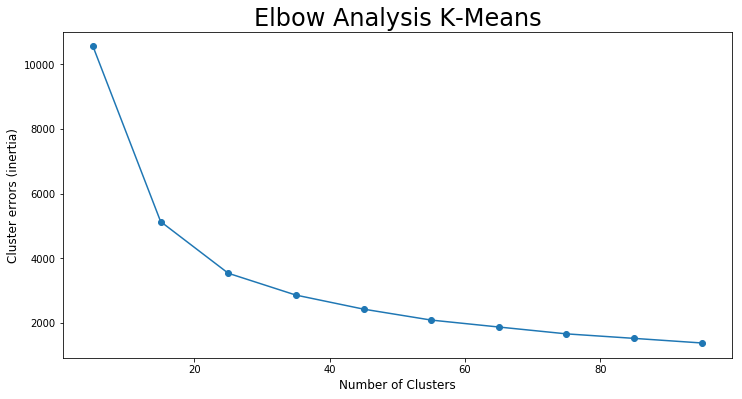

In [23]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.title('Elbow Analysis K-Means',fontsize=24)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Cluster errors (inertia)", fontsize=12)

## Silhouette Analysis

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score
print('K-MEANS')
for n_clusters in cluster_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict( train_test_scaled)
    silhouette_avg = silhouette_score(train_test_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_test_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i


K-MEANS
For n_clusters = 5 The average silhouette_score is : 0.1988919103641511
For n_clusters = 15 The average silhouette_score is : 0.2281113616653016
For n_clusters = 25 The average silhouette_score is : 0.24646170726878755
For n_clusters = 35 The average silhouette_score is : 0.263117072937796
For n_clusters = 45 The average silhouette_score is : 0.2752980434674649
For n_clusters = 55 The average silhouette_score is : 0.28405865718224793
For n_clusters = 65 The average silhouette_score is : 0.29271674517819385
For n_clusters = 75 The average silhouette_score is : 0.29826780644511725
For n_clusters = 85 The average silhouette_score is : 0.30077158571419554
For n_clusters = 95 The average silhouette_score is : 0.30696395622258843


K-SHAPE
0.112 --> 0.096 --> 0.092 --> 0.092 --> 0.095 --> 
For n_clusters = 5 The average silhouette_score is : 0.025940683924247303
0.079 --> 0.071 --> 0.064 --> 0.056 --> 0.059 --> 
For n_clusters = 15 The average silhouette_score is : -0.06157262431714909
0.074 --> 0.058 --> 0.050 --> 0.049 --> 0.049 --> 0.051 --> 
For n_clusters = 25 The average silhouette_score is : -0.07066078691826361
0.067 --> 0.050 --> 0.045 --> 0.044 --> 0.045 --> 
For n_clusters = 35 The average silhouette_score is : -0.07356164517201046
0.064 --> 0.044 --> 0.041 --> 0.042 --> 
For n_clusters = 45 The average silhouette_score is : -0.08953516334765195
0.060 --> 0.042 --> 0.039 --> 0.039 --> 0.039 --> 
For n_clusters = 55 The average silhouette_score is : -0.09944854283924996
0.055 --> 0.039 --> 0.037 --> 0.037 --> 
For n_clusters = 65 The average silhouette_score is : -0.11157828330930275
0.054 --> 0.037 --> 0.035 --> 0.035 --> 
For n_clusters = 75 The average silhouette_score is : -0.11534822687693895
0.051

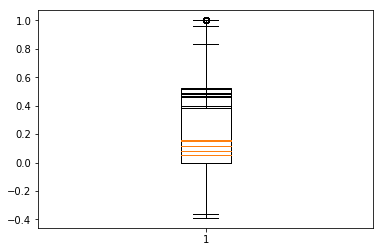

In [55]:
return_pred=0
print('K-SHAPE')
## Time Series Siloette and adjusted rand score
for n_clusters in cluster_range:
    pred_df=cluster_kshape(train, test, data,return_pred, n_clusters)
    silhouette_avg = silhouette_score(train_test_scaled, pred_df.cluster)
    #print("For n_clusters =", n_clusters,
       # "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_test_scaled, pred_df.cluster)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        


In [39]:
train, test = train_test_split(train, test_size=0.3)

cluster_kshape
0.112 --> 0.096 --> 0.092 --> 0.092 --> 0.095 --> 
For n_clusters = 5 The average silhouette_score is : 0.025940683924247303
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:45:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0679086	test: 3.0679086	test1: 3.1716494	best: 3.1716494 (0)	total: 56.4ms	remaining: 28.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.170436574
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.4768262	test: 3.4761827	test1: 4.8427715	best: 4.8427715 (0)	total: 7.08ms	remaining: 3.53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.84277152
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 5.6970626	test: 5.6970626	test1: 1.8039018	best: 1.8039018 (0)	total: 2.59ms	remaining: 1.29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.803901798
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.0187312	test: 2.0194178	test1: 4.4515279	best: 4.4515279 (0)	total: 5.34ms	remaining: 2.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.446306398
bestIteration = 12

Shrink model to first 13 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5166610	test: 3.5168905	test1: 7.5750752	best: 7.5750752 (0)	total: 3ms	remaining: 1.5s
100:	learn: 3.2022967	test: 3.2653228	test1: 7.4321385	best: 7.4319262 (99)	total: 165ms	remaining: 650ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.429454113
bestIteration = 129

Shrink model to first 130 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.079 --> 0.071 --> 0.064 --> 0.056 --> 0.059 --> 
For n_clusters = 15 The average silhouette_score is : -0.06157262431714909
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.7423002	test: 3.7424580	test1: 1.0196589	best: 1.0196589 (0)	total: 1.48ms	remaining: 737ms
100:	learn: 3.2369190	test: 3.4820037	test1: 1.0130193	best: 0.9864883 (51)	total: 146ms	remaining: 577ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9864883177
bestIteration = 51

Shrink model to first 52 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.7977950	test: 4.7977950	test1: 1.9019429	best: 1.9019429 (0)	total: 1ms	remaining: 501ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.897775898
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9568514	test: 1.9589679	test1: 1.7369861	best: 1.7369861 (0)	total: 3.42ms	remaining: 1.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.736986051
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6597132	test: 1.6600212	test1: 11.1146279	best: 11.1146279 (0)	total: 1.48ms	remaining: 737ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.11462785
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.2638651	test: 5.2640104	test1: 2.0054388	best: 2.0054388 (0)	total: 1.08ms	remaining: 540ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.004595378
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9816961	test: 1.9814986	test1: 1.5162688	best: 1.5162688 (0)	total: 1.15ms	remaining: 574ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.51626883
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6246587	test: 1.6255310	test1: 1.3777208	best: 1.3777208 (0)	total: 2.71ms	remaining: 1.35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.376692384
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2588516	test: 1.2594584	test1: 7.4476819	best: 7.4476819 (0)	total: 8.32ms	remaining: 4.15s
100:	learn: 1.0085960	test: 1.0655808	test1: 7.4034724	best: 7.4025339 (98)	total: 147ms	remaining: 582ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.391739551
bestIteration = 139

Shrink model to first 140 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.6250139	test: 5.6251812	test1: 1.0549783	best: 1.0549783 (0)	total: 2.62ms	remaining: 1.31s
100:	learn: 4.5207873	test: 4.8930819	test1: 0.9375873	best: 0.8683022 (54)	total: 154ms	remaining: 609ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8683022002
bestIteration = 54

Shrink model to first 55 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:46:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7031537	test: 1.7031537	test1: 2.3935106	best: 2.3935106 (0)	total: 690us	remaining: 345ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.391797648
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.9997197	test: 5.9991509	test1: 0.8866789	best: 0.8866789 (0)	total: 1.18ms	remaining: 586ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5752117157
bestIteration = 31

Shrink model to first 32 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.1268369	test: 5.1404779	test1: 2.0828216	best: 2.0828216 (0)	total: 2.37ms	remaining: 1.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.079752859
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6240457	test: 1.6248878	test1: 1.4799839	best: 1.4799839 (0)	total: 4.75ms	remaining: 2.37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.479315609
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.1430635	test: 6.1381499	test1: 13.0607567	best: 13.0607567 (0)	total: 2.4ms	remaining: 1.2s
100:	learn: 5.3127756	test: 5.5238544	test1: 12.9821048	best: 12.9006474 (51)	total: 115ms	remaining: 456ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.90064742
bestIteration = 51

Shrink model to first 52 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3986316	test: 1.3986316	test1: 2.7557364	best: 2.7557364 (0)	total: 1.38ms	remaining: 690ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.753716583
bestIteration = 24

Shrink model to first 25 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0.074 --> 0.058 --> 0.050 --> 0.049 --> 0.049 --> 0.051 --> 
For n_clusters = 25 The average silhouette_score is : -0.07066078691826361
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.4041607	test: 8.4277726	test1: 2.3100692	best: 2.3100692 (0)	total: 1.72ms	remaining: 861ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.274693011
bestIteration = 20

Shrink model to first 21 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.9656115	test: 3.9656488	test1: 1.4138772	best: 1.4138772 (0)	total: 5.63ms	remaining: 2.81s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.413877157
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6607616	test: 1.6607616	test1: 1.6113182	best: 1.6113182 (0)	total: 317us	remaining: 159ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.604423469
bestIteration = 12

Shrink model to first 13 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.1699624	test: 5.1699624	test1: 1.6685536	best: 1.6685536 (0)	total: 3.43ms	remaining: 1.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.667618499
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:47:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.8601172	test: 3.8601761	test1: 1.4679222	best: 1.4679222 (0)	total: 7.11ms	remaining: 3.55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.467603503
bestIteration = 14

Shrink model to first 15 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0364008	test: 2.0361634	test1: 2.6924117	best: 2.6924117 (0)	total: 4.02ms	remaining: 2.01s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.692411743
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.0961128	test: 3.0961128	test1: 0.4722657	best: 0.4722657 (0)	total: 1.72ms	remaining: 859ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4159897848
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2483653	test: 1.2483653	test1: 0.2911990	best: 0.2911990 (0)	total: 2.04ms	remaining: 1.02s
100:	learn: 0.8917926	test: 0.9679143	test1: 0.2204966	best: 0.2067631 (66)	total: 120ms	remaining: 476ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2067631012
bestIteration = 66

Shrink model to first 67 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5801107	test: 1.5801107	test1: 2.5820003	best: 2.5820003 (0)	total: 2.54ms	remaining: 1.27s
100:	learn: 1.2361613	test: 1.2873813	test1: 2.5056305	best: 2.5025077 (93)	total: 153ms	remaining: 603ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.48498018
bestIteration = 147

Shrink model to first 148 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8113190	test: 1.8113190	test1: 1.1590876	best: 1.1590876 (0)	total: 1.69ms	remaining: 844ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.159087609
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9981679	test: 1.9981679	test1: 1.4197813	best: 1.4197813 (0)	total: 5.27ms	remaining: 2.63s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.419781256
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1673567	test: 2.1673567	test1: 1.2907192	best: 1.2907192 (0)	total: 4.34ms	remaining: 2.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.286485098
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8640757	test: 1.8640757	test1: 0.8911111	best: 0.8911111 (0)	total: 3.07ms	remaining: 1.53s
100:	learn: 1.5847088	test: 1.6785677	test1: 0.8316005	best: 0.8289780 (97)	total: 132ms	remaining: 523ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8289780111
bestIteration = 97

Shrink model to first 98 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.5534660	test: 7.5896201	test1: 11.9574454	best: 11.9574454 (0)	total: 844us	remaining: 421ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.85264673
bestIteration = 36

Shrink model to first 37 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9149148	test: 1.9160934	test1: 8.6389800	best: 8.6389800 (0)	total: 3.6ms	remaining: 1.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.636242216
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 9.2793393	test: 9.3011915	test1: 0.6040303	best: 0.6040303 (0)	total: 845us	remaining: 422ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5081188144
bestIteration = 20

Shrink model to first 21 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1992081	test: 2.1992081	test1: 1.7085884	best: 1.7085884 (0)	total: 1.9ms	remaining: 947ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.681256925
bestIteration = 35

Shrink model to first 36 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5992432	test: 1.5998469	test1: 7.0775808	best: 7.0775808 (0)	total: 1.8ms	remaining: 896ms
100:	learn: 1.3367883	test: 1.3960919	test1: 6.9971338	best: 6.9940895 (91)	total: 118ms	remaining: 465ms
200:	learn: 1.1568641	test: 1.2651967	test1: 6.9767337	best: 6.9755728 (194)	total: 237ms	remaining: 352ms
300:	learn: 0.9940867	test: 1.1447228	test1: 6.9604003	best: 6.9558644 (288)	total: 376ms	remaining: 249ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.955864352
bestIteration = 288

Shrink model to first 289 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7026414	test: 1.7026414	test1: 0.6112000	best: 0.6112000 (0)	total: 399us	remaining: 199ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5704109985
bestIteration = 15

Shrink model to first 16 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.0927215	test: 7.0927215	test1: 1.4858954	best: 1.4858954 (0)	total: 1.12ms	remaining: 561ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.473345692
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1253896	test: 1.1253896	test1: 1.5063695	best: 1.5063695 (0)	total: 4.39ms	remaining: 2.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.50604411
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:48:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7527390	test: 1.7514905	test1: 11.8156453	best: 11.8156453 (0)	total: 2.06ms	remaining: 1.03s
100:	learn: 1.1689160	test: 1.2745081	test1: 11.7129690	best: 11.7114431 (98)	total: 115ms	remaining: 456ms
200:	learn: 0.8587551	test: 1.0144285	test1: 11.6650298	best: 11.6636871 (196)	total: 221ms	remaining: 329ms
300:	learn: 0.6287954	test: 0.8444937	test1: 11.6288513	best: 11.6244735 (289)	total: 379ms	remaining: 250ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.62447351
bestIteration = 289

Shrink model to first 290 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.5843802	test: 7.5843030	test1: 1.8394601	best: 1.8394601 (0)	total: 6.4ms	remaining: 3.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.839460066
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0125000	test: 1.0125000	test1: 0.8574547	best: 0.8574547 (0)	total: 4.18ms	remaining: 2.08s
100:	learn: 0.6982951	test: 0.7507500	test1: 0.8321704	best: 0.8308308 (99)	total: 139ms	remaining: 548ms
200:	learn: 0.4979672	test: 0.5910942	test1: 0.8282108	best: 0.8202346 (180)	total: 250ms	remaining: 372ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8202346345
bestIteration = 180

Shrink model to first 181 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9856503	test: 1.9927732	test1: 3.4693871	best: 3.4693871 (0)	total: 1.49ms	remaining: 744ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.468051363
bestIteration = 14

Shrink model to first 15 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.067 --> 0.050 --> 0.045 --> 0.044 --> 0.045 --> 
For n_clusters = 35 The average silhouette_score is : -0.07356164517201046
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5267491	test: 1.5267491	test1: 1.2966794	best: 1.2966794 (0)	total: 2.66ms	remaining: 1.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29249322
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5926335	test: 1.5932870	test1: 0.9907378	best: 0.9907378 (0)	total: 3.11ms	remaining: 1.55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9907377645
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 9.0931497	test: 9.1227940	test1: 3.2547660	best: 3.2547660 (0)	total: 1.23ms	remaining: 616ms
100:	learn: 6.5394355	test: 7.5624435	test1: 2.0474150	best: 2.0228584 (94)	total: 99ms	remaining: 391ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.876827114
bestIteration = 116

Shrink model to first 117 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3341052	test: 1.3341052	test1: 1.4436263	best: 1.4436263 (0)	total: 1.24ms	remaining: 616ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.4436263
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.2584624	test: 4.2584624	test1: 1.4492941	best: 1.4492941 (0)	total: 1.2ms	remaining: 597ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.446445096
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:49:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0991688	test: 1.0988958	test1: 1.4417663	best: 1.4417663 (0)	total: 3.13ms	remaining: 1.56s
100:	learn: 0.8361766	test: 0.9118080	test1: 1.4324741	best: 1.4295087 (91)	total: 112ms	remaining: 444ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.423740288
bestIteration = 142

Shrink model to first 143 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.1468347	test: 5.1472928	test1: 2.1456822	best: 2.1456822 (0)	total: 5.96ms	remaining: 2.97s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.141043324
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.4754653	test: 7.4768262	test1: 1.4493138	best: 1.4493138 (0)	total: 8.47ms	remaining: 4.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.401711489
bestIteration = 17

Shrink model to first 18 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7418701	test: 1.7418701	test1: 1.9686071	best: 1.9686071 (0)	total: 1.83ms	remaining: 916ms
100:	learn: 1.2811774	test: 1.4873167	test1: 1.8507996	best: 1.8471664 (95)	total: 128ms	remaining: 505ms
200:	learn: 0.9228216	test: 1.2613450	test1: 1.8001268	best: 1.7982799 (198)	total: 240ms	remaining: 357ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.795173638
bestIteration = 212

Shrink model to first 213 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0392731	test: 2.0420511	test1: 1.5641649	best: 1.5641649 (0)	total: 5.34ms	remaining: 2.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.564164926
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9888746	test: 1.9923065	test1: 2.1802414	best: 2.1802414 (0)	total: 1.93ms	remaining: 965ms
100:	learn: 1.2584798	test: 1.2413477	test1: 2.1641439	best: 2.1500791 (53)	total: 118ms	remaining: 467ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.150079072
bestIteration = 53

Shrink model to first 54 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4129259	test: 1.4152128	test1: 1.9237823	best: 1.9237823 (0)	total: 3.65ms	remaining: 1.82s
100:	learn: 0.9612211	test: 1.1131482	test1: 1.7784038	best: 1.7784038 (100)	total: 142ms	remaining: 560ms
200:	learn: 0.6989203	test: 0.9317043	test1: 1.7414203	best: 1.7412105 (199)	total: 271ms	remaining: 403ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.73856031
bestIteration = 208

Shrink model to first 209 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0349109	test: 1.0349109	test1: 1.3159930	best: 1.3159930 (0)	total: 1.48ms	remaining: 736ms
100:	learn: 0.7336045	test: 0.8086185	test1: 1.2839116	best: 1.2839116 (100)	total: 98.2ms	remaining: 388ms
200:	learn: 0.5855706	test: 0.7050485	test1: 1.2681096	best: 1.2681096 (200)	total: 187ms	remaining: 278ms
300:	learn: 0.4756116	test: 0.6422026	test1: 1.2498449	best: 1.2484899 (297)	total: 290ms	remaining: 192ms
400:	learn: 0.3849519	test: 0.6016934	test1: 1.2275062	best: 1.2274080 (399)	total: 395ms	remaining: 97.6ms
499:	learn: 0.3053183	test: 0.5600285	test1: 1.2033887	best: 1.2033887 (499)	total: 516ms	remaining: 0us

bestTest = 1.203388726
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7241244	test: 1.7241244	test1: 1.3331295	best: 1.3331295 (0)	total: 4.05ms	remaining: 2.02s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.327014909
bestIteration = 38

Shrink model to first 39 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9533189	test: 1.9594832	test1: 12.2782588	best: 12.2782588 (0)	total: 8.08ms	remaining: 4.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.27825883
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.1081976	test: 8.1081976	test1: 1.1583840	best: 1.1583840 (0)	total: 1.13ms	remaining: 564ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.158383975
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8213653	test: 1.8213653	test1: 1.6282735	best: 1.6282735 (0)	total: 2.94ms	remaining: 1.47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.623508363
bestIteration = 8

Shrink model to first 9 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.3576902	test: 1.3576902	test1: 1.4249421	best: 1.4249421 (0)	total: 6.63ms	remaining: 3.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.424942077
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:50:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9197652	test: 1.9189865	test1: 1.9896989	best: 1.9896989 (0)	total: 7.51ms	remaining: 3.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.989698909
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.2202931	test: 7.2214654	test1: 1.9784930	best: 1.9784930 (0)	total: 7.42ms	remaining: 3.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.969672293
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1670326	test: 2.1670326	test1: 1.2397631	best: 1.2397631 (0)	total: 6.43ms	remaining: 3.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.233917379
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0746247	test: 1.0744945	test1: 0.9475147	best: 0.9475147 (0)	total: 2.96ms	remaining: 1.48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9475147033
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.5925734	test: 10.5925734	test1: 0.4710890	best: 0.4710890 (0)	total: 652us	remaining: 326ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4710890203
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.8458655	test: 0.8464919	test1: 2.2999041	best: 2.2999041 (0)	total: 1.56ms	remaining: 778ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.299904093
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3837286	test: 2.3863038	test1: 14.8631490	best: 14.8631490 (0)	total: 828us	remaining: 413ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 14.86314903
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 6.9460773	test: 6.9465396	test1: 12.6081188	best: 12.6081188 (0)	total: 6.98ms	remaining: 3.48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.52876978
bestIteration = 22

Shrink model to first 23 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9272465	test: 1.9272465	test1: 1.2046926	best: 1.2046926 (0)	total: 1.49ms	remaining: 741ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.204692553
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1689533	test: 1.1689533	test1: 1.5722592	best: 1.5722592 (0)	total: 1.08ms	remaining: 540ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.571818349
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.6636646	test: 1.6636646	test1: 1.6739446	best: 1.6739446 (0)	total: 6.77ms	remaining: 3.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.662181123
bestIteration = 7

Shrink model to first 8 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0946586	test: 1.0946586	test1: 1.7636703	best: 1.7636703 (0)	total: 1.7ms	remaining: 851ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.754765571
bestIteration = 14

Shrink model to first 15 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1472298	test: 2.1472298	test1: 1.0375528	best: 1.0375528 (0)	total: 7.3ms	remaining: 3.65s
100:	learn: 1.6769307	test: 1.9784720	test1: 1.0094547	best: 1.0052687 (93)	total: 110ms	remaining: 433ms
200:	learn: 1.2989809	test: 1.7880147	test1: 0.9908598	best: 0.9858791 (177)	total: 219ms	remaining: 326ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9858790656
bestIteration = 177

Shrink model to first 178 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1006358	test: 2.1006358	test1: 0.4948948	best: 0.4948948 (0)	total: 3.38ms	remaining: 1.69s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4928854133
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.7348411	test: 2.7353407	test1: 2.9575288	best: 2.9575288 (0)	total: 5.87ms	remaining: 2.93s
100:	learn: 2.0074445	test: 2.1888426	test1: 2.8620380	best: 2.8593078 (98)	total: 118ms	remaining: 465ms
200:	learn: 1.3951468	test: 1.7090818	test1: 2.8022858	best: 2.7871702 (184)	total: 212ms	remaining: 315ms
300:	learn: 1.0006778	test: 1.4593572	test1: 2.7855546	best: 2.7827645 (297)	total: 303ms	remaining: 200ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.781987685
bestIteration = 306

Shrink model to first 307 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7022681	test: 1.7022681	test1: 8.4057090	best: 8.4057090 (0)	total: 2.94ms	remaining: 1.47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.405620588
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:51:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.064 --> 0.044 --> 0.041 --> 0.042 --> 
For n_clusters = 45 The average silhouette_score is : -0.08953516334765195
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.2252092	test: 10.2252092	test1: 2.2818636	best: 2.2818636 (0)	total: 437us	remaining: 218ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.28186356
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0817258	test: 1.0810630	test1: 1.8696503	best: 1.8696503 (0)	total: 1.17ms	remaining: 586ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.857453147
bestIteration = 39

Shrink model to first 40 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.7953783	test: 2.7953783	test1: 1.5820920	best: 1.5820920 (0)	total: 2.64ms	remaining: 1.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.582091952
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 4.4375091	test: 4.4492416	test1: 1.7499770	best: 1.7499770 (0)	total: 4.77ms	remaining: 2.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.749977021
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.1826213	test: 8.1826213	test1: 2.3509090	best: 2.3509090 (0)	total: 1.54ms	remaining: 770ms
100:	learn: 5.8844070	test: 6.7968475	test1: 2.3996686	best: 2.2851336 (61)	total: 103ms	remaining: 408ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.285133565
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1226465	test: 2.1226465	test1: 1.6807911	best: 1.6807911 (0)	total: 531us	remaining: 265ms
100:	learn: 1.3748528	test: 1.4935328	test1: 1.6502403	best: 1.6343900 (63)	total: 63.8ms	remaining: 252ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.634389977
bestIteration = 63

Shrink model to first 64 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2610479	test: 1.2610052	test1: 0.4791411	best: 0.4791411 (0)	total: 3.55ms	remaining: 1.77s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4718998346
bestIteration = 24

Shrink model to first 25 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:52:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4487539	test: 1.4487539	test1: 1.3768864	best: 1.3768864 (0)	total: 2.74ms	remaining: 1.37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.376886399
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.8348803	test: 0.8352660	test1: 1.8145834	best: 1.8145834 (0)	total: 2.06ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.814183344
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3064835	test: 1.3071477	test1: 0.5488080	best: 0.5488080 (0)	total: 2.88ms	remaining: 1.44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5488079836
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0184839	test: 2.0184839	test1: 1.5052506	best: 1.5052506 (0)	total: 4.5ms	remaining: 2.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.50514968
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3332135	test: 2.3332135	test1: 1.1891547	best: 1.1891547 (0)	total: 2ms	remaining: 1000ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.189154741
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3082965	test: 2.3243811	test1: 16.6250315	best: 16.6250315 (0)	total: 808us	remaining: 403ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.62503147
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0467414	test: 2.0467414	test1: 0.6863268	best: 0.6863268 (0)	total: 1.22ms	remaining: 608ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6805579287
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0285542	test: 1.0285542	test1: 14.9330116	best: 14.9330116 (0)	total: 1.73ms	remaining: 865ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 14.92786328
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6179936	test: 1.6208581	test1: 1.1734086	best: 1.1734086 (0)	total: 4.45ms	remaining: 2.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.173408648
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.7280428	test: 7.7313961	test1: 10.5613330	best: 10.5613330 (0)	total: 1.6ms	remaining: 797ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.54880054
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6923912	test: 1.6919088	test1: 1.8945301	best: 1.8945301 (0)	total: 4.45ms	remaining: 2.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.886289042
bestIteration = 24

Shrink model to first 25 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 8.0840974	test: 8.1244339	test1: 1.9734213	best: 1.9734213 (0)	total: 3.39ms	remaining: 1.69s
100:	learn: 6.1023928	test: 7.4486682	test1: 1.7247151	best: 1.7184209 (84)	total: 127ms	remaining: 503ms
200:	learn: 4.5830165	test: 7.1290642	test1: 1.6364188	best: 1.6048484 (179)	total: 251ms	remaining: 374ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.604848427
bestIteration = 179

Shrink model to first 180 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1452516	test: 2.1460179	test1: 2.1663335	best: 2.1663335 (0)	total: 4.51ms	remaining: 2.25s
100:	learn: 1.6738587	test: 1.8910788	test1: 2.0861006	best: 2.0825171 (97)	total: 152ms	remaining: 602ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.082517147
bestIteration = 97

Shrink model to first 98 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1003587	test: 2.1012793	test1: 1.4119152	best: 1.4119152 (0)	total: 4.94ms	remaining: 2.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.411915197
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.6383875	test: 6.6383875	test1: 2.2282618	best: 2.2282618 (0)	total: 660us	remaining: 330ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.216460094
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0058458	test: 2.0077278	test1: 1.3242308	best: 1.3242308 (0)	total: 2.38ms	remaining: 1.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.321823447
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:53:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3464427	test: 2.3464427	test1: 11.8610476	best: 11.8610476 (0)	total: 472us	remaining: 236ms
100:	learn: 1.3555208	test: 1.3816533	test1: 11.7565510	best: 11.7555178 (87)	total: 47.2ms	remaining: 187ms
200:	learn: 0.8194537	test: 0.8482462	test1: 11.6515585	best: 11.6512794 (198)	total: 106ms	remaining: 158ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.63073713
bestIteration = 233

Shrink model to first 234 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6238189	test: 1.6263636	test1: 1.8738783	best: 1.8738783 (0)	total: 3.07ms	remaining: 1.53s
100:	learn: 1.3214715	test: 1.5177116	test1: 1.7735844	best: 1.7640895 (92)	total: 84.8ms	remaining: 335ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.760690187
bestIteration = 123

Shrink model to first 124 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4096940	test: 1.4090688	test1: 0.5969230	best: 0.5969230 (0)	total: 4.48ms	remaining: 2.23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5969229532
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7285367	test: 0.7294747	test1: 0.7628425	best: 0.7628425 (0)	total: 7.15ms	remaining: 3.57s
100:	learn: 0.5868580	test: 0.6305229	test1: 0.7442021	best: 0.7435607 (90)	total: 141ms	remaining: 556ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7435606777
bestIteration = 90

Shrink model to first 91 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6554010	test: 1.6554010	test1: 1.5017462	best: 1.5017462 (0)	total: 903us	remaining: 451ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501746154
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.8855314	test: 2.8855314	test1: 1.7669935	best: 1.7669935 (0)	total: 717us	remaining: 358ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.766993503
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.4707929	test: 2.4707929	test1: 0.9338713	best: 0.9338713 (0)	total: 4.65ms	remaining: 2.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9268209148
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 8.6747147	test: 8.6747147	test1: 1.5341741	best: 1.5341741 (0)	total: 2.34ms	remaining: 1.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.533645925
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5631030	test: 0.5631030	test1: 0.3997607	best: 0.3997607 (0)	total: 438us	remaining: 219ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3971759087
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2864081	test: 1.2864081	test1: 1.0904660	best: 1.0904660 (0)	total: 1.34ms	remaining: 671ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.038525171
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4887331	test: 2.4970036	test1: 2.1239706	best: 2.1239706 (0)	total: 1.79ms	remaining: 894ms
100:	learn: 1.7347648	test: 1.9807386	test1: 1.9717097	best: 1.9691121 (82)	total: 93.8ms	remaining: 371ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.94924412
bestIteration = 111

Shrink model to first 112 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.4298016	test: 6.4305088	test1: 0.5147769	best: 0.5147769 (0)	total: 4.94ms	remaining: 2.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5080540374
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4422435	test: 2.4422435	test1: 1.8239869	best: 1.8239869 (0)	total: 615us	remaining: 307ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.823986949
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0883147	test: 1.0889406	test1: 11.0979498	best: 11.0979498 (0)	total: 3.09ms	remaining: 1.54s
100:	learn: 0.7173543	test: 0.8046724	test1: 10.9945149	best: 10.9945149 (100)	total: 116ms	remaining: 457ms
200:	learn: 0.4886276	test: 0.6096373	test1: 10.9495455	best: 10.9495455 (200)	total: 204ms	remaining: 303ms
300:	learn: 0.3636707	test: 0.4971820	test1: 10.9312791	best: 10.9289617 (274)	total: 308ms	remaining: 203ms
400:	learn: 0.3038390	test: 0.4434178	test1: 10.9262455	best: 10.9256413 (392)	total: 411ms	remaining: 101ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.92546092
bestIteration = 417

Shrink model to first 418 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1771570	test: 1.1771570	test1: 1.9187155	best: 1.9187155 (0)	total: 1.9ms	remaining: 948ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.918715468
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9431173	test: 1.9431173	test1: 1.5274168	best: 1.5274168 (0)	total: 1.68ms	remaining: 840ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.448520495
bestIteration = 47

Shrink model to first 48 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:54:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9916939	test: 0.9916939	test1: 0.0791716	best: 0.0791716 (0)	total: 779us	remaining: 389ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07917159387
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:55:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6386210	test: 1.6366996	test1: 1.1442518	best: 1.1442518 (0)	total: 1.42ms	remaining: 708ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.144251779
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:55:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3771602	test: 1.3770615	test1: 2.1455484	best: 2.1455484 (0)	total: 2.21ms	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.132755489
bestIteration = 15

Shrink model to first 16 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:55:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7589427	test: 0.7589427	test1: 3.3038595	best: 3.3038595 (0)	total: 2.42ms	remaining: 1.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.303859523
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:55:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0686916	test: 2.0798631	test1: 1.1345028	best: 1.1345028 (0)	total: 1.38ms	remaining: 688ms
100:	learn: 1.3222916	test: 1.4717209	test1: 0.9187323	best: 0.9170958 (97)	total: 80.9ms	remaining: 320ms
200:	learn: 0.8516453	test: 1.1392520	test1: 0.8874484	best: 0.8668319 (169)	total: 173ms	remaining: 257ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8634443914
bestIteration = 217

Shrink model to first 218 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:55:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3401379	test: 1.3403224	test1: 3.9140729	best: 3.9140729 (0)	total: 2.59ms	remaining: 1.29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.914072943
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.060 --> 0.042 --> 0.039 --> 0.039 --> 0.039 --> 
For n_clusters = 55 The average silhouette_score is : -0.09944854283924996
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8717990	test: 1.8716039	test1: 2.6020843	best: 2.6020843 (0)	total: 700us	remaining: 350ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.602084345
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3911879	test: 1.3911270	test1: 1.5148736	best: 1.5148736 (0)	total: 2.19ms	remaining: 1.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.514873637
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.4995815	test: 3.4995815	test1: 0.7922673	best: 0.7922673 (0)	total: 1.61ms	remaining: 806ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7443345242
bestIteration = 49

Shrink model to first 50 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1936466	test: 2.1936466	test1: 0.6966996	best: 0.6966996 (0)	total: 946us	remaining: 472ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6959855524
bestIteration = 5

Shrink model to first 6 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3786919	test: 1.3786919	test1: 1.2330520	best: 1.2330520 (0)	total: 1.34ms	remaining: 669ms
100:	learn: 1.0429771	test: 1.1084389	test1: 1.1966655	best: 1.1954637 (98)	total: 138ms	remaining: 545ms
200:	learn: 0.8758228	test: 0.9920915	test1: 1.1861348	best: 1.1838789 (186)	total: 267ms	remaining: 397ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.183878893
bestIteration = 186

Shrink model to first 187 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5164745	test: 1.5164745	test1: 1.2756545	best: 1.2756545 (0)	total: 1.48ms	remaining: 739ms
100:	learn: 0.9917229	test: 1.0076904	test1: 1.0969093	best: 1.0969093 (100)	total: 101ms	remaining: 399ms
200:	learn: 0.6601678	test: 0.6929417	test1: 1.0653938	best: 1.0616316 (187)	total: 207ms	remaining: 309ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.061631618
bestIteration = 187

Shrink model to first 188 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.2254090	test: 11.2800954	test1: 0.5714107	best: 0.5714107 (0)	total: 1.2ms	remaining: 601ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5714107334
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7992435	test: 0.7992435	test1: 0.2116848	best: 0.2116848 (0)	total: 923us	remaining: 461ms
100:	learn: 0.5303106	test: 0.5583761	test1: 0.0143875	best: 0.0013779 (91)	total: 89.7ms	remaining: 354ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001377932933
bestIteration = 91

Shrink model to first 92 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0483806	test: 2.0541807	test1: 1.4517822	best: 1.4517822 (0)	total: 2.16ms	remaining: 1.08s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.450958078
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7826318	test: 0.7826318	test1: 3.8117942	best: 3.8117942 (0)	total: 949us	remaining: 474ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.793581445
bestIteration = 44

Shrink model to first 45 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5644044	test: 1.5666950	test1: 2.0758007	best: 2.0758007 (0)	total: 1.29ms	remaining: 647ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.045699745
bestIteration = 22

Shrink model to first 23 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2651582	test: 2.2651582	test1: 1.5338384	best: 1.5338384 (0)	total: 2.26ms	remaining: 1.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.529414228
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6685456	test: 1.6695423	test1: 1.3452386	best: 1.3452386 (0)	total: 1ms	remaining: 500ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.340648609
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0193279	test: 2.0290791	test1: 0.6928357	best: 0.6928357 (0)	total: 3.98ms	remaining: 1.99s
100:	learn: 1.3128138	test: 1.5032401	test1: 0.6040766	best: 0.5960925 (98)	total: 123ms	remaining: 486ms
200:	learn: 0.8684637	test: 1.1731246	test1: 0.6003153	best: 0.5624936 (160)	total: 263ms	remaining: 391ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5624935979
bestIteration = 160

Shrink model to first 161 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:56:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4596429	test: 1.4603077	test1: 0.9386721	best: 0.9386721 (0)	total: 1.01ms	remaining: 505ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9019380254
bestIteration = 43

Shrink model to first 44 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1395658	test: 1.1395658	test1: 1.1885644	best: 1.1885644 (0)	total: 1.19ms	remaining: 594ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.187579697
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.5526908	test: 10.6057098	test1: 2.0502219	best: 2.0502219 (0)	total: 1.48ms	remaining: 740ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.035831188
bestIteration = 7

Shrink model to first 8 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7224944	test: 1.7205157	test1: 13.6461867	best: 13.6461867 (0)	total: 408us	remaining: 204ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13.64618673
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2543414	test: 2.2586646	test1: 1.7141627	best: 1.7141627 (0)	total: 3.49ms	remaining: 1.74s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.714162656
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1330598	test: 2.1330598	test1: 2.1059961	best: 2.1059961 (0)	total: 761us	remaining: 380ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.096162039
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7517268	test: 1.7517268	test1: 1.5673009	best: 1.5673009 (0)	total: 874us	remaining: 437ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.563449726
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2119807	test: 1.2119935	test1: 1.6220089	best: 1.6220089 (0)	total: 1.8ms	remaining: 899ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.62200892
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4129518	test: 2.4134371	test1: 10.0390087	best: 10.0390087 (0)	total: 619us	remaining: 309ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.01435116
bestIteration = 23

Shrink model to first 24 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8624329	test: 1.8692768	test1: 11.8005896	best: 11.8005896 (0)	total: 2.1ms	remaining: 1.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.80058963
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9844801	test: 1.9875888	test1: 1.9013401	best: 1.9013401 (0)	total: 781us	remaining: 390ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.899068909
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9754154	test: 1.9754154	test1: 1.7275522	best: 1.7275522 (0)	total: 398us	remaining: 199ms
100:	learn: 1.1988619	test: 1.3092990	test1: 1.0151208	best: 1.0130714 (99)	total: 95.8ms	remaining: 379ms
200:	learn: 0.8758253	test: 1.0566806	test1: 0.9841274	best: 0.9645553 (171)	total: 202ms	remaining: 301ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9645553363
bestIteration = 171

Shrink model to first 172 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0089142	test: 2.0182727	test1: 2.3538775	best: 2.3538775 (0)	total: 1.69ms	remaining: 841ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.353877471
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7557991	test: 1.7557991	test1: 0.5100221	best: 0.5100221 (0)	total: 848us	remaining: 423ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5100221214
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6339281	test: 0.6344317	test1: 0.9354917	best: 0.9354917 (0)	total: 945us	remaining: 472ms
100:	learn: 0.3313626	test: 0.3373530	test1: 0.6210191	best: 0.6210191 (100)	total: 97.4ms	remaining: 385ms
200:	learn: 0.1917515	test: 0.2067741	test1: 0.5037263	best: 0.5030920 (199)	total: 200ms	remaining: 297ms
300:	learn: 0.1172327	test: 0.1448363	test1: 0.4756203	best: 0.4747671 (294)	total: 301ms	remaining: 199ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.474191509
bestIteration = 334

Shrink model to first 335 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.4764629	test: 5.4764629	test1: 2.2311752	best: 2.2311752 (0)	total: 589us	remaining: 294ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.225128571
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.0982588	test: 5.0982588	test1: 1.3738377	best: 1.3738377 (0)	total: 1.54ms	remaining: 770ms
100:	learn: 4.0474848	test: 4.7609895	test1: 1.2900469	best: 1.2891756 (99)	total: 186ms	remaining: 735ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.287992922
bestIteration = 102

Shrink model to first 103 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1750058	test: 1.1750058	test1: 0.9766252	best: 0.9766252 (0)	total: 910us	remaining: 455ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9766252382
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.1078163	test: 6.1082941	test1: 1.6342066	best: 1.6342066 (0)	total: 1.36ms	remaining: 677ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.622167817
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.4679043	test: 10.4685238	test1: 0.9349191	best: 0.9349191 (0)	total: 627us	remaining: 313ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9349191304
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7011094	test: 1.7020899	test1: 2.4293447	best: 2.4293447 (0)	total: 861us	remaining: 430ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.425333731
bestIteration = 6

Shrink model to first 7 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:57:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2689577	test: 1.2689577	test1: 0.6176821	best: 0.6176821 (0)	total: 405us	remaining: 203ms
100:	learn: 0.8255089	test: 0.8669659	test1: 0.3224853	best: 0.3224853 (100)	total: 96.1ms	remaining: 380ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3006064896
bestIteration = 132

Shrink model to first 133 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3481261	test: 1.3481261	test1: 0.2338852	best: 0.2338852 (0)	total: 1.7ms	remaining: 846ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.231707142
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8601754	test: 1.8619775	test1: 1.6248375	best: 1.6248375 (0)	total: 1.15ms	remaining: 575ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.624837544
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8888126	test: 1.8954538	test1: 14.8665783	best: 14.8665783 (0)	total: 385us	remaining: 192ms
100:	learn: 1.2561970	test: 1.3941102	test1: 14.6724833	best: 14.6705044 (99)	total: 40.4ms	remaining: 160ms
200:	learn: 0.9515395	test: 1.1254272	test1: 14.6274029	best: 14.6239421 (196)	total: 109ms	remaining: 162ms
300:	learn: 0.8087251	test: 0.9796398	test1: 14.5986818	best: 14.5948929 (278)	total: 163ms	remaining: 108ms
400:	learn: 0.7494017	test: 0.9129126	test1: 14.5856726	best: 14.5849597 (398)	total: 233ms	remaining: 57.5ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 14.57569872
bestIteration = 443

Shrink model to first 444 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1907703	test: 1.1909238	test1: 0.3440684	best: 0.3440684 (0)	total: 2.41ms	remaining: 1.2s
100:	learn: 0.8271338	test: 0.9139038	test1: 0.0583903	best: 0.0551716 (93)	total: 112ms	remaining: 441ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0005845373017
bestIteration = 143

Shrink model to first 144 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5281767	test: 1.5281767	test1: 1.3512182	best: 1.3512182 (0)	total: 3.71ms	remaining: 1.85s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.351218222
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9025413	test: 1.9025413	test1: 2.2444836	best: 2.2444836 (0)	total: 2.48ms	remaining: 1.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.24448358
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9458692	test: 1.9477285	test1: 2.3117857	best: 2.3117857 (0)	total: 3.01ms	remaining: 1.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.311785702
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7105495	test: 1.7167300	test1: 11.8257963	best: 11.8257963 (0)	total: 6.35ms	remaining: 3.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.82579625
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5828186	test: 0.5828186	test1: 2.7244901	best: 2.7244901 (0)	total: 1.68ms	remaining: 837ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.724377154
bestIteration = 5

Shrink model to first 6 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2358553	test: 2.2358553	test1: 0.8005776	best: 0.8005776 (0)	total: 609us	remaining: 304ms
100:	learn: 1.5932897	test: 1.7066958	test1: 0.6260679	best: 0.6216613 (98)	total: 101ms	remaining: 400ms
200:	learn: 1.0879041	test: 1.3519172	test1: 0.6036595	best: 0.5908617 (157)	total: 209ms	remaining: 311ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5908616966
bestIteration = 157

Shrink model to first 158 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

[16:58:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6040120	test: 0.6040120	test1: 0.9922882	best: 0.9922882 (0)	total: 549us	remaining: 274ms
100:	learn: 0.3869558	test: 0.3869558	test1: 0.9492077	best: 0.9492077 (100)	total: 26.3ms	remaining: 104ms
200:	learn: 0.2496282	test: 0.2496282	test1: 0.9147450	best: 0.9147450 (200)	total: 76.5ms	remaining: 114ms
300:	learn: 0.1610197	test: 0.1610197	test1: 0.8962102	best: 0.8960173 (299)	total: 115ms	remaining: 75.8ms
400:	learn: 0.1085133	test: 0.1085133	test1: 0.8867022	best: 0.8863092 (397)	total: 159ms	remaining: 39.3ms
499:	learn: 0.0753560	test: 0.0753560	test1: 0.8836846	best: 0.8836004 (498)	total: 196ms	remaining: 0us

bestTest = 0.8836004005
bestIteration = 498

Shrink model to first 499 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7297922	test: 1.7297922	test1: 0.9803152	best: 0.9803152 (0)	total: 594us	remaining: 297ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9730563331
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.0285374	test: 10.0285374	test1: 2.3735823	best: 2.3735823 (0)	total: 848us	remaining: 423ms
100:	learn: 7.3568043	test: 7.8723397	test1: 1.7697799	best: 0.0388617 (50)	total: 112ms	remaining: 442ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03886173912
bestIteration = 50

Shrink model to first 51 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:58:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 11.1435967	test: 11.1439340	test1: 0.8037701	best: 0.8037701 (0)	total: 1.42ms	remaining: 711ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8037701011
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:59:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0629513	test: 1.0629513	test1: 0.6697491	best: 0.6697491 (0)	total: 3.46ms	remaining: 1.73s
100:	learn: 0.5853193	test: 0.6053875	test1: 0.3148901	best: 0.3148901 (100)	total: 90.3ms	remaining: 357ms
200:	learn: 0.2915405	test: 0.3197313	test1: 0.2495270	best: 0.2365924 (170)	total: 147ms	remaining: 218ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2365923595
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:59:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3856106	test: 1.3856106	test1: 2.1165687	best: 2.1165687 (0)	total: 842us	remaining: 420ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.094933823
bestIteration = 19

Shrink model to first 20 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:59:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7765709	test: 0.7765709	test1: 2.9619403	best: 2.9619403 (0)	total: 2.8ms	remaining: 1.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.961940347
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[16:59:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9607860	test: 1.9607860	test1: 0.9762334	best: 0.9762334 (0)	total: 806us	remaining: 402ms
100:	learn: 1.1739839	test: 1.1739839	test1: 0.7327646	best: 0.6883237 (65)	total: 42.6ms	remaining: 168ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6883236679
bestIteration = 65

Shrink model to first 66 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.055 --> 0.039 --> 0.037 --> 0.037 --> 
For n_clusters = 65 The average silhouette_score is : -0.11157828330930275
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.1767998	test: 10.1767998	test1: 0.8287126	best: 0.8287126 (0)	total: 519us	remaining: 259ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01031918606
bestIteration = 47

Shrink model to first 48 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5965312	test: 1.6015866	test1: 1.5244578	best: 1.5244578 (0)	total: 1.26ms	remaining: 631ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.497115577
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0957184	test: 1.0977101	test1: 13.5741236	best: 13.5741236 (0)	total: 1.19ms	remaining: 595ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13.57023101
bestIteration = 8

Shrink model to first 9 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4544179	test: 1.4544179	test1: 2.4959116	best: 2.4959116 (0)	total: 3.51ms	remaining: 1.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.495911591
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6336158	test: 1.6367302	test1: 1.0333669	best: 1.0333669 (0)	total: 4.71ms	remaining: 2.35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.032659173
bestIteration = 6

Shrink model to first 7 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4766945	test: 1.4779807	test1: 0.8633737	best: 0.8633737 (0)	total: 3.19ms	remaining: 1.59s
100:	learn: 1.1624592	test: 1.2483546	test1: 0.7479748	best: 0.7397519 (57)	total: 146ms	remaining: 575ms
200:	learn: 0.9038814	test: 1.0704231	test1: 0.7001685	best: 0.6764767 (157)	total: 278ms	remaining: 414ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6764767305
bestIteration = 157

Shrink model to first 158 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5675059	test: 1.5684820	test1: 2.0201246	best: 2.0201246 (0)	total: 2.39ms	remaining: 1.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.020124584
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.6124468	test: 1.6147139	test1: 1.8665093	best: 1.8665093 (0)	total: 1.03ms	remaining: 515ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.86650932
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:00:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3760296	test: 1.3760357	test1: 2.0886869	best: 2.0886869 (0)	total: 480us	remaining: 240ms
100:	learn: 1.0372190	test: 1.1871814	test1: 2.0110131	best: 2.0066342 (92)	total: 104ms	remaining: 410ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.985710194
bestIteration = 142

Shrink model to first 143 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


[17:01:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0986729	test: 2.0986729	test1: 0.8756868	best: 0.8756868 (0)	total: 1.64ms	remaining: 821ms
100:	learn: 1.5735909	test: 1.7374126	test1: 0.7285721	best: 0.7043467 (80)	total: 147ms	remaining: 580ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7043467362
bestIteration = 80

Shrink model to first 81 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.2719615	test: 7.2689943	test1: 0.6789163	best: 0.6789163 (0)	total: 3.88ms	remaining: 1.94s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5761440406
bestIteration = 15

Shrink model to first 16 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7116234	test: 0.7116234	test1: 2.5655364	best: 2.5655364 (0)	total: 1.76ms	remaining: 878ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.565341734
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5727829	test: 1.5736480	test1: 1.3886109	best: 1.3886109 (0)	total: 1.33ms	remaining: 663ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.387397733
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.7478784	test: 11.7531096	test1: 12.7945582	best: 12.7945582 (0)	total: 476us	remaining: 238ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.46011972
bestIteration = 44

Shrink model to first 45 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4009288	test: 1.4080878	test1: 0.8145024	best: 0.8145024 (0)	total: 6.91ms	remaining: 3.45s
100:	learn: 1.0050919	test: 1.1512445	test1: 0.6596911	best: 0.6596911 (100)	total: 162ms	remaining: 641ms
200:	learn: 0.7443436	test: 0.9824733	test1: 0.6318184	best: 0.6310393 (197)	total: 325ms	remaining: 483ms
300:	learn: 0.5674246	test: 0.8825881	test1: 0.6157931	best: 0.6154310 (272)	total: 540ms	remaining: 357ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6142320735
bestIteration = 305

Shrink model to first 306 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.5644188	test: 2.5651746	test1: 12.7127635	best: 12.7127635 (0)	total: 517us	remaining: 258ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.71276345
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2686724	test: 1.2686724	test1: 2.3404928	best: 2.3404928 (0)	total: 677us	remaining: 338ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.340492784
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.8461701	test: 2.8461701	test1: 1.8036901	best: 1.8036901 (0)	total: 747us	remaining: 373ms
100:	learn: 1.8442607	test: 2.1479760	test1: 1.4038261	best: 1.4038261 (100)	total: 83.3ms	remaining: 329ms
200:	learn: 1.1578072	test: 1.7805463	test1: 1.3462418	best: 1.3330253 (184)	total: 200ms	remaining: 297ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.333025265
bestIteration = 184

Shrink model to first 185 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4764726	test: 1.4764726	test1: 1.4820926	best: 1.4820926 (0)	total: 5.67ms	remaining: 2.83s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.477141606
bestIteration = 17

Shrink model to first 18 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5769302	test: 1.5769302	test1: 1.8782864	best: 1.8782864 (0)	total: 898us	remaining: 448ms
100:	learn: 1.1817944	test: 1.2519668	test1: 1.8195997	best: 1.8164148 (81)	total: 181ms	remaining: 714ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.816414803
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4942289	test: 2.4942289	test1: 0.4306618	best: 0.4306618 (0)	total: 1.7ms	remaining: 850ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3377498971
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:01:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3437825	test: 2.3437825	test1: 4.0517933	best: 4.0517933 (0)	total: 605us	remaining: 302ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.051793316
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7436287	test: 1.7446880	test1: 1.2295643	best: 1.2295643 (0)	total: 4.81ms	remaining: 2.4s
100:	learn: 1.2961658	test: 1.4087484	test1: 1.1845744	best: 1.1778065 (66)	total: 166ms	remaining: 654ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.177806472
bestIteration = 66

Shrink model to first 67 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 12.6486978	test: 12.6436186	test1: 2.4548812	best: 2.4548812 (0)	total: 901us	remaining: 450ms
100:	learn: 8.4349035	test: 9.3891491	test1: 2.3432858	best: 2.2784797 (80)	total: 97.8ms	remaining: 387ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.278479694
bestIteration = 80

Shrink model to first 81 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8584527	test: 1.8584527	test1: 1.3349446	best: 1.3349446 (0)	total: 1.04ms	remaining: 521ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.299867058
bestIteration = 23

Shrink model to first 24 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6233673	test: 0.6253480	test1: 0.6977151	best: 0.6977151 (0)	total: 674us	remaining: 337ms
100:	learn: 0.3792620	test: 0.3989917	test1: 0.5744327	best: 0.5744327 (100)	total: 112ms	remaining: 442ms
200:	learn: 0.2431592	test: 0.2712972	test1: 0.5441146	best: 0.5441146 (200)	total: 237ms	remaining: 352ms
300:	learn: 0.1575090	test: 0.1915245	test1: 0.5418853	best: 0.5391621 (252)	total: 377ms	remaining: 249ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5391620902
bestIteration = 252

Shrink model to first 253 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9274707	test: 1.9274707	test1: 1.4080394	best: 1.4080394 (0)	total: 3.83ms	remaining: 1.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.408039446
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 6.3526024	test: 6.3575239	test1: 2.0757626	best: 2.0757626 (0)	total: 6.14ms	remaining: 3.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.075762639
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0487083	test: 1.0503906	test1: 1.2275820	best: 1.2275820 (0)	total: 3.2ms	remaining: 1.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.227581974
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 8.3660804	test: 8.3660804	test1: 2.2817129	best: 2.2817129 (0)	total: 2.25ms	remaining: 1.12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.241839367
bestIteration = 9

Shrink model to first 10 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.0092959	test: 6.0083692	test1: 1.4260907	best: 1.4260907 (0)	total: 1.28ms	remaining: 639ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.426090652
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1700471	test: 1.1703522	test1: 1.8541472	best: 1.8541472 (0)	total: 1.58ms	remaining: 790ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.854147219
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2897392	test: 2.2935775	test1: 1.1714291	best: 1.1714291 (0)	total: 1.81ms	remaining: 905ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.171429079
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3244472	test: 1.3244472	test1: 0.9879880	best: 0.9879880 (0)	total: 3.37ms	remaining: 1.68s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9855591266
bestIteration = 7

Shrink model to first 8 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0746974	test: 3.0746974	test1: 2.5386064	best: 2.5386064 (0)	total: 677us	remaining: 338ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.53860644
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.2899751	test: 3.2910796	test1: 0.0877314	best: 0.0877314 (0)	total: 1.8ms	remaining: 897ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03911094874
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:02:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9314458	test: 1.9402488	test1: 0.5242564	best: 0.5242564 (0)	total: 669us	remaining: 334ms
100:	learn: 1.2171908	test: 1.3744351	test1: 0.2959177	best: 0.2918678 (84)	total: 110ms	remaining: 434ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.291867831
bestIteration = 84

Shrink model to first 85 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2691174	test: 2.2691174	test1: 1.8734740	best: 1.8734740 (0)	total: 2.21ms	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.873473974
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.5323804	test: 2.5373631	test1: 0.8259452	best: 0.8259452 (0)	total: 1.17ms	remaining: 581ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.825693057
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6257290	test: 1.6248997	test1: 2.1617450	best: 2.1617450 (0)	total: 2.25ms	remaining: 1.12s
100:	learn: 1.1562103	test: 1.3063255	test1: 2.0960021	best: 2.0960021 (100)	total: 160ms	remaining: 632ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.082661751
bestIteration = 139

Shrink model to first 140 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.6938472	test: 2.6938472	test1: 1.1090568	best: 1.1090568 (0)	total: 770us	remaining: 384ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.1090568
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7863120	test: 0.7863120	test1: 1.9776405	best: 1.9776405 (0)	total: 1.72ms	remaining: 858ms
100:	learn: 0.4667176	test: 0.5093560	test1: 1.9386412	best: 1.9358417 (96)	total: 153ms	remaining: 605ms
200:	learn: 0.2967215	test: 0.3714002	test1: 1.9160184	best: 1.9099393 (188)	total: 259ms	remaining: 386ms
300:	learn: 0.1980110	test: 0.2858296	test1: 1.9039355	best: 1.8949359 (271)	total: 376ms	remaining: 249ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.894935874
bestIteration = 271

Shrink model to first 272 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9133582	test: 0.9133582	test1: 2.5901319	best: 2.5901319 (0)	total: 1.35ms	remaining: 673ms
100:	learn: 0.5954774	test: 0.7690861	test1: 2.4680256	best: 2.4679991 (99)	total: 131ms	remaining: 519ms
200:	learn: 0.4075906	test: 0.6756075	test1: 2.3655278	best: 2.3655278 (200)	total: 260ms	remaining: 387ms
300:	learn: 0.2725183	test: 0.6048280	test1: 2.3299358	best: 2.3281056 (290)	total: 385ms	remaining: 255ms
400:	learn: 0.1807685	test: 0.5711432	test1: 2.3222978	best: 2.3218351 (361)	total: 521ms	remaining: 129ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.321835138
bestIteration = 361

Shrink model to first 362 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4586265	test: 1.4586265	test1: 0.3549068	best: 0.3549068 (0)	total: 793us	remaining: 396ms
100:	learn: 0.9368779	test: 1.0253054	test1: 0.1285790	best: 0.1264849 (99)	total: 89ms	remaining: 352ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1053432987
bestIteration = 127

Shrink model to first 128 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3046597	test: 1.3059708	test1: 1.0781601	best: 1.0781601 (0)	total: 2.87ms	remaining: 1.43s
100:	learn: 0.8105138	test: 1.1104937	test1: 0.7999161	best: 0.7999161 (100)	total: 99.5ms	remaining: 393ms
200:	learn: 0.5123219	test: 0.9810450	test1: 0.8093564	best: 0.7729989 (153)	total: 171ms	remaining: 255ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7729989299
bestIteration = 153

Shrink model to first 154 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1852376	test: 2.1897206	test1: 1.6017531	best: 1.6017531 (0)	total: 553us	remaining: 276ms
100:	learn: 1.3786493	test: 1.5344920	test1: 1.6192748	best: 1.5699177 (51)	total: 102ms	remaining: 403ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.569917656
bestIteration = 51

Shrink model to first 52 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2177929	test: 1.2195863	test1: 1.8143603	best: 1.8143603 (0)	total: 1.2ms	remaining: 597ms
100:	learn: 0.7443601	test: 0.7866402	test1: 1.7171620	best: 1.7171620 (100)	total: 137ms	remaining: 539ms
200:	learn: 0.5282532	test: 0.6144583	test1: 1.6736481	best: 1.6736481 (200)	total: 276ms	remaining: 410ms
300:	learn: 0.3800002	test: 0.4927619	test1: 1.6617834	best: 1.6612872 (286)	total: 427ms	remaining: 282ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.658508718
bestIteration = 331

Shrink model to first 332 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0509924	test: 1.0509924	test1: 1.3960407	best: 1.3960407 (0)	total: 1.09ms	remaining: 547ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.378721455
bestIteration = 26

Shrink model to first 27 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.6180539	test: 10.6599311	test1: 1.7502181	best: 1.7502181 (0)	total: 533us	remaining: 266ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.738100196
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7149030	test: 1.7149030	test1: 1.8842626	best: 1.8842626 (0)	total: 2.19ms	remaining: 1.09s
100:	learn: 1.1706854	test: 1.4390256	test1: 1.6739100	best: 1.6550159 (82)	total: 122ms	remaining: 481ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.655015861
bestIteration = 82

Shrink model to first 83 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6683163	test: 1.6682171	test1: 3.1015270	best: 3.1015270 (0)	total: 1.6ms	remaining: 797ms
100:	learn: 1.3009560	test: 1.4273439	test1: 2.9793904	best: 2.9793904 (100)	total: 127ms	remaining: 501ms
200:	learn: 1.0086638	test: 1.2118480	test1: 2.8737243	best: 2.8737243 (200)	total: 279ms	remaining: 415ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.870677273
bestIteration = 202

Shrink model to first 203 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2922878	test: 1.2922878	test1: 0.7649620	best: 0.7649620 (0)	total: 391us	remaining: 196ms
100:	learn: 0.8652937	test: 0.9496546	test1: 0.7388149	best: 0.7345573 (85)	total: 91.1ms	remaining: 360ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7340283225
bestIteration = 119

Shrink model to first 120 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:03:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3639291	test: 1.3639291	test1: 0.4822616	best: 0.4822616 (0)	total: 410us	remaining: 205ms
100:	learn: 0.9708977	test: 1.0578333	test1: 0.3911411	best: 0.3911411 (100)	total: 112ms	remaining: 444ms
200:	learn: 0.6753317	test: 0.7991688	test1: 0.3417358	best: 0.3385418 (193)	total: 227ms	remaining: 337ms
300:	learn: 0.4867305	test: 0.6442060	test1: 0.3056179	best: 0.3056179 (300)	total: 344ms	remaining: 227ms
400:	learn: 0.3578486	test: 0.5535728	test1: 0.2983258	best: 0.2975409 (393)	total: 464ms	remaining: 115ms
499:	learn: 0.2675145	test: 0.4914106	test1: 0.2947909	best: 0.2928436 (477)	total: 594ms	remaining: 0us

bestTest = 0.2928436422
bestIteration = 477

Shrink model to first 478 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.7846787	test: 1.7846787	test1: 2.3896955	best: 2.3896955 (0)	total: 2.03ms	remaining: 1.01s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.389695544
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9987840	test: 2.0046045	test1: 1.4005174	best: 1.4005174 (0)	total: 1.04ms	remaining: 522ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372032473
bestIteration = 24

Shrink model to first 25 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1463649	test: 2.1463649	test1: 1.8524436	best: 1.8524436 (0)	total: 773us	remaining: 386ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.829236459
bestIteration = 34

Shrink model to first 35 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0702663	test: 1.0702663	test1: 0.4078886	best: 0.4078886 (0)	total: 226us	remaining: 113ms
100:	learn: 0.4777169	test: 0.4777169	test1: 0.1252259	best: 0.0010267 (66)	total: 23.5ms	remaining: 92.9ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001026743855
bestIteration = 66

Shrink model to first 67 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7284182	test: 1.7282849	test1: 1.1917276	best: 1.1917276 (0)	total: 599us	remaining: 299ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.191727639
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0933206	test: 1.0933206	test1: 1.2223779	best: 1.2223779 (0)	total: 361us	remaining: 180ms
100:	learn: 0.7161233	test: 0.8173603	test1: 1.1792503	best: 1.1744071 (67)	total: 90.4ms	remaining: 357ms
200:	learn: 0.4960672	test: 0.6813113	test1: 1.1492361	best: 1.1476354 (193)	total: 206ms	remaining: 307ms
300:	learn: 0.3423069	test: 0.5860678	test1: 1.1385620	best: 1.1382188 (292)	total: 334ms	remaining: 221ms
400:	learn: 0.2425076	test: 0.5328577	test1: 1.1341078	best: 1.1295401 (362)	total: 471ms	remaining: 116ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.129540086
bestIteration = 362

Shrink model to first 363 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3264087	test: 2.3264087	test1: 1.5645492	best: 1.5645492 (0)	total: 633us	remaining: 316ms
100:	learn: 1.3586591	test: 1.3572515	test1: 1.3178007	best: 1.3133990 (80)	total: 68.1ms	remaining: 269ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.313398963
bestIteration = 80

Shrink model to first 81 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.2438736	test: 0.2438736	test1: 0.6607904	best: 0.6607904 (0)	total: 2.9ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6595239418
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:04:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5953941	test: 0.5953941	test1: 19.1983040	best: 19.1983040 (0)	total: 1.76ms	remaining: 878ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 19.19830405
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.054 --> 0.037 --> 0.035 --> 0.035 --> 
For n_clusters = 75 The average silhouette_score is : -0.11534822687693895
72
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1335167	test: 2.1321992	test1: 2.2174266	best: 2.2174266 (0)	total: 831us	remaining: 415ms
100:	learn: 1.4641086	test: 1.5572882	test1: 2.2265192	best: 2.2062047 (52)	total: 130ms	remaining: 515ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.206204674
bestIteration = 52

Shrink model to first 53 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
74
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8524330	test: 1.8549907	test1: 0.8215175	best: 0.8215175 (0)	total: 1.05ms	remaining: 525ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.82151749
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2683248	test: 2.2809687	test1: 1.9343343	best: 1.9343343 (0)	total: 1.18ms	remaining: 591ms
100:	learn: 1.6475641	test: 1.9432011	test1: 1.9331475	best: 1.9180002 (71)	total: 111ms	remaining: 440ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.918000249
bestIteration = 71

Shrink model to first 72 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7227507	test: 1.7227507	test1: 0.9952004	best: 0.9952004 (0)	total: 373us	remaining: 187ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9884102879
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6770338	test: 1.6788001	test1: 11.9272541	best: 11.9272541 (0)	total: 1.82ms	remaining: 911ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.92725406
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8187138	test: 1.8187138	test1: 3.6507726	best: 3.6507726 (0)	total: 877us	remaining: 438ms
100:	learn: 1.1313092	test: 1.1313092	test1: 3.2206611	best: 3.2206611 (100)	total: 44.4ms	remaining: 175ms
200:	learn: 0.7290534	test: 0.7290534	test1: 2.9376247	best: 2.9376247 (200)	total: 99.3ms	remaining: 148ms
300:	learn: 0.4597603	test: 0.4597603	test1: 2.7418462	best: 2.7418462 (300)	total: 151ms	remaining: 99.7ms
400:	learn: 0.2997816	test: 0.2997816	test1: 2.6638315	best: 2.6638315 (400)	total: 205ms	remaining: 50.6ms
499:	learn: 0.1993490	test: 0.1993490	test1: 2.6367440	best: 2.6339786 (495)	total: 262ms	remaining: 0us

bestTest = 2.633978617
bestIteration = 495

Shrink model to first 496 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2621626	test: 1.2621626	test1: 1.5827395	best: 1.5827395 (0)	total: 501us	remaining: 250ms
100:	learn: 0.6805544	test: 0.6929794	test1: 1.5524519	best: 1.5364454 (54)	total: 81.2ms	remaining: 321ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536445387
bestIteration = 54

Shrink model to first 55 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:05:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2053768	test: 1.2059818	test1: 0.5457229	best: 0.5457229 (0)	total: 1.2ms	remaining: 599ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5312599227
bestIteration = 7

Shrink model to first 8 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6216879	test: 1.6264723	test1: 1.7868830	best: 1.7868830 (0)	total: 1.1ms	remaining: 549ms


100:	learn: 1.1426544	test: 1.3538988	test1: 1.6974443	best: 1.6974443 (100)	total: 104ms	remaining: 410ms
200:	learn: 0.8356832	test: 1.1715588	test1: 1.6973683	best: 1.6696836 (162)	total: 210ms	remaining: 312ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.669683556
bestIteration = 162

Shrink model to first 163 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6035658	test: 1.6094079	test1: 12.7252925	best: 12.7252925 (0)	total: 1.68ms	remaining: 836ms
100:	learn: 1.0074978	test: 1.1807854	test1: 12.5552618	best: 12.5552618 (100)	total: 86.3ms	remaining: 341ms
200:	learn: 0.6478651	test: 0.9145709	test1: 12.5061712	best: 12.5061712 (200)	total: 187ms	remaining: 279ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.48938539
bestIteration = 231

Shrink model to first 232 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2420081	test: 2.2420081	test1: 1.6041839	best: 1.6041839 (0)	total: 1.24ms	remaining: 617ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.599991385
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7598331	test: 1.7598331	test1: 0.5411670	best: 0.5411670 (0)	total: 556us	remaining: 278ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.424021673
bestIteration = 36

Shrink model to first 37 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
69
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2578817	test: 1.2578817	test1: 4.5879386	best: 4.5879386 (0)	total: 744us	remaining: 372ms
100:	learn: 0.8562857	test: 0.8565416	test1: 4.2593208	best: 4.2593208 (100)	total: 60.2ms	remaining: 238ms
200:	learn: 0.6217295	test: 0.6209279	test1: 4.1363834	best: 4.1339736 (197)	total: 138ms	remaining: 206ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.094204752
bestIteration = 244

Shrink model to first 245 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2891611	test: 2.2942147	test1: 0.7589923	best: 0.7589923 (0)	total: 1.25ms	remaining: 623ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7589923155
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2941134	test: 1.2941134	test1: 0.6045031	best: 0.6045031 (0)	total: 3.94ms	remaining: 1.97s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6036774789
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4020771	test: 1.4020771	test1: 1.2660715	best: 1.2660715 (0)	total: 1.6ms	remaining: 797ms
100:	learn: 0.7891650	test: 0.7891650	test1: 1.1504241	best: 1.1460184 (98)	total: 150ms	remaining: 591ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.146018361
bestIteration = 98

Shrink model to first 99 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1060442	test: 1.1060442	test1: 4.6955705	best: 4.6955705 (0)	total: 2.05ms	remaining: 1.02s
100:	learn: 0.7044547	test: 0.7189761	test1: 4.3670134	best: 4.3670134 (100)	total: 86.1ms	remaining: 340ms
200:	learn: 0.4404388	test: 0.4670791	test1: 4.2142363	best: 4.2142363 (200)	total: 173ms	remaining: 258ms
300:	learn: 0.2811971	test: 0.3169363	test1: 4.0887578	best: 4.0887578 (299)	total: 260ms	remaining: 172ms
400:	learn: 0.1822534	test: 0.2220076	test1: 4.0371271	best: 4.0371271 (400)	total: 335ms	remaining: 82.8ms
499:	learn: 0.1188543	test: 0.1609179	test1: 4.0012968	best: 4.0012968 (499)	total: 421ms	remaining: 0us

bestTest = 4.001296835
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
71
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9823112	test: 1.9823112	test1: 16.7146073	best: 16.7146073 (0)	total: 2.93ms	remaining: 1.46s
100:	learn: 1.2496408	test: 1.3178493	test1: 16.6052401	best: 16.6043404 (99)	total: 169ms	remaining: 670ms
200:	learn: 0.8517733	test: 0.9753033	test1: 16.5651092	best: 16.5448169 (170)	total: 285ms	remaining: 424ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.54481687
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7751557	test: 0.7751557	test1: 0.1911272	best: 0.1911272 (0)	total: 4.34ms	remaining: 2.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1911272074
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6091279	test: 1.6091279	test1: 0.7251275	best: 0.7251275 (0)	total: 3.77ms	remaining: 1.88s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7251274671
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0244009	test: 2.0241911	test1: 1.8851085	best: 1.8851085 (0)	total: 1.68ms	remaining: 839ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.884678623
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
68
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1933663	test: 1.1960723	test1: 1.1833953	best: 1.1833953 (0)	total: 5.25ms	remaining: 2.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.182238736
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:06:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9707056	test: 1.9707056	test1: 1.9104103	best: 1.9104103 (0)	total: 1.3ms	remaining: 651ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.894036851
bestIteration = 13

Shrink model to first 14 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1435581	test: 2.1435581	test1: 0.6824557	best: 0.6824557 (0)	total: 3.12ms	remaining: 1.56s
100:	learn: 1.6063828	test: 1.7395223	test1: 0.3151487	best: 0.3124082 (99)	total: 170ms	remaining: 673ms
200:	learn: 1.2835765	test: 1.4821429	test1: 0.2554035	best: 0.2197699 (162)	total: 262ms	remaining: 390ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2197698892
bestIteration = 162

Shrink model to first 163 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5460254	test: 1.5477656	test1: 1.5584579	best: 1.5584579 (0)	total: 5.41ms	remaining: 2.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.558457919
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1659993	test: 1.1663983	test1: 1.2731686	best: 1.2731686 (0)	total: 3.16ms	remaining: 1.58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.250916508
bestIteration = 36

Shrink model to first 37 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0403671	test: 1.0441833	test1: 3.5192569	best: 3.5192569 (0)	total: 2.11ms	remaining: 1.05s
100:	learn: 0.7177716	test: 0.7734870	test1: 3.4977587	best: 3.4961357 (96)	total: 116ms	remaining: 459ms
200:	learn: 0.4991203	test: 0.5781680	test1: 3.4830707	best: 3.4812052 (169)	total: 198ms	remaining: 294ms
300:	learn: 0.3422550	test: 0.4459453	test1: 3.4581877	best: 3.4516936 (292)	total: 281ms	remaining: 186ms
400:	learn: 0.2404955	test: 0.3675351	test1: 3.4490822	best: 3.4490822 (400)	total: 367ms	remaining: 90.7ms
499:	learn: 0.1743411	test: 0.3207463	test1: 3.4288202	best: 3.4286608 (498)	total: 443ms	remaining: 0us

bestTest = 3.428660773
bestIteration = 498

Shrink model to first 499 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 9.3851953	test: 9.3851953	test1: 1.8662079	best: 1.8662079 (0)	total: 753us	remaining: 376ms


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.861323431
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3184733	test: 1.3234227	test1: 1.2888217	best: 1.2888217 (0)	total: 1.23ms	remaining: 612ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.286868523
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6339207	test: 1.6351513	test1: 1.1830262	best: 1.1830262 (0)	total: 3.88ms	remaining: 1.93s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.180131288
bestIteration = 13

Shrink model to first 14 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.6568089	test: 8.6566529	test1: 1.3657668	best: 1.3657668 (0)	total: 1.35ms	remaining: 674ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.365766797
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8098265	test: 0.8098265	test1: 0.5968661	best: 0.5968661 (0)	total: 1.31ms	remaining: 652ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5966822683
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1493632	test: 1.1493632	test1: 1.3341179	best: 1.3341179 (0)	total: 1.93ms	remaining: 962ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.324652943
bestIteration = 28

Shrink model to first 29 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2655975	test: 2.2748653	test1: 1.3002186	best: 1.3002186 (0)	total: 396us	remaining: 198ms
100:	learn: 1.4094054	test: 1.5018736	test1: 0.5564770	best: 0.5321464 (90)	total: 85.8ms	remaining: 339ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5321463631
bestIteration = 90

Shrink model to first 91 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.4805972	test: 6.4818408	test1: 1.2933424	best: 1.2933424 (0)	total: 6.19ms	remaining: 3.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.174576643
bestIteration = 13

Shrink model to first 14 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


65
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1704506	test: 2.1706738	test1: 1.3696357	best: 1.3696357 (0)	total: 858us	remaining: 429ms
100:	learn: 1.4479368	test: 1.5988677	test1: 1.3037284	best: 1.2830032 (58)	total: 97.6ms	remaining: 385ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.283003201
bestIteration = 58

Shrink model to first 59 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2385050	test: 1.2377843	test1: 1.8864610	best: 1.8864610 (0)	total: 1.29ms	remaining: 644ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.886461005
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6321080	test: 1.6321080	test1: 1.1601982	best: 1.1601982 (0)	total: 398us	remaining: 199ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.159416526
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:07:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.6799856	test: 2.6853913	test1: 0.3554274	best: 0.3554274 (0)	total: 1.09ms	remaining: 547ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3554274083
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1713003	test: 1.1748222	test1: 1.3654006	best: 1.3654006 (0)	total: 847us	remaining: 423ms
100:	learn: 0.8255429	test: 0.8927330	test1: 0.8514820	best: 0.8514820 (100)	total: 85.8ms	remaining: 339ms
200:	learn: 0.6285974	test: 0.7432023	test1: 0.6953466	best: 0.6912211 (198)	total: 170ms	remaining: 253ms
300:	learn: 0.4797540	test: 0.6481763	test1: 0.6174477	best: 0.6174477 (300)	total: 309ms	remaining: 204ms
400:	learn: 0.3531748	test: 0.5725335	test1: 0.5240073	best: 0.5217591 (390)	total: 459ms	remaining: 113ms
499:	learn: 0.2728178	test: 0.5156284	test1: 0.4779403	best: 0.4779403 (499)	total: 606ms	remaining: 0us

bestTest = 0.4779402843
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1556846	test: 2.1556846	test1: 1.8033840	best: 1.8033840 (0)	total: 858us	remaining: 428ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.779065281
bestIteration = 42

Shrink model to first 43 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5108678	test: 3.5108678	test1: 0.1088176	best: 0.1088176 (0)	total: 2.82ms	remaining: 1.41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1088176072
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9394582	test: 0.9393248	test1: 1.8854147	best: 1.8854147 (0)	total: 414us	remaining: 207ms
100:	learn: 0.6248959	test: 0.6772501	test1: 1.8231127	best: 1.8227934 (99)	total: 87.2ms	remaining: 344ms
200:	learn: 0.4038224	test: 0.4905671	test1: 1.7937528	best: 1.7850651 (185)	total: 188ms	remaining: 280ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.785065102
bestIteration = 185

Shrink model to first 186 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.7444403	test: 6.7444403	test1: 2.4032361	best: 2.4032361 (0)	total: 268us	remaining: 134ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.403236127
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 13.6343842	test: 13.6343842	test1: 0.2387444	best: 0.2387444 (0)	total: 1.45ms	remaining: 723ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001823198143
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4091632	test: 1.4096946	test1: 1.2922756	best: 1.2922756 (0)	total: 1.24ms	remaining: 619ms
100:	learn: 1.0835819	test: 1.1724468	test1: 1.2378324	best: 1.2378324 (100)	total: 130ms	remaining: 513ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.237229064
bestIteration = 102

Shrink model to first 103 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0429644	test: 2.0435589	test1: 0.9384878	best: 0.9384878 (0)	total: 1.85ms	remaining: 925ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9254911251
bestIteration = 29

Shrink model to first 30 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5408242	test: 1.5475133	test1: 2.8261016	best: 2.8261016 (0)	total: 913us	remaining: 456ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.826101555
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3226076	test: 1.3226076	test1: 0.2029179	best: 0.2029179 (0)	total: 1.26ms	remaining: 628ms
100:	learn: 0.8722362	test: 0.9073261	test1: 0.1653007	best: 0.1520391 (81)	total: 87ms	remaining: 344ms
200:	learn: 0.6362563	test: 0.6905511	test1: 0.0498345	best: 0.0369481 (197)	total: 167ms	remaining: 248ms
300:	learn: 0.4716752	test: 0.5452864	test1: 0.0597263	best: 0.0006655 (263)	total: 273ms	remaining: 180ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0006655018852
bestIteration = 263

Shrink model to first 264 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3749607	test: 1.3778192	test1: 0.0625196	best: 0.0625196 (0)	total: 4.19ms	remaining: 2.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0625196231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 11.2529682	test: 11.2529682	test1: 1.2139792	best: 1.2139792 (0)	total: 1.15ms	remaining: 573ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106310562
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
67
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4065208	test: 1.4065208	test1: 0.2861687	best: 0.2861687 (0)	total: 786us	remaining: 392ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2861687413
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5234443	test: 0.5234443	test1: 0.1997810	best: 0.1997810 (0)	total: 353us	remaining: 176ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1988064563
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6808569	test: 0.6808569	test1: 2.6043134	best: 2.6043134 (0)	total: 866us	remaining: 432ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.604313372
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:08:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.2256637	test: 10.2256637	test1: 2.3632902	best: 2.3632902 (0)	total: 863us	remaining: 431ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.321193052
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5126448	test: 1.5126448	test1: 0.0800825	best: 0.0800825 (0)	total: 1.83ms	remaining: 915ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05855828374
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.6590332	test: 0.6589691	test1: 3.9585365	best: 3.9585365 (0)	total: 2.55ms	remaining: 1.27s
100:	learn: 0.3534361	test: 0.3480642	test1: 3.6180852	best: 3.6180852 (100)	total: 87ms	remaining: 344ms
200:	learn: 0.2332780	test: 0.2198179	test1: 3.5426717	best: 3.5425602 (194)	total: 225ms	remaining: 335ms
300:	learn: 0.1575909	test: 0.1519873	test1: 3.5264661	best: 3.5232497 (284)	total: 303ms	remaining: 200ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.517995714
bestIteration = 329

Shrink model to first 330 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0219868	test: 2.0219868	test1: 0.1252457	best: 0.1252457 (0)	total: 880us	remaining: 439ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1252456879
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
66
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9368738	test: 1.9368738	test1: 2.1206204	best: 2.1206204 (0)	total: 325us	remaining: 162ms
100:	learn: 1.2783432	test: 1.2954147	test1: 2.0886748	best: 2.0842837 (66)	total: 78.6ms	remaining: 310ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.08428373
bestIteration = 66

Shrink model to first 67 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1307374	test: 2.1353862	test1: 0.5572005	best: 0.5572005 (0)	total: 2.49ms	remaining: 1.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5551838367
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
70
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.8438915	test: 11.8438915	test1: 1.0324998	best: 1.0324998 (0)	total: 3.3ms	remaining: 1.65s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.016572681
bestIteration = 7

Shrink model to first 8 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3037935	test: 1.3037935	test1: 0.6891150	best: 0.6891150 (0)	total: 1.96ms	remaining: 979ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6848363339
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6127686	test: 1.6127686	test1: 0.6662390	best: 0.6662390 (0)	total: 3.1ms	remaining: 1.55s
100:	learn: 1.0237944	test: 1.0438097	test1: 0.4376759	best: 0.4080671 (75)	total: 136ms	remaining: 535ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4080670595
bestIteration = 75

Shrink model to first 76 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3642387	test: 2.3642387	test1: 1.8988902	best: 1.8988902 (0)	total: 1.39ms	remaining: 693ms
100:	learn: 1.5228959	test: 1.5545186	test1: 1.7123183	best: 1.7123183 (100)	total: 104ms	remaining: 410ms
200:	learn: 0.9981518	test: 1.0660148	test1: 1.6275334	best: 1.6275334 (200)	total: 229ms	remaining: 340ms
300:	learn: 0.6608914	test: 0.7433364	test1: 1.5471982	best: 1.5469298 (297)	total: 344ms	remaining: 227ms
400:	learn: 0.4630674	test: 0.5819999	test1: 1.5195982	best: 1.5190048 (398)	total: 466ms	remaining: 115ms
499:	learn: 0.3392822	test: 0.4723680	test1: 1.4996706	best: 1.4990772 (484)	total: 584ms	remaining: 0us

bestTest = 1.499077152
bestIteration = 484

Shrink model to first 485 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
73
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4822653	test: 1.4818661	test1: 1.6773352	best: 1.6773352 (0)	total: 2.26ms	remaining: 1.13s
100:	learn: 1.0307644	test: 1.0826227	test1: 1.6162842	best: 1.6082055 (82)	total: 86.3ms	remaining: 341ms
200:	learn: 0.6754088	test: 0.8266816	test1: 1.5550660	best: 1.5550660 (198)	total: 193ms	remaining: 287ms
300:	learn: 0.4875488	test: 0.6925909	test1: 1.4917022	best: 1.4907215 (298)	total: 274ms	remaining: 181ms
400:	learn: 0.3650851	test: 0.6214960	test1: 1.4618187	best: 1.4606474 (395)	total: 345ms	remaining: 85.3ms
499:	learn: 0.2790572	test: 0.5638636	test1: 1.4297559	best: 1.4277274 (493)	total: 444ms	remaining: 0us

bestTest = 1.427727373
bestIteration = 493

Shrink model to first 494 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7142247	test: 0.7156724	test1: 0.9215504	best: 0.9215504 (0)	total: 2.89ms	remaining: 1.44s
100:	learn: 0.5535002	test: 0.6391482	test1: 0.8824676	best: 0.8800296 (54)	total: 222ms	remaining: 875ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8800296016
bestIteration = 54

Shrink model to first 55 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7079399	test: 1.7079399	test1: 16.8101868	best: 16.8101868 (0)	total: 1.23ms	remaining: 613ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.75850286
bestIteration = 32

Shrink model to first 33 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0806603	test: 2.0846340	test1: 1.5651532	best: 1.5651532 (0)	total: 2.53ms	remaining: 1.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.564330739
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.3037466	test: 0.3060983	test1: 1.5435923	best: 1.5435923 (0)	total: 2.82ms	remaining: 1.41s
100:	learn: 0.1731991	test: 0.1899721	test1: 1.4698439	best: 1.4698439 (100)	total: 112ms	remaining: 441ms
200:	learn: 0.1105300	test: 0.1401889	test1: 1.4398638	best: 1.4397636 (199)	total: 189ms	remaining: 281ms
300:	learn: 0.0720826	test: 0.1024179	test1: 1.4250536	best: 1.4250536 (300)	total: 254ms	remaining: 168ms
400:	learn: 0.0450719	test: 0.0786911	test1: 1.4196125	best: 1.4196125 (400)	total: 314ms	remaining: 77.6ms
499:	learn: 0.0289325	test: 0.0655444	test1: 1.4146418	best: 1.4146418 (499)	total: 372ms	remaining: 0us

bestTest = 1.414641763
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:09:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3060752	test: 1.3060752	test1: 0.4981843	best: 0.4981843 (0)	total: 5.21ms	remaining: 2.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4899800407
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:10:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4602089	test: 0.4602089	test1: 0.1371864	best: 0.1371864 (0)	total: 691us	remaining: 345ms
100:	learn: 0.2814693	test: 0.2814693	test1: 0.0430541	best: 0.0430541 (100)	total: 58.8ms	remaining: 232ms
200:	learn: 0.1767446	test: 0.1767446	test1: 0.0108542	best: 0.0002107 (174)	total: 128ms	remaining: 190ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0002106924478
bestIteration = 174

Shrink model to first 175 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:10:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1031785	test: 2.1031785	test1: 13.6235837	best: 13.6235837 (0)	total: 1.7ms	remaining: 849ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13.62358369
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:10:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8128173	test: 1.8128173	test1: 1.9751190	best: 1.9751190 (0)	total: 2.24ms	remaining: 1.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.975119039
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:10:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:10:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2847088	test: 1.2847088	test1: 0.3880128	best: 0.3880128 (0)	total: 660us	remaining: 330ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3880127842
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.051 --> 0.036 --> 0.033 --> 0.032 --> 0.032 --> 
For n_clusters = 85 The average silhouette_score is : -0.11216681292298784
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3899799	test: 1.3899799	test1: 1.3651516	best: 1.3651516 (0)	total: 703us	remaining: 351ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.320082754
bestIteration = 19

Shrink model to first 20 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2305870	test: 2.2305870	test1: 2.4185934	best: 2.4185934 (0)	total: 507us	remaining: 253ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.418593396
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.9323515	test: 10.9323515	test1: 1.6452349	best: 1.6452349 (0)	total: 768us	remaining: 384ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.64523493
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7603227	test: 1.7668763	test1: 1.4297703	best: 1.4297703 (0)	total: 1.09ms	remaining: 543ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.429770311
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0555243	test: 2.0555243	test1: 0.8541681	best: 0.8541681 (0)	total: 1.59ms	remaining: 796ms
100:	learn: 1.5240510	test: 1.6182450	test1: 0.6995208	best: 0.6995208 (100)	total: 172ms	remaining: 680ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.671877823
bestIteration = 143

Shrink model to first 144 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4152313	test: 0.4152313	test1: 0.7451922	best: 0.7451922 (0)	total: 2.29ms	remaining: 1.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7446578883
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:11:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.1028601	test: 7.1052357	test1: 3.1615834	best: 3.1615834 (0)	total: 1.41ms	remaining: 705ms
100:	learn: 5.2270133	test: 5.6887854	test1: 2.8155893	best: 2.7746383 (73)	total: 127ms	remaining: 502ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.774638289
bestIteration = 73

Shrink model to first 74 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
84
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7348876	test: 0.7375492	test1: 0.4851268	best: 0.4851268 (0)	total: 1.74ms	remaining: 866ms
100:	learn: 0.4686868	test: 0.5491085	test1: 0.2956142	best: 0.2956090 (97)	total: 114ms	remaining: 450ms
200:	learn: 0.3039532	test: 0.4378811	test1: 0.1738831	best: 0.1731534 (199)	total: 204ms	remaining: 304ms
300:	learn: 0.2017340	test: 0.3518669	test1: 0.1528014	best: 0.1520532 (295)	total: 295ms	remaining: 195ms
400:	learn: 0.1392372	test: 0.2969783	test1: 0.1436961	best: 0.1421394 (378)	total: 417ms	remaining: 103ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1421393901
bestIteration = 378

Shrink model to first 379 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6174540	test: 1.6176704	test1: 2.4677342	best: 2.4677342 (0)	total: 1.2ms	remaining: 598ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.465920921
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0555107	test: 1.0612950	test1: 1.3889127	best: 1.3889127 (0)	total: 453us	remaining: 226ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.358584456
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6552656	test: 1.6558277	test1: 0.7273525	best: 0.7273525 (0)	total: 731us	remaining: 365ms
100:	learn: 1.0625453	test: 1.1218470	test1: 0.4464145	best: 0.4387565 (95)	total: 78.7ms	remaining: 311ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4387565115
bestIteration = 95

Shrink model to first 96 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1713760	test: 2.1713760	test1: 1.8303300	best: 1.8303300 (0)	total: 1.1ms	remaining: 550ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.819076535
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1543247	test: 1.1552658	test1: 19.1774680	best: 19.1774680 (0)	total: 4.53ms	remaining: 2.26s
100:	learn: 0.7690249	test: 0.8143585	test1: 19.0023344	best: 19.0022514 (99)	total: 108ms	remaining: 427ms
200:	learn: 0.5560293	test: 0.6405361	test1: 18.9425757	best: 18.9425757 (199)	total: 194ms	remaining: 288ms
300:	learn: 0.4284589	test: 0.5517365	test1: 18.9269339	best: 18.9257228 (294)	total: 271ms	remaining: 179ms
400:	learn: 0.3250920	test: 0.4717412	test1: 18.9083000	best: 18.9080041 (396)	total: 349ms	remaining: 86.3ms
499:	learn: 0.2484636	test: 0.4214426	test1: 18.9003029	best: 18.8989397 (489)	total: 424ms	remaining: 0us

bestTest = 18.89893967
bestIteration = 489

Shrink model to first 490 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0825638	test: 2.0899759	test1: 0.1374528	best: 0.1374528 (0)	total: 675us	remaining: 337ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1374528408
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3465337	test: 1.3495262	test1: 0.9044022	best: 0.9044022 (0)	total: 771us	remaining: 385ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9044021754
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.2370833	test: 11.2373988	test1: 1.8183998	best: 1.8183998 (0)	total: 668us	remaining: 334ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.818399817
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2431071	test: 1.2433866	test1: 1.2204951	best: 1.2204951 (0)	total: 895us	remaining: 447ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.21852914
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
76
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3350166	test: 1.3376758	test1: 2.3055578	best: 2.3055578 (0)	total: 1.51ms	remaining: 756ms
100:	learn: 0.8375168	test: 0.9109840	test1: 2.1856433	best: 2.1843730 (92)	total: 89ms	remaining: 352ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.16627841
bestIteration = 129

Shrink model to first 130 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
80
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.2952475	test: 5.2952475	test1: 1.0791069	best: 1.0791069 (0)	total: 364us	remaining: 182ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.068177803
bestIteration = 9

Shrink model to first 10 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8364864	test: 1.8364864	test1: 1.3426692	best: 1.3426692 (0)	total: 362us	remaining: 181ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.342669212
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6244655	test: 1.6244655	test1: 1.4609712	best: 1.4609712 (0)	total: 504us	remaining: 252ms
100:	learn: 1.2102174	test: 1.3200898	test1: 1.3914618	best: 1.3879162 (64)	total: 127ms	remaining: 502ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.387916247
bestIteration = 64

Shrink model to first 65 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7571682	test: 1.7610319	test1: 0.8077417	best: 0.8077417 (0)	total: 1.37ms	remaining: 686ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8016167789
bestIteration = 17

Shrink model to first 18 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
81
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3279894	test: 1.3279894	test1: 19.2905735	best: 19.2905735 (0)	total: 773us	remaining: 386ms
100:	learn: 0.8761428	test: 0.9721172	test1: 19.2024823	best: 19.2024823 (100)	total: 77.4ms	remaining: 306ms
200:	learn: 0.5942493	test: 0.7647539	test1: 19.1655162	best: 19.1639973 (196)	total: 178ms	remaining: 265ms
300:	learn: 0.4155256	test: 0.6420048	test1: 19.1040720	best: 19.1036508 (299)	total: 287ms	remaining: 190ms
400:	learn: 0.3055063	test: 0.5862783	test1: 19.0811160	best: 19.0797583 (396)	total: 406ms	remaining: 100ms
499:	learn: 0.2231988	test: 0.5540320	test1: 19.0589459	best: 19.0587484 (498)	total: 529ms	remaining: 0us

bestTest = 19.05874841
bestIteration = 498

Shrink model to first 499 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:12:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7998494	test: 1.7998494	test1: 0.7578042	best: 0.7578042 (0)	total: 344us	remaining: 172ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7578041809
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2137558	test: 1.2137558	test1: 1.0121155	best: 1.0121155 (0)	total: 2.07ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9887032052
bestIteration = 31

Shrink model to first 32 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
70
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7610848	test: 1.7610848	test1: 2.3621414	best: 2.3621414 (0)	total: 452us	remaining: 226ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.362141419
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7578848	test: 1.7578848	test1: 2.2026677	best: 2.2026677 (0)	total: 803us	remaining: 401ms
100:	learn: 1.0488948	test: 1.1597221	test1: 2.1465007	best: 2.1023940 (76)	total: 79ms	remaining: 312ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.102393951
bestIteration = 76

Shrink model to first 77 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4204282	test: 2.4204282	test1: 2.1800203	best: 2.1800203 (0)	total: 1.43ms	remaining: 715ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.180020296
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3441276	test: 2.3518340	test1: 1.5211891	best: 1.5211891 (0)	total: 2.68ms	remaining: 1.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.521189082
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6979833	test: 1.6991597	test1: 1.1260853	best: 1.1260853 (0)	total: 1.48ms	remaining: 741ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.114828122
bestIteration = 21

Shrink model to first 22 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
79
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6207409	test: 1.6219240	test1: 2.1223231	best: 2.1223231 (0)	total: 3.75ms	remaining: 1.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.122217613
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7907579	test: 1.7908902	test1: 1.5781516	best: 1.5781516 (0)	total: 5.34ms	remaining: 2.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.577883366
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.1747915	test: 11.1747915	test1: 1.6291654	best: 1.6291654 (0)	total: 4.52ms	remaining: 2.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.290263257
bestIteration = 30

Shrink model to first 31 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4596163	test: 1.4596163	test1: 19.1978844	best: 19.1978844 (0)	total: 6.1ms	remaining: 3.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 19.19124942
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3058621	test: 1.3058621	test1: 0.9783311	best: 0.9783311 (0)	total: 1.85ms	remaining: 924ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9783311096
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
73
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3985946	test: 1.3985946	test1: 1.5501218	best: 1.5501218 (0)	total: 1.11ms	remaining: 554ms
100:	learn: 1.0085452	test: 1.1043071	test1: 1.3329192	best: 1.3315783 (96)	total: 114ms	remaining: 449ms
200:	learn: 0.7907439	test: 0.9476950	test1: 1.2829779	best: 1.2821517 (177)	total: 260ms	remaining: 387ms
300:	learn: 0.6282756	test: 0.8538950	test1: 1.2411505	best: 1.2349536 (294)	total: 431ms	remaining: 285ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234953642
bestIteration = 294

Shrink model to first 295 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8744303	test: 1.8744303	test1: 12.6944595	best: 12.6944595 (0)	total: 1.52ms	remaining: 761ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.69445953
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1833877	test: 2.1833877	test1: 0.6088117	best: 0.6088117 (0)	total: 2.56ms	remaining: 1.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5995996826
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 9.7989639	test: 9.8017569	test1: 2.5241841	best: 2.5241841 (0)	total: 2.35ms	remaining: 1.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.485107337
bestIteration = 15

Shrink model to first 16 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9161466	test: 1.9161466	test1: 1.5960246	best: 1.5960246 (0)	total: 3.4ms	remaining: 1.7s
100:	learn: 1.3878634	test: 1.5349897	test1: 1.4518516	best: 1.4442043 (82)	total: 106ms	remaining: 418ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.444204269
bestIteration = 82

Shrink model to first 83 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:13:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.6995023	test: 2.6995023	test1: 2.3393137	best: 2.3393137 (0)	total: 2.22ms	remaining: 1.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.289127887
bestIteration = 47

Shrink model to first 48 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9188792	test: 0.9188998	test1: 1.4921319	best: 1.4921319 (0)	total: 4.16ms	remaining: 2.08s
100:	learn: 0.6934606	test: 0.7381134	test1: 1.4704598	best: 1.4701301 (99)	total: 126ms	remaining: 499ms
200:	learn: 0.5358553	test: 0.6436267	test1: 1.4594821	best: 1.4566233 (162)	total: 247ms	remaining: 367ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.456623331
bestIteration = 162

Shrink model to first 163 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.8440555	test: 0.8440555	test1: 2.4300051	best: 2.4300051 (0)	total: 3.21ms	remaining: 1.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.42593904
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5617821	test: 1.5678523	test1: 1.3104706	best: 1.3104706 (0)	total: 1.63ms	remaining: 816ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.30933199
bestIteration = 12

Shrink model to first 13 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5249447	test: 0.5249447	test1: 1.8437890	best: 1.8437890 (0)	total: 4.4ms	remaining: 2.19s
100:	learn: 0.3117763	test: 0.3188056	test1: 1.8156648	best: 1.8156648 (100)	total: 93ms	remaining: 367ms
200:	learn: 0.1881154	test: 0.2014389	test1: 1.8095078	best: 1.8078014 (189)	total: 174ms	remaining: 258ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.807801351
bestIteration = 189

Shrink model to first 190 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9458913	test: 0.9458913	test1: 0.3988842	best: 0.3988842 (0)	total: 1.55ms	remaining: 776ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3965431064
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1317764	test: 1.1317764	test1: 2.7015463	best: 2.7015463 (0)	total: 2.2ms	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.70045604
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1785536	test: 1.1795209	test1: 1.0938647	best: 1.0938647 (0)	total: 4.42ms	remaining: 2.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.089614345
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
71
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0165486	test: 1.0165486	test1: 1.1263360	best: 1.1263360 (0)	total: 6.17ms	remaining: 3.08s
100:	learn: 0.6421214	test: 0.6924361	test1: 1.0587078	best: 1.0573246 (96)	total: 86.1ms	remaining: 340ms
200:	learn: 0.4146346	test: 0.5159365	test1: 1.0273750	best: 1.0244614 (187)	total: 178ms	remaining: 265ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.024461425
bestIteration = 187

Shrink model to first 188 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5131921	test: 0.5131921	test1: 0.2585687	best: 0.2585687 (0)	total: 1.14ms	remaining: 568ms
100:	learn: 0.2606381	test: 0.2606381	test1: 0.2005653	best: 0.2005653 (100)	total: 63.2ms	remaining: 250ms
200:	learn: 0.1348176	test: 0.1348176	test1: 0.1821112	best: 0.1820834 (197)	total: 117ms	remaining: 174ms
300:	learn: 0.0710142	test: 0.0710142	test1: 0.1786220	best: 0.1785933 (292)	total: 172ms	remaining: 114ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1785933231
bestIteration = 292

Shrink model to first 293 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3354963	test: 2.3394479	test1: 0.7569653	best: 0.7569653 (0)	total: 787us	remaining: 393ms
100:	learn: 1.6886890	test: 1.9211880	test1: 0.6177888	best: 0.6177888 (100)	total: 83.4ms	remaining: 330ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5965218868
bestIteration = 108

Shrink model to first 109 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
72
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.6133761	test: 0.6133761	test1: 0.9028880	best: 0.9028880 (0)	total: 2.9ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.902887982
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
74
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:14:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8857499	test: 1.8857499	test1: 0.5521390	best: 0.5521390 (0)	total: 1.06ms	remaining: 530ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5521390306
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.5256221	test: 2.5277683	test1: 1.8765770	best: 1.8765770 (0)	total: 2.42ms	remaining: 1.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.869166299
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
66
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2513395	test: 1.2513395	test1: 0.8713149	best: 0.8713149 (0)	total: 494us	remaining: 247ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8627654641
bestIteration = 9

Shrink model to first 10 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.2563464	test: 3.2563464	test1: 0.2631435	best: 0.2631435 (0)	total: 1.02ms	remaining: 511ms
100:	learn: 2.1000276	test: 2.1745296	test1: 0.1901292	best: 0.0032703 (54)	total: 67.6ms	remaining: 267ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.003270322618
bestIteration = 54

Shrink model to first 55 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
67
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1879350	test: 1.1879350	test1: 1.5324710	best: 1.5324710 (0)	total: 336us	remaining: 168ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.532471033
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
75
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2485129	test: 2.2485129	test1: 3.6995810	best: 3.6995810 (0)	total: 1.01ms	remaining: 504ms
100:	learn: 1.3807393	test: 1.3807393	test1: 3.5118534	best: 3.5068390 (98)	total: 46.6ms	remaining: 184ms
200:	learn: 0.8709213	test: 0.8709213	test1: 3.3961141	best: 3.3939656 (199)	total: 87.5ms	remaining: 130ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.386764581
bestIteration = 205

Shrink model to first 206 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8129162	test: 0.8129162	test1: 1.1141096	best: 1.1141096 (0)	total: 606us	remaining: 303ms
100:	learn: 0.6525029	test: 0.6987419	test1: 1.0952266	best: 1.0952266 (100)	total: 112ms	remaining: 443ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.094675809
bestIteration = 104

Shrink model to first 105 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9448693	test: 0.9448693	test1: 0.7697837	best: 0.7697837 (0)	total: 723us	remaining: 361ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7520026492
bestIteration = 32

Shrink model to first 33 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
82
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7692618	test: 0.7692618	test1: 3.0210034	best: 3.0210034 (0)	total: 856us	remaining: 428ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.021003431
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.6459483	test: 2.6459483	test1: 1.0324062	best: 1.0324062 (0)	total: 775us	remaining: 387ms
100:	learn: 1.8197920	test: 1.8395524	test1: 0.8321685	best: 0.8134693 (86)	total: 86.6ms	remaining: 342ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7999682218
bestIteration = 120

Shrink model to first 121 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0583501	test: 1.0583501	test1: 1.4049847	best: 1.4049847 (0)	total: 558us	remaining: 279ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.404984674
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4619952	test: 1.4676241	test1: 2.1591172	best: 2.1591172 (0)	total: 869us	remaining: 434ms
100:	learn: 0.9320399	test: 1.0297720	test1: 1.9939645	best: 1.9854949 (90)	total: 73.5ms	remaining: 290ms
200:	learn: 0.5725243	test: 0.7634924	test1: 1.9553467	best: 1.9553467 (200)	total: 162ms	remaining: 240ms
300:	learn: 0.3321629	test: 0.6037399	test1: 1.9387273	best: 1.9321670 (265)	total: 274ms	remaining: 181ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.932167035
bestIteration = 265

Shrink model to first 266 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
78
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1579905	test: 1.1579905	test1: 0.4089338	best: 0.4089338 (0)	total: 261us	remaining: 131ms
100:	learn: 0.7014764	test: 0.7014764	test1: 0.2365859	best: 0.2365859 (100)	total: 13.8ms	remaining: 54.6ms
200:	learn: 0.4249337	test: 0.4249337	test1: 0.1795956	best: 0.1671513 (189)	total: 51.2ms	remaining: 76.1ms
300:	learn: 0.2574123	test: 0.2574123	test1: 0.1110470	best: 0.1110470 (300)	total: 90.9ms	remaining: 60.1ms
400:	learn: 0.1559327	test: 0.1559327	test1: 0.0817687	best: 0.0810794 (399)	total: 129ms	remaining: 31.7ms
499:	learn: 0.0949341	test: 0.0949341	test1: 0.0516608	best: 0.0516608 (499)	total: 166ms	remaining: 0us

bestTest = 0.05166079709
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
68
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 13.5637857	test: 13.5637857	test1: 0.6750718	best: 0.6750718 (0)	total: 1.25ms	remaining: 623ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5986493552
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:15:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7910318	test: 1.7910318	test1: 1.3122253	best: 1.3122253 (0)	total: 307us	remaining: 153ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.312225281
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8764006	test: 1.8764006	test1: 1.0842237	best: 1.0842237 (0)	total: 569us	remaining: 284ms
100:	learn: 1.1366680	test: 1.1366680	test1: 0.3960277	best: 0.3960277 (100)	total: 31ms	remaining: 122ms
200:	learn: 0.6885599	test: 0.6885599	test1: 0.2678073	best: 0.2347353 (166)	total: 67.9ms	remaining: 101ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2347353184
bestIteration = 166

Shrink model to first 167 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
69
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8339771	test: 1.8339771	test1: 23.4965354	best: 23.4965354 (0)	total: 376us	remaining: 188ms
100:	learn: 1.1283797	test: 1.1283797	test1: 23.4218804	best: 23.4195057 (97)	total: 39ms	remaining: 154ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 23.41950568
bestIteration = 97

Shrink model to first 98 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
65
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 12.5757736	test: 12.5757736	test1: 0.7970132	best: 0.7970132 (0)	total: 429us	remaining: 215ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7970132374
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5918689	test: 1.5918810	test1: 3.0576558	best: 3.0576558 (0)	total: 659us	remaining: 329ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.057655787
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.8895005	test: 3.8895005	test1: 1.8333337	best: 1.8333337 (0)	total: 580us	remaining: 289ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.833333725
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7238084	test: 1.7238084	test1: 4.0650367	best: 4.0650367 (0)	total: 427us	remaining: 213ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.065036728
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
77
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.8666749	test: 0.8666749	test1: 0.9074255	best: 0.9074255 (0)	total: 896us	remaining: 447ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9074254689
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5387526	test: 0.5387526	test1: 0.8704857	best: 0.8704857 (0)	total: 521us	remaining: 260ms
100:	learn: 0.3051014	test: 0.3051014	test1: 0.8156444	best: 0.8156444 (100)	total: 57.5ms	remaining: 227ms
200:	learn: 0.1914762	test: 0.1914762	test1: 0.7547042	best: 0.7539570 (197)	total: 139ms	remaining: 207ms
300:	learn: 0.1202404	test: 0.1202404	test1: 0.7048964	best: 0.7048964 (300)	total: 201ms	remaining: 133ms
400:	learn: 0.0754359	test: 0.0754359	test1: 0.6709855	best: 0.6709855 (400)	total: 251ms	remaining: 62ms
499:	learn: 0.0478951	test: 0.0478951	test1: 0.6515562	best: 0.6515562 (499)	total: 297ms	remaining: 0us

bestTest = 0.6515562231
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
83
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8314885	test: 0.8314885	test1: 0.2964735	best: 0.2964735 (0)	total: 2.44ms	remaining: 1.22s
100:	learn: 0.4568293	test: 0.4720907	test1: 0.1031534	best: 0.0007436 (67)	total: 102ms	remaining: 403ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0007435793604
bestIteration = 67

Shrink model to first 68 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0266960	test: 1.0266960	test1: 0.4921049	best: 0.4921049 (0)	total: 1.19ms	remaining: 592ms
100:	learn: 0.6675972	test: 0.6843051	test1: 0.4189013	best: 0.4189013 (100)	total: 130ms	remaining: 515ms
200:	learn: 0.4537969	test: 0.4770490	test1: 0.2840322	best: 0.2840322 (200)	total: 212ms	remaining: 315ms
300:	learn: 0.3302269	test: 0.3604984	test1: 0.1789798	best: 0.1789798 (300)	total: 294ms	remaining: 195ms
400:	learn: 0.2568994	test: 0.2910143	test1: 0.1135362	best: 0.1132030 (397)	total: 345ms	remaining: 85.1ms
499:	learn: 0.2000836	test: 0.2362760	test1: 0.0685642	best: 0.0681533 (496)	total: 399ms	remaining: 0us

bestTest = 0.06815332533
bestIteration = 496

Shrink model to first 497 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:16:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_kshape
0.046 --> 0.034 --> 0.031 --> 0.031 --> Resumed because of empty cluster
Resumed because of empty cluster
0.048 --> 0.033 --> 0.031 --> 0.033 --> 
For n_clusters = 95 The average silhouette_score is : -0.1367713284977164
86
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4568629	test: 0.4568629	test1: 0.8405987	best: 0.8405987 (0)	total: 680us	remaining: 340ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8405986615
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.6012611	test: 2.6012611	test1: 2.4496797	best: 2.4496797 (0)	total: 466us	remaining: 233ms
100:	learn: 1.6013201	test: 1.6890871	test1: 2.1849664	best: 2.1756149 (89)	total: 87.7ms	remaining: 347ms
200:	learn: 1.0711167	test: 1.1749787	test1: 2.1602365	best: 2.1425055 (166)	total: 193ms	remaining: 288ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.14250547
bestIteration = 166

Shrink model to first 167 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
72
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3347635	test: 2.3347635	test1: 1.2643016	best: 1.2643016 (0)	total: 346us	remaining: 173ms
100:	learn: 1.5417401	test: 1.7330621	test1: 1.1116561	best: 1.1102342 (99)	total: 88.5ms	remaining: 350ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.098464769
bestIteration = 142

Shrink model to first 143 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0702286	test: 1.0703156	test1: 1.8654115	best: 1.8654115 (0)	total: 1.43ms	remaining: 715ms
100:	learn: 0.7508240	test: 0.7920516	test1: 1.8167747	best: 1.8101112 (94)	total: 118ms	remaining: 465ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.810111204
bestIteration = 94

Shrink model to first 95 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8486741	test: 1.8486741	test1: 2.2371421	best: 2.2371421 (0)	total: 831us	remaining: 415ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.234247297
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

92
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.3978203	test: 1.3979793	test1: 0.3900422	best: 0.3900422 (0)	total: 1.56ms	remaining: 777ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.361163805
bestIteration = 21

Shrink model to first 22 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
80
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.6030604	test: 2.6030604	test1: 1.4409224	best: 1.4409224 (0)	total: 377us	remaining: 188ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.433783042
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
81
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0870967	test: 2.0870967	test1: 1.7476957	best: 1.7476957 (0)	total: 2.04ms	remaining: 1.02s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.747695696
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.7702325	test: 1.7704829	test1: 0.6693418	best: 0.6693418 (0)	total: 950us	remaining: 474ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693418097
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1312613	test: 2.1312613	test1: 0.4353581	best: 0.4353581 (0)	total: 560us	remaining: 280ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4353581371
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8726106	test: 1.8770379	test1: 1.3635739	best: 1.3635739 (0)	total: 3.03ms	remaining: 1.51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.352561783
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3734565	test: 2.3734565	test1: 1.0486835	best: 1.0486835 (0)	total: 865us	remaining: 432ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.03731592
bestIteration = 22

Shrink model to first 23 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.4625790	test: 3.4614030	test1: 2.7750676	best: 2.7750676 (0)	total: 1.03ms	remaining: 516ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.771943264
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.7960404	test: 11.7960404	test1: 2.5071368	best: 2.5071368 (0)	total: 1.01ms	remaining: 507ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.790973838
bestIteration = 30

Shrink model to first 31 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8398287	test: 1.8398287	test1: 1.0546040	best: 1.0546040 (0)	total: 2.75ms	remaining: 1.37s
100:	learn: 1.3083533	test: 1.4797617	test1: 0.8929642	best: 0.8770689 (68)	total: 147ms	remaining: 579ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8597335175
bestIteration = 122

Shrink model to first 123 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


67
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:19:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5382307	test: 1.5382307	test1: 1.0638310	best: 1.0638310 (0)	total: 2.8ms	remaining: 1.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.063831028
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.0877364	test: 2.0877364	test1: 1.6408894	best: 1.6408894 (0)	total: 1.97ms	remaining: 982ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.640889433
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


89
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2881625	test: 2.2881625	test1: 1.3544157	best: 1.3544157 (0)	total: 2.14ms	remaining: 1.07s
100:	learn: 1.6735707	test: 1.8425780	test1: 1.3047226	best: 1.2891992 (93)	total: 122ms	remaining: 482ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.289199173
bestIteration = 93

Shrink model to first 94 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3578317	test: 1.3602034	test1: 1.2248513	best: 1.2248513 (0)	total: 3.58ms	remaining: 1.78s
100:	learn: 1.0729187	test: 1.2118496	test1: 1.1553167	best: 1.1553167 (100)	total: 172ms	remaining: 678ms
200:	learn: 0.8711557	test: 1.1190674	test1: 1.0704332	best: 1.0700572 (191)	total: 295ms	remaining: 439ms
300:	learn: 0.6762918	test: 1.0375849	test1: 1.0337550	best: 1.0333619 (299)	total: 443ms	remaining: 293ms
400:	learn: 0.5323428	test: 0.9687629	test1: 1.0057039	best: 1.0057039 (400)	total: 578ms	remaining: 143ms
499:	learn: 0.4157124	test: 0.9282630	test1: 0.9895849	best: 0.9894698 (498)	total: 741ms	remaining: 0us

bestTest = 0.9894697595
bestIteration = 498

Shrink model to first 499 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
87
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0713652	test: 1.0727838	test1: 1.4352929	best: 1.4352929 (0)	total: 1.44ms	remaining: 721ms
100:	learn: 0.8305003	test: 0.9926029	test1: 1.4060776	best: 1.4052156 (98)	total: 143ms	remaining: 566ms
200:	learn: 0.6497427	test: 0.9363422	test1: 1.4008580	best: 1.3922191 (166)	total: 280ms	remaining: 417ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.392219066
bestIteration = 166

Shrink model to first 167 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
73
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 11.7348090	test: 11.7351121	test1: 0.9537431	best: 0.9537431 (0)	total: 2.65ms	remaining: 1.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.83246704
bestIteration = 9

Shrink model to first 10 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.3307500	test: 2.3478009	test1: 1.4646072	best: 1.4646072 (0)	total: 4.99ms	remaining: 2.49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.462074844
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
93
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.8631448	test: 0.8652820	test1: 0.6065551	best: 0.6065551 (0)	total: 1.05ms	remaining: 525ms
100:	learn: 0.4539017	test: 0.4919284	test1: 0.5382264	best: 0.5382264 (100)	total: 53.6ms	remaining: 212ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5340207447
bestIteration = 113

Shrink model to first 114 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1948543	test: 1.1948543	test1: 1.1804837	best: 1.1804837 (0)	total: 515us	remaining: 257ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.171671397
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0709429	test: 1.0709429	test1: 1.9668836	best: 1.9668836 (0)	total: 1.51ms	remaining: 754ms
100:	learn: 0.6325253	test: 0.6290039	test1: 1.5210766	best: 1.5210766 (100)	total: 57.4ms	remaining: 227ms
200:	learn: 0.4573073	test: 0.4465802	test1: 1.3461467	best: 1.3461467 (200)	total: 132ms	remaining: 196ms
300:	learn: 0.3992919	test: 0.3865551	test1: 1.2870364	best: 1.2870364 (300)	total: 175ms	remaining: 116ms
400:	learn: 0.3768216	test: 0.3643267	test1: 1.2594487	best: 1.2594487 (400)	total: 221ms	remaining: 54.5ms
499:	learn: 0.3617379	test: 0.3516054	test1: 1.2434966	best: 1.2434966 (499)	total: 271ms	remaining: 0us

bestTest = 1.243496624
bestIteration = 499

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

65
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8500511	test: 1.8502779	test1: 2.3545961	best: 2.3545961 (0)	total: 4.07ms	remaining: 2.03s
100:	learn: 1.2981690	test: 1.3767028	test1: 2.0997167	best: 2.0997167 (100)	total: 146ms	remaining: 577ms
200:	learn: 0.9655242	test: 1.0919944	test1: 1.9542213	best: 1.9542213 (200)	total: 250ms	remaining: 372ms
300:	learn: 0.7635896	test: 0.9363671	test1: 1.8837632	best: 1.8831327 (299)	total: 396ms	remaining: 262ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.865317344
bestIteration = 330

Shrink model to first 331 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8430213	test: 1.8430213	test1: 23.4877520	best: 23.4877520 (0)	total: 690us	remaining: 345ms
100:	learn: 1.1613034	test: 1.3845933	test1: 23.2632832	best: 23.2524860 (90)	total: 89.7ms	remaining: 354ms
200:	learn: 0.7157211	test: 1.0759930	test1: 23.1489847	best: 23.1489847 (200)	total: 183ms	remaining: 272ms
300:	learn: 0.4270568	test: 0.8781925	test1: 23.0841935	best: 23.0822389 (299)	total: 278ms	remaining: 184ms
400:	learn: 0.2441651	test: 0.7743934	test1: 23.0095737	best: 23.0094334 (396)	total: 376ms	remaining: 92.8ms
499:	learn: 0.1471960	test: 0.7135399	test1: 22.9741862	best: 22.9741862 (499)	total: 475ms	remaining: 0us

bestTest = 22.97418625
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
75
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.7609211	test: 8.7904177	test1: 2.5984676	best: 2.5984676 (0)	total: 827us	remaining: 413ms
100:	learn: 5.8552242	test: 6.8308171	test1: 2.4166208	best: 2.4133388 (96)	total: 105ms	remaining: 416ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.399617752
bestIteration = 125

Shrink model to first 126 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9699181	test: 0.9699181	test1: 2.0959331	best: 2.0959331 (0)	total: 3.6ms	remaining: 1.8s
100:	learn: 0.5958945	test: 0.6102187	test1: 1.9171342	best: 1.9162908 (95)	total: 123ms	remaining: 484ms
200:	learn: 0.3898877	test: 0.4132351	test1: 1.8617893	best: 1.8559932 (195)	total: 246ms	remaining: 366ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.855993165
bestIteration = 195

Shrink model to first 196 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

91
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.4005311	test: 2.4005311	test1: 0.7541788	best: 0.7541788 (0)	total: 1.12ms	remaining: 558ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7222727517
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:20:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.5989002	test: 2.5989002	test1: 0.0860510	best: 0.0860510 (0)	total: 3.04ms	remaining: 1.52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07738591153
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6138577	test: 1.6171086	test1: 1.7037321	best: 1.7037321 (0)	total: 486us	remaining: 243ms
100:	learn: 1.2270040	test: 1.3406490	test1: 1.6442153	best: 1.6442153 (100)	total: 136ms	remaining: 538ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.630485872
bestIteration = 131

Shrink model to first 132 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9220489	test: 0.9220489	test1: 1.3779659	best: 1.3779659 (0)	total: 1.02ms	remaining: 508ms
100:	learn: 0.6422930	test: 0.7907889	test1: 1.3108631	best: 1.3066748 (72)	total: 128ms	remaining: 505ms
200:	learn: 0.4465889	test: 0.6752682	test1: 1.2180637	best: 1.2180637 (200)	total: 238ms	remaining: 354ms
300:	learn: 0.2980814	test: 0.5918011	test1: 1.1325969	best: 1.1325508 (299)	total: 349ms	remaining: 231ms
400:	learn: 0.2113647	test: 0.5423373	test1: 1.1062088	best: 1.1052274 (381)	total: 489ms	remaining: 121ms
499:	learn: 0.1583006	test: 0.5163570	test1: 1.0926218	best: 1.0922194 (490)	total: 631ms	remaining: 0us

bestTest = 1.092219407
bestIteration = 490

Shrink model to first 491 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
71
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4184073	test: 1.4172182	test1: 2.2489285	best: 2.2489285 (0)	total: 1.4ms	remaining: 697ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.24892851
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1515048	test: 2.1583538	test1: 1.1177573	best: 1.1177573 (0)	total: 4.79ms	remaining: 2.39s
100:	learn: 1.5452666	test: 1.8523810	test1: 1.0421199	best: 1.0316951 (99)	total: 162ms	remaining: 639ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.031695109
bestIteration = 99

Shrink model to first 100 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.0916654	test: 7.0915143	test1: 0.8913814	best: 0.8913814 (0)	total: 4.1ms	remaining: 2.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8901048453
bestIteration = 6

Shrink model to first 7 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7366697	test: 1.7411413	test1: 0.8989986	best: 0.8989986 (0)	total: 1.41ms	remaining: 703ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8946181884
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.4816074	test: 1.4897354	test1: 2.6915660	best: 2.6915660 (0)	total: 1.03ms	remaining: 514ms
100:	learn: 0.9736507	test: 1.1447558	test1: 2.6662117	best: 2.6466351 (75)	total: 102ms	remaining: 404ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.646635141
bestIteration = 75

Shrink model to first 76 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6279312	test: 1.6292566	test1: 0.7054782	best: 0.7054782 (0)	total: 2.91ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7054781525
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5924716	test: 1.5924716	test1: 0.6460097	best: 0.6460097 (0)	total: 630us	remaining: 315ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.628765994
bestIteration = 6

Shrink model to first 7 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.7899124	test: 1.7899124	test1: 2.1517204	best: 2.1517204 (0)	total: 2.88ms	remaining: 1.44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.133141753
bestIteration = 5

Shrink model to first 6 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4328188	test: 0.4328188	test1: 1.2367972	best: 1.2367972 (0)	total: 1.05ms	remaining: 522ms
100:	learn: 0.2694048	test: 0.3105087	test1: 1.2317462	best: 1.2290525 (82)	total: 104ms	remaining: 412ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.229052497
bestIteration = 82

Shrink model to first 83 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
68
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0362551	test: 1.0362551	test1: 2.7578956	best: 2.7578956 (0)	total: 1.33ms	remaining: 665ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.757895607
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5748006	test: 1.5792038	test1: 0.5546683	best: 0.5546683 (0)	total: 2.87ms	remaining: 1.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5533383696
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
77
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4626951	test: 2.4626951	test1: 1.4191201	best: 1.4191201 (0)	total: 1.29ms	remaining: 642ms
100:	learn: 1.5577599	test: 1.5577599	test1: 0.8360542	best: 0.8360542 (100)	total: 65.8ms	remaining: 260ms
200:	learn: 1.0429453	test: 1.0429453	test1: 0.5794459	best: 0.5787107 (198)	total: 111ms	remaining: 165ms
300:	learn: 0.7114544	test: 0.7114544	test1: 0.4888708	best: 0.4888708 (300)	total: 172ms	remaining: 114ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4737427955
bestIteration = 325

Shrink model to first 326 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0397952	test: 1.0404126	test1: 13.6501690	best: 13.6501690 (0)	total: 970us	remaining: 484ms
100:	learn: 0.6204348	test: 0.6214140	test1: 13.5374595	best: 13.5360491 (91)	total: 85.9ms	remaining: 339ms
200:	learn: 0.4223194	test: 0.4283134	test1: 13.4996215	best: 13.4996215 (200)	total: 176ms	remaining: 262ms
300:	learn: 0.2853051	test: 0.3016228	test1: 13.4622119	best: 13.4621006 (298)	total: 269ms	remaining: 178ms
400:	learn: 0.1950652	test: 0.2266773	test1: 13.4498889	best: 13.4498810 (397)	total: 369ms	remaining: 91ms
499:	learn: 0.1352484	test: 0.1852501	test1: 13.4401231	best: 13.4394112 (491)	total: 482ms	remaining: 0us

bestTest = 13.43941121
bestIteration = 491

Shrink model to first 492 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9138732	test: 0.9138042	test1: 1.7833159	best: 1.7833159 (0)	total: 462us	remaining: 231ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.783315901
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:21:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1780228	test: 1.1780228	test1: 1.0291244	best: 1.0291244 (0)	total: 2.56ms	remaining: 1.28s
100:	learn: 0.8255507	test: 0.9129235	test1: 0.9773188	best: 0.9740267 (95)	total: 140ms	remaining: 552ms
200:	learn: 0.6070054	test: 0.7655406	test1: 0.9296055	best: 0.9296055 (200)	total: 284ms	remaining: 423ms
300:	learn: 0.4188880	test: 0.6532206	test1: 0.9032841	best: 0.9032841 (300)	total: 451ms	remaining: 298ms
400:	learn: 0.2994478	test: 0.5947083	test1: 0.8879915	best: 0.8862029 (386)	total: 627ms	remaining: 155ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8849045821
bestIteration = 424

Shrink model to first 425 iterations.
avg_merchant


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3995790	test: 1.3995790	test1: 1.2630848	best: 1.2630848 (0)	total: 1.48ms	remaining: 739ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.26308483
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5130421	test: 1.5130421	test1: 1.6057537	best: 1.6057537 (0)	total: 2.01ms	remaining: 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.605753669
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 12.6447198	test: 12.6450497	test1: 1.2109691	best: 1.2109691 (0)	total: 917us	remaining: 458ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.209530756
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


66
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.1865290	test: 3.1881425	test1: 1.0236947	best: 1.0236947 (0)	total: 1.29ms	remaining: 647ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.023694663
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


85
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8385473	test: 0.8385473	test1: 13.5844980	best: 13.5844980 (0)	total: 994us	remaining: 496ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13.58449799
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5689191	test: 0.5689191	test1: 1.9262777	best: 1.9262777 (0)	total: 864us	remaining: 431ms
100:	learn: 0.3248219	test: 0.3248219	test1: 1.8446612	best: 1.8446612 (100)	total: 59.7ms	remaining: 236ms
200:	learn: 0.1868987	test: 0.1868987	test1: 1.7927278	best: 1.7927278 (200)	total: 125ms	remaining: 186ms
300:	learn: 0.1062651	test: 0.1062651	test1: 1.7616212	best: 1.7613547 (298)	total: 185ms	remaining: 122ms
400:	learn: 0.0618132	test: 0.0618132	test1: 1.7488090	best: 1.7485593 (396)	total: 246ms	remaining: 60.8ms
499:	learn: 0.0388046	test: 0.0388046	test1: 1.7413141	best: 1.7413141 (499)	total: 309ms	remaining: 0us

bestTest = 1.741314082
bestIteration = 499

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9660719	test: 0.9660719	test1: 0.9991864	best: 0.9991864 (0)	total: 583us	remaining: 291ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9991863927
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2670923	test: 1.2670923	test1: 3.3590623	best: 3.3590623 (0)	total: 773us	remaining: 386ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.35906234
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6667512	test: 1.6667512	test1: 1.1414486	best: 1.1414486 (0)	total: 4.4ms	remaining: 2.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.140797676
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.7069061	test: 0.7069061	test1: 0.1605876	best: 0.1605876 (0)	total: 1.07ms	remaining: 536ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1605876266
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.6930156	test: 2.6930156	test1: 1.8713505	best: 1.8713505 (0)	total: 1.09ms	remaining: 545ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.871350467
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


88
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2820081	test: 2.2908854	test1: 0.5556060	best: 0.5556060 (0)	total: 683us	remaining: 341ms
100:	learn: 1.6048527	test: 1.7702562	test1: 0.3690999	best: 0.3668279 (96)	total: 79.1ms	remaining: 312ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3538519312
bestIteration = 136

Shrink model to first 137 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
83
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.3834781	test: 0.3834781	test1: 0.7702525	best: 0.7702525 (0)	total: 424us	remaining: 212ms
100:	learn: 0.2325375	test: 0.2325375	test1: 0.7578574	best: 0.7578574 (100)	total: 17.3ms	remaining: 68.5ms
200:	learn: 0.1411475	test: 0.1411475	test1: 0.7559672	best: 0.7550210 (185)	total: 70.8ms	remaining: 105ms
300:	learn: 0.0861313	test: 0.0861313	test1: 0.7534354	best: 0.7531599 (282)	total: 123ms	remaining: 81.3ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7531598935
bestIteration = 282

Shrink model to first 283 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1206645	test: 2.1206645	test1: 0.0291614	best: 0.0291614 (0)	total: 642us	remaining: 321ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01706813894
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8896886	test: 0.8896886	test1: 1.2556442	best: 1.2556442 (0)	total: 2.24ms	remaining: 1.12s
100:	learn: 0.5989978	test: 0.6850288	test1: 1.2388543	best: 1.2220155 (57)	total: 99.7ms	remaining: 394ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.222015489
bestIteration = 57

Shrink model to first 58 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


90
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 16.5878395	test: 16.5878395	test1: 16.7731629	best: 16.7731629 (0)	total: 548us	remaining: 274ms
100:	learn: 11.9136658	test: 12.1606388	test1: 15.2904260	best: 15.2904260 (100)	total: 71.8ms	remaining: 284ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.19466392
bestIteration = 115

Shrink model to first 116 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5153864	test: 3.5153864	test1: 1.8360813	best: 1.8360813 (0)	total: 624us	remaining: 312ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.836081265
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9536007	test: 0.9536007	test1: 1.3300061	best: 1.3300061 (0)	total: 606us	remaining: 303ms
100:	learn: 0.5246098	test: 0.5307181	test1: 1.2852696	best: 1.2851855 (92)	total: 90.1ms	remaining: 356ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.283894119
bestIteration = 108

Shrink model to first 109 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
69
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4184846	test: 0.4184846	test1: 3.0074854	best: 3.0074854 (0)	total: 953us	remaining: 476ms
100:	learn: 0.2046059	test: 0.2046059	test1: 2.9113102	best: 2.9107804 (99)	total: 43.5ms	remaining: 172ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.904845911
bestIteration = 143

Shrink model to first 144 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:22:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8400377	test: 1.8400377	test1: 1.0874276	best: 1.0874276 (0)	total: 920us	remaining: 459ms
100:	learn: 1.1951398	test: 1.2797539	test1: 1.0743845	best: 1.0576893 (61)	total: 143ms	remaining: 565ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.057689314
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
79
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0357417	test: 1.0357417	test1: 1.2880869	best: 1.2880869 (0)	total: 948us	remaining: 473ms
100:	learn: 0.7704434	test: 0.8634733	test1: 1.1640538	best: 1.1613023 (87)	total: 111ms	remaining: 437ms
200:	learn: 0.5935914	test: 0.7626149	test1: 1.0603615	best: 1.0567365 (184)	total: 226ms	remaining: 337ms
300:	learn: 0.4478872	test: 0.6635856	test1: 1.0273848	best: 1.0273848 (300)	total: 340ms	remaining: 225ms
400:	learn: 0.3296091	test: 0.5858034	test1: 1.0129599	best: 1.0062415 (378)	total: 477ms	remaining: 118ms
499:	learn: 0.2499483	test: 0.5300125	test1: 0.9945066	best: 0.9922291 (493)	total: 612ms	remaining: 0us

bestTest = 0.9922291214
bestIteration = 493

Shrink model to first 494 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 14.8386773	test: 14.8386773	test1: 1.2176722	best: 1.2176722 (0)	total: 1.25ms	remaining: 626ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.215406778
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6697167	test: 0.6697167	test1: 0.7425591	best: 0.7425591 (0)	total: 722us	remaining: 360ms
100:	learn: 0.4219628	test: 0.4411221	test1: 0.6749014	best: 0.6737175 (97)	total: 63.6ms	remaining: 251ms
200:	learn: 0.2756139	test: 0.3377388	test1: 0.6469960	best: 0.6467483 (199)	total: 143ms	remaining: 213ms
300:	learn: 0.1753075	test: 0.2783263	test1: 0.6428496	best: 0.6414798 (295)	total: 218ms	remaining: 144ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6411100559
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
94
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8909071	test: 0.8909071	test1: 0.9108181	best: 0.9108181 (0)	total: 964us	remaining: 481ms
100:	learn: 0.5550783	test: 0.5786530	test1: 0.8680542	best: 0.8618899 (57)	total: 85.7ms	remaining: 339ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8618898782
bestIteration = 57

Shrink model to first 58 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
82
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3099871	test: 2.3099871	test1: 2.0212929	best: 2.0212929 (0)	total: 690us	remaining: 345ms
100:	learn: 1.3545795	test: 1.3525128	test1: 1.7807707	best: 1.7742916 (92)	total: 65.2ms	remaining: 258ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.774291568
bestIteration = 92

Shrink model to first 93 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.2166571	test: 0.2166571	test1: 1.7577790	best: 1.7577790 (0)	total: 830us	remaining: 414ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.757226819
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
70
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9576330	test: 0.9576330	test1: 2.3454389	best: 2.3454389 (0)	total: 469us	remaining: 234ms
100:	learn: 0.5490310	test: 0.5637583	test1: 2.0982503	best: 2.0982503 (100)	total: 52.6ms	remaining: 208ms
200:	learn: 0.3877620	test: 0.4344178	test1: 2.0153613	best: 2.0153613 (200)	total: 133ms	remaining: 198ms
300:	learn: 0.3136368	test: 0.3756239	test1: 1.9860083	best: 1.9860083 (300)	total: 214ms	remaining: 141ms
400:	learn: 0.2457839	test: 0.3161570	test1: 1.9782968	best: 1.9769557 (368)	total: 292ms	remaining: 72.1ms
499:	learn: 0.2051844	test: 0.2815205	test1: 1.9748919	best: 1.9745973 (454)	total: 367ms	remaining: 0us

bestTest = 1.974597302
bestIteration = 454

Shrink model to first 455 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3309478	test: 2.3309478	test1: 2.3085211	best: 2.3085211 (0)	total: 350us	remaining: 175ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.283856793
bestIteration = 32

Shrink model to first 33 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


[17:23:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8431643	test: 1.8431643	test1: 19.1806003	best: 19.1806003 (0)	total: 596us	remaining: 298ms
100:	learn: 1.1061896	test: 1.1133710	test1: 18.7934439	best: 18.7934439 (100)	total: 54.2ms	remaining: 214ms
200:	learn: 0.7009001	test: 0.7172788	test1: 18.7261748	best: 18.7132997 (185)	total: 127ms	remaining: 189ms
300:	learn: 0.4665857	test: 0.4872650	test1: 18.7023191	best: 18.6983414 (252)	total: 209ms	remaining: 138ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 18.69834143
bestIteration = 252

Shrink model to first 253 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3683228	test: 1.3697866	test1: 3.9044891	best: 3.9044891 (0)	total: 868us	remaining: 433ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.904489083
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


84
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3958440	test: 1.3958440	test1: 1.1282393	best: 1.1282393 (0)	total: 989us	remaining: 494ms
100:	learn: 0.8516564	test: 0.9934241	test1: 0.9248224	best: 0.9241625 (84)	total: 73ms	remaining: 289ms
200:	learn: 0.5259562	test: 0.8263263	test1: 0.8083642	best: 0.8033383 (187)	total: 141ms	remaining: 210ms
300:	learn: 0.3122666	test: 0.7362352	test1: 0.7744453	best: 0.7649283 (255)	total: 221ms	remaining: 146ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7649283182
bestIteration = 255

Shrink model to first 256 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6563031	test: 1.6563031	test1: 1.6549798	best: 1.6549798 (0)	total: 958us	remaining: 478ms
100:	learn: 1.1199766	test: 1.1257453	test1: 1.6127901	best: 1.6122260 (94)	total: 73.1ms	remaining: 289ms
200:	learn: 0.9002497	test: 0.9147745	test1: 1.5797768	best: 1.5795144 (196)	total: 144ms	remaining: 214ms
300:	learn: 0.7662153	test: 0.8058926	test1: 1.5636891	best: 1.5636891 (300)	total: 219ms	remaining: 144ms
400:	learn: 0.6739146	test: 0.7369633	test1: 1.5549447	best: 1.5522043 (373)	total: 293ms	remaining: 72.3ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.552204277
bestIteration = 373

Shrink model to first 374 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

74
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4967191	test: 0.4967191	test1: 1.5638844	best: 1.5638844 (0)	total: 605us	remaining: 302ms
100:	learn: 0.2723751	test: 0.3332766	test1: 1.4193837	best: 1.4193837 (100)	total: 66.9ms	remaining: 264ms
200:	learn: 0.1508287	test: 0.2428137	test1: 1.3514156	best: 1.3509703 (196)	total: 144ms	remaining: 214ms
300:	learn: 0.0852201	test: 0.1980948	test1: 1.3142580	best: 1.3142580 (300)	total: 230ms	remaining: 152ms
400:	learn: 0.0510581	test: 0.1732453	test1: 1.2937032	best: 1.2937032 (400)	total: 320ms	remaining: 79.1ms
499:	learn: 0.0316490	test: 0.1598960	test1: 1.2845928	best: 1.2845928 (499)	total: 408ms	remaining: 0us

bestTest = 1.284592815
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5884631	test: 1.5884631	test1: 0.1358744	best: 0.1358744 (0)	total: 860us	remaining: 430ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1299549221
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


76
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1686320	test: 1.1686320	test1: 0.1522854	best: 0.1522854 (0)	total: 309us	remaining: 154ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1522854426
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3239578	test: 1.3239578	test1: 0.4548505	best: 0.4548505 (0)	total: 348us	remaining: 174ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.454850537
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
78
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:23:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9281522	test: 1.9281522	test1: 0.7227361	best: 0.7227361 (0)	total: 484us	remaining: 242ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7227360987
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3844898	test: 1.3844898	test1: 1.9899038	best: 1.9899038 (0)	total: 287us	remaining: 143ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.987092807
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5214219	test: 3.5214219	test1: 4.5696606	best: 4.5696606 (0)	total: 1.07ms	remaining: 534ms
100:	learn: 3.2780734	test: 3.3278981	test1: 4.5416775	best: 4.5409654 (99)	total: 269ms	remaining: 1.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.534937642
bestIteration = 112

Shrink model to first 113 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.7195695	test: 3.7195695	test1: 4.3621533	best: 4.3621533 (0)	total: 962us	remaining: 480ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.360872565
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.7770651	test: 3.7802764	test1: 1.2653359	best: 1.2653359 (0)	total: 3.04ms	remaining: 1.52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.264720207
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4832793	test: 0.4832793	test1: 0.6687001	best: 0.6687001 (0)	total: 389us	remaining: 194ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6679949718
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9526296	test: 1.9577256	test1: 0.8890998	best: 0.8890998 (0)	total: 3.73ms	remaining: 1.86s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8862185658
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.5239544	test: 4.5246907	test1: 5.2537407	best: 5.2537407 (0)	total: 3.46ms	remaining: 1.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.253663816
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6845651	test: 1.6855909	test1: 1.6707884	best: 1.6707884 (0)	total: 1.61ms	remaining: 802ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.659512371
bestIteration = 43

Shrink model to first 44 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1850875	test: 1.1850875	test1: 1.2105874	best: 1.2105874 (0)	total: 419us	remaining: 209ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.19716259
bestIteration = 34

Shrink model to first 35 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.3675240	test: 4.3796677	test1: 5.5613024	best: 5.5613024 (0)	total: 3.27ms	remaining: 1.63s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.553110909
bestIteration = 14

Shrink model to first 15 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.1847982	test: 4.1847615	test1: 6.3012369	best: 6.3012369 (0)	total: 921us	remaining: 460ms
100:	learn: 3.7036763	test: 3.8721936	test1: 6.2579658	best: 6.2431348 (69)	total: 175ms	remaining: 690ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.243134843
bestIteration = 69

Shrink model to first 70 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.8872589	test: 3.8877063	test1: 4.9814935	best: 4.9814935 (0)	total: 995us	remaining: 497ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.97013776
bestIteration = 24

Shrink model to first 25 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0785989	test: 2.0785989	test1: 1.1523881	best: 1.1523881 (0)	total: 845us	remaining: 422ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.152301373
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.9869006	test: 5.0089128	test1: 1.3084485	best: 1.3084485 (0)	total: 6.8ms	remaining: 3.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.308448531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8222631	test: 0.8222631	test1: 0.7001417	best: 0.7001417 (0)	total: 682us	remaining: 341ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6997022726
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:24:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7400248	test: 0.7400248	test1: 1.2857902	best: 1.2857902 (0)	total: 461us	remaining: 230ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.28579018
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5207501	test: 0.5207501	test1: 0.5625255	best: 0.5625255 (0)	total: 364us	remaining: 182ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5625254674
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5078706	test: 1.5078426	test1: 0.6545077	best: 0.6545077 (0)	total: 1ms	remaining: 499ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6236629806
bestIteration = 14

Shrink model to first 15 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7950025	test: 1.7950025	test1: 0.9754293	best: 0.9754293 (0)	total: 1.22ms	remaining: 609ms
100:	learn: 1.4216063	test: 1.6039058	test1: 0.9646419	best: 0.9457519 (53)	total: 161ms	remaining: 636ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9457518802
bestIteration = 53

Shrink model to first 54 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.2927946	test: 5.2921699	test1: 4.4956085	best: 4.4956085 (0)	total: 4.87ms	remaining: 2.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.495608513
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9008956	test: 1.9016623	test1: 5.0611698	best: 5.0611698 (0)	total: 5.43ms	remaining: 2.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.049230872
bestIteration = 37

Shrink model to first 38 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.4704292	test: 1.4713193	test1: 1.3095047	best: 1.3095047 (0)	total: 1.83ms	remaining: 916ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.291907048
bestIteration = 15

Shrink model to first 16 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6793946	test: 1.6799879	test1: 6.3391491	best: 6.3391491 (0)	total: 1.22ms	remaining: 607ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.339149115
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9680025	test: 1.9693062	test1: 1.0557906	best: 1.0557906 (0)	total: 1.56ms	remaining: 777ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.054860846
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.2785839	test: 4.2785839	test1: 5.4442594	best: 5.4442594 (0)	total: 836us	remaining: 418ms
100:	learn: 3.7633978	test: 3.8883202	test1: 5.3643731	best: 5.3566874 (87)	total: 169ms	remaining: 667ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.356687403
bestIteration = 87

Shrink model to first 88 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.0122627	test: 6.0122021	test1: 6.1462156	best: 6.1462156 (0)	total: 808us	remaining: 404ms
100:	learn: 5.0000827	test: 5.4877258	test1: 5.9935425	best: 5.9899500 (96)	total: 173ms	remaining: 682ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.97134572
bestIteration = 136

Shrink model to first 137 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6793722	test: 1.6793722	test1: 1.3661353	best: 1.3661353 (0)	total: 1.36ms	remaining: 678ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.356926847
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.4528412	test: 3.4534072	test1: 1.6304329	best: 1.6304329 (0)	total: 1.88ms	remaining: 938ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.618350797
bestIteration = 23

Shrink model to first 24 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.7252438	test: 11.7252438	test1: 0.4207267	best: 0.4207267 (0)	total: 529us	remaining: 264ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01941432258
bestIteration = 25

Shrink model to first 26 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4723746	test: 0.4723746	test1: 1.0454755	best: 1.0454755 (0)	total: 294us	remaining: 147ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.030821537
bestIteration = 19

Shrink model to first 20 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7232125	test: 1.7232125	test1: 1.6663819	best: 1.6663819 (0)	total: 865us	remaining: 432ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.628486667
bestIteration = 23

Shrink model to first 24 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:25:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1215449	test: 1.1221419	test1: 1.4566410	best: 1.4566410 (0)	total: 1.61ms	remaining: 804ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.454825578
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4939743	test: 0.4939743	test1: 0.7018076	best: 0.7018076 (0)	total: 346us	remaining: 173ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7018076433
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8382354	test: 0.8420677	test1: 0.9321305	best: 0.9321305 (0)	total: 1.71ms	remaining: 854ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9303045755
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6062715	test: 0.6062715	test1: 1.2428756	best: 1.2428756 (0)	total: 1.18ms	remaining: 591ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.242604482
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0996016	test: 1.0996016	test1: 0.5381767	best: 0.5381767 (0)	total: 2.27ms	remaining: 1.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5381766978
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.8635269	test: 2.8635269	test1: 0.6787570	best: 0.6787570 (0)	total: 826us	remaining: 413ms
100:	learn: 1.7048214	test: 1.7857008	test1: 0.0999549	best: 0.0978445 (99)	total: 91.5ms	remaining: 361ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.000679022424
bestIteration = 144

Shrink model to first 145 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5626996	test: 1.5626996	test1: 0.7745672	best: 0.7745672 (0)	total: 759us	remaining: 379ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7745671518
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7752547	test: 1.7750506	test1: 1.6313509	best: 1.6313509 (0)	total: 1.22ms	remaining: 610ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.631350947
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.4557849	test: 6.4563479	test1: 1.5204657	best: 1.5204657 (0)	total: 1.61ms	remaining: 802ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.520465672
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6765035	test: 1.6776774	test1: 1.9143557	best: 1.9143557 (0)	total: 2.5ms	remaining: 1.25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.913352057
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0172287	test: 2.0170980	test1: 5.4669469	best: 5.4669469 (0)	total: 6.79ms	remaining: 3.39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.465014441
bestIteration = 49

Shrink model to first 50 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.4755103	test: 1.4758618	test1: 1.3083361	best: 1.3083361 (0)	total: 4.08ms	remaining: 2.04s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.264264655
bestIteration = 49

Shrink model to first 50 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.6523101	test: 1.6523101	test1: 6.7833675	best: 6.7833675 (0)	total: 2.16ms	remaining: 1.08s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.783367514
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.4292531	test: 2.4292531	test1: 1.1582650	best: 1.1582650 (0)	total: 1.92ms	remaining: 956ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.157849418
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:26:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.5155552	test: 4.5150714	test1: 5.8851599	best: 5.8851599 (0)	total: 2.62ms	remaining: 1.31s
100:	learn: 3.9247480	test: 4.1879329	test1: 5.8297152	best: 5.8179153 (58)	total: 167ms	remaining: 659ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.817915288
bestIteration = 58

Shrink model to first 59 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7564677	test: 5.7564677	test1: 1.1448115	best: 1.1448115 (0)	total: 573us	remaining: 286ms
100:	learn: 4.5065057	test: 5.3050989	test1: 1.0995080	best: 1.0561352 (86)	total: 149ms	remaining: 590ms
200:	learn: 3.6157110	test: 4.9412405	test1: 1.0313688	best: 1.0223608 (179)	total: 313ms	remaining: 466ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.02236082
bestIteration = 179

Shrink model to first 180 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0049279	test: 1.0049279	test1: 0.8637896	best: 0.8637896 (0)	total: 845us	remaining: 422ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8605022988
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.9715117	test: 3.9714618	test1: 1.4414054	best: 1.4414054 (0)	total: 1.03ms	remaining: 513ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.407392066
bestIteration = 30

Shrink model to first 31 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1879938	test: 2.1879938	test1: 1.3864780	best: 1.3864780 (0)	total: 619us	remaining: 309ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.379829023
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7923692	test: 0.7923692	test1: 1.1634987	best: 1.1634987 (0)	total: 614us	remaining: 307ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.163498695
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4045022	test: 0.4045022	test1: 1.0445856	best: 1.0445856 (0)	total: 203us	remaining: 102ms
100:	learn: 0.2234666	test: 0.2234666	test1: 0.9758004	best: 0.9744603 (99)	total: 35.8ms	remaining: 141ms
200:	learn: 0.1235585	test: 0.1235585	test1: 0.9233818	best: 0.9225700 (199)	total: 85ms	remaining: 126ms
300:	learn: 0.0747195	test: 0.0747195	test1: 0.9084190	best: 0.9072633 (262)	total: 132ms	remaining: 87.1ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9072632775
bestIteration = 262

Shrink model to first 263 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.0024003	test: 5.0023294	test1: 7.4108450	best: 7.4108450 (0)	total: 2.46ms	remaining: 1.23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.362651539
bestIteration = 15

Shrink model to first 16 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3385099	test: 2.3385099	test1: 10.1595155	best: 10.1595155 (0)	total: 1.28ms	remaining: 641ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.14787769
bestIteration = 5

Shrink model to first 6 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2335064	test: 2.2403854	test1: 1.5257414	best: 1.5257414 (0)	total: 467us	remaining: 233ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.496236033
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6915783	test: 1.6915783	test1: 0.6274879	best: 0.6274879 (0)	total: 1.08ms	remaining: 542ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6150198631
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6118054	test: 0.6160245	test1: 0.5965767	best: 0.5965767 (0)	total: 2.28ms	remaining: 1.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5965766901
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5661435	test: 0.5661435	test1: 1.0113743	best: 1.0113743 (0)	total: 380us	remaining: 190ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.011374262
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 14.7861570	test: 14.7861570	test1: 0.4238476	best: 0.4238476 (0)	total: 416us	remaining: 208ms
100:	learn: 10.1587072	test: 10.1587072	test1: 0.3145147	best: 0.2740607 (71)	total: 45.5ms	remaining: 180ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2709776859
bestIteration = 105

Shrink model to first 106 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8239320	test: 0.8248584	test1: 0.9199740	best: 0.9199740 (0)	total: 1.84ms	remaining: 917ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9199739656
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0494384	test: 1.0499789	test1: 0.5433556	best: 0.5433556 (0)	total: 445us	remaining: 222ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5433555775
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3951778	test: 1.3951778	test1: 1.5498562	best: 1.5498562 (0)	total: 1.31ms	remaining: 652ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.5498562
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:27:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8172046	test: 0.8172046	test1: 0.6826323	best: 0.6826323 (0)	total: 584us	remaining: 291ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6788284729
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6282670	test: 0.6282670	test1: 1.2400725	best: 1.2400725 (0)	total: 1ms	remaining: 501ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.240072497
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.8557529	test: 1.8557529	test1: 0.8450673	best: 0.8450673 (0)	total: 754us	remaining: 376ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8450672858
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6387588	test: 1.6392250	test1: 1.0006637	best: 1.0006637 (0)	total: 1.73ms	remaining: 863ms
100:	learn: 1.3099216	test: 1.4478290	test1: 0.9579448	best: 0.9516306 (86)	total: 130ms	remaining: 515ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936574244
bestIteration = 123

Shrink model to first 124 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 8.0012526	test: 8.0009457	test1: 1.6990583	best: 1.6990583 (0)	total: 2.37ms	remaining: 1.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.699058271
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6657867	test: 1.6663547	test1: 1.9320810	best: 1.9320810 (0)	total: 3.45ms	remaining: 1.72s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.929591896
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1216587	test: 2.1216587	test1: 6.6834686	best: 6.6834686 (0)	total: 1.31ms	remaining: 652ms
100:	learn: 1.7543198	test: 1.8012492	test1: 6.6552946	best: 6.6516944 (90)	total: 163ms	remaining: 646ms
200:	learn: 1.5459735	test: 1.6381876	test1: 6.6401335	best: 6.6388865 (196)	total: 299ms	remaining: 445ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.63792528
bestIteration = 239

Shrink model to first 240 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2684430	test: 1.2684430	test1: 1.1901219	best: 1.1901219 (0)	total: 767us	remaining: 383ms
100:	learn: 0.8591459	test: 0.9195043	test1: 1.1774331	best: 1.1543729 (58)	total: 95.9ms	remaining: 379ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.154372927
bestIteration = 58

Shrink model to first 59 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1767327	test: 2.1767327	test1: 0.8395170	best: 0.8395170 (0)	total: 720us	remaining: 360ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8384017182
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.8169459	test: 1.8169459	test1: 6.2960870	best: 6.2960870 (0)	total: 1.52ms	remaining: 761ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.294163875
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8230983	test: 1.8230983	test1: 6.1554477	best: 6.1554477 (0)	total: 507us	remaining: 253ms
100:	learn: 1.5213131	test: 1.6120596	test1: 6.1211005	best: 6.1189039 (94)	total: 161ms	remaining: 636ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.118903923
bestIteration = 94

Shrink model to first 95 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.0588535	test: 6.0590393	test1: 8.9933324	best: 8.9933324 (0)	total: 879us	remaining: 439ms
100:	learn: 4.9026540	test: 5.4281480	test1: 8.8479053	best: 8.8339490 (85)	total: 125ms	remaining: 492ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.777384718
bestIteration = 134

Shrink model to first 135 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0258266	test: 1.0258266	test1: 0.9211955	best: 0.9211955 (0)	total: 1.2ms	remaining: 600ms
100:	learn: 0.7293896	test: 0.8067067	test1: 0.9185966	best: 0.9103023 (63)	total: 110ms	remaining: 435ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9103023155
bestIteration = 63

Shrink model to first 64 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5309821	test: 1.5332109	test1: 1.6546384	best: 1.6546384 (0)	total: 1.35ms	remaining: 676ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.634745862
bestIteration = 31

Shrink model to first 32 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1879938	test: 2.1879938	test1: 1.3864780	best: 1.3864780 (0)	total: 819us	remaining: 409ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.379829023
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7465345	test: 0.7465345	test1: 0.3766251	best: 0.3766251 (0)	total: 585us	remaining: 292ms
100:	learn: 0.4231231	test: 0.4231231	test1: 0.2087805	best: 0.2058515 (98)	total: 78.2ms	remaining: 309ms
200:	learn: 0.2628030	test: 0.2628030	test1: 0.1820563	best: 0.1796205 (198)	total: 141ms	remaining: 210ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1690049539
bestIteration = 226

Shrink model to first 227 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:28:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4045022	test: 0.4045022	test1: 1.0445856	best: 1.0445856 (0)	total: 640us	remaining: 319ms
100:	learn: 0.2234666	test: 0.2234666	test1: 0.9758004	best: 0.9744603 (99)	total: 49.1ms	remaining: 194ms
200:	learn: 0.1235585	test: 0.1235585	test1: 0.9233818	best: 0.9225700 (199)	total: 97ms	remaining: 144ms
300:	learn: 0.0747195	test: 0.0747195	test1: 0.9084190	best: 0.9072633 (262)	total: 141ms	remaining: 93.3ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9072632775
bestIteration = 262

Shrink model to first 263 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5524229	test: 1.5553116	test1: 1.1850365	best: 1.1850365 (0)	total: 823us	remaining: 411ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.185036462
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.1090828	test: 5.1090828	test1: 2.2805062	best: 2.2805062 (0)	total: 1.31ms	remaining: 657ms
100:	learn: 4.2088140	test: 4.4749723	test1: 2.2449376	best: 2.2078021 (80)	total: 137ms	remaining: 542ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.207802094
bestIteration = 80

Shrink model to first 81 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.6067796	test: 2.6122780	test1: 0.9751263	best: 0.9751263 (0)	total: 1.49ms	remaining: 746ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9751263384
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.6358188	test: 5.6529409	test1: 1.5904481	best: 1.5904481 (0)	total: 1.78ms	remaining: 887ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.566639922
bestIteration = 42

Shrink model to first 43 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1797708	test: 2.1797708	test1: 1.9954677	best: 1.9954677 (0)	total: 1.46ms	remaining: 729ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.995467724
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1991380	test: 1.1991380	test1: 1.5215804	best: 1.5215804 (0)	total: 2.67ms	remaining: 1.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.509789222
bestIteration = 18

Shrink model to first 19 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4244079	test: 4.4255329	test1: 8.9754879	best: 8.9754879 (0)	total: 2.26ms	remaining: 1.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.944617085
bestIteration = 48

Shrink model to first 49 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5661435	test: 0.5661435	test1: 1.0113743	best: 1.0113743 (0)	total: 194us	remaining: 97.2ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.011374262
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 16.5486439	test: 16.5486439	test1: 0.4268015	best: 0.4268015 (0)	total: 646us	remaining: 323ms
100:	learn: 10.4406797	test: 10.4406797	test1: 0.5332884	best: 0.0011881 (81)	total: 61ms	remaining: 241ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001188101351
bestIteration = 81

Shrink model to first 82 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7099611	test: 0.7099611	test1: 1.2606388	best: 1.2606388 (0)	total: 837us	remaining: 418ms
100:	learn: 0.4545812	test: 0.4545812	test1: 1.2514295	best: 1.2492256 (99)	total: 49.7ms	remaining: 196ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.241967564
bestIteration = 113

Shrink model to first 114 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5978119	test: 1.5978119	test1: 1.5777474	best: 1.5777474 (0)	total: 309us	remaining: 154ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.537489078
bestIteration = 41

Shrink model to first 42 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8892805	test: 1.8892805	test1: 1.5247426	best: 1.5247426 (0)	total: 881us	remaining: 440ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.502736544
bestIteration = 14

Shrink model to first 15 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1767786	test: 1.1767786	test1: 0.5381688	best: 0.5381688 (0)	total: 500us	remaining: 250ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5381687932
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3797732	test: 1.3797732	test1: 1.6659700	best: 1.6659700 (0)	total: 1.57ms	remaining: 786ms
100:	learn: 0.9839128	test: 1.0603727	test1: 1.6237331	best: 1.6010060 (78)	total: 118ms	remaining: 466ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.601005961
bestIteration = 78

Shrink model to first 79 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4314190	test: 2.4314190	test1: 0.5261195	best: 0.5261195 (0)	total: 456us	remaining: 228ms
100:	learn: 1.5586094	test: 1.5951121	test1: 0.1028824	best: 0.0020593 (71)	total: 51.1ms	remaining: 202ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.00205933731
bestIteration = 71

Shrink model to first 72 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8226078	test: 0.8236993	test1: 0.6625498	best: 0.6625498 (0)	total: 1.38ms	remaining: 688ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6586506631
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:29:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0437101	test: 1.0437050	test1: 0.7287489	best: 0.7287489 (0)	total: 817us	remaining: 408ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6782809085
bestIteration = 34

Shrink model to first 35 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6877014	test: 0.6877014	test1: 0.6967529	best: 0.6967529 (0)	total: 401us	remaining: 200ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6956614177
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.6382093	test: 1.6382093	test1: 0.9466225	best: 0.9466225 (0)	total: 680us	remaining: 340ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9465935965
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7570038	test: 1.7570038	test1: 1.4536681	best: 1.4536681 (0)	total: 299us	remaining: 150ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.435950896
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 6.5247675	test: 6.5249982	test1: 5.6741532	best: 5.6741532 (0)	total: 2.15ms	remaining: 1.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.674153163
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6510364	test: 1.6521013	test1: 1.9461091	best: 1.9461091 (0)	total: 1.72ms	remaining: 857ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.945475037
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8940910	test: 1.8940910	test1: 5.6394190	best: 5.6394190 (0)	total: 1.32ms	remaining: 658ms
100:	learn: 1.5595202	test: 1.6330170	test1: 5.6394452	best: 5.6294825 (57)	total: 156ms	remaining: 617ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.629482508
bestIteration = 57

Shrink model to first 58 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0187957	test: 2.0187957	test1: 1.1205719	best: 1.1205719 (0)	total: 287us	remaining: 143ms
100:	learn: 1.2389582	test: 1.2389582	test1: 0.9444875	best: 0.9444875 (100)	total: 26.3ms	remaining: 104ms
200:	learn: 0.7934170	test: 0.7934170	test1: 0.9001026	best: 0.8990975 (166)	total: 76.6ms	remaining: 114ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8954296821
bestIteration = 206

Shrink model to first 207 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3963612	test: 1.3962930	test1: 1.7021048	best: 1.7021048 (0)	total: 2.1ms	remaining: 1.05s
100:	learn: 1.1417501	test: 1.1961724	test1: 1.6733372	best: 1.6646472 (78)	total: 197ms	remaining: 778ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.664647204
bestIteration = 78

Shrink model to first 79 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9229394	test: 1.9366424	test1: 0.0377262	best: 0.0377262 (0)	total: 1.31ms	remaining: 653ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03772616332
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0125503	test: 2.0125503	test1: 8.6756369	best: 8.6756369 (0)	total: 1.89ms	remaining: 942ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.659890584
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.6421887	test: 6.6476937	test1: 1.1455614	best: 1.1455614 (0)	total: 948us	remaining: 473ms
100:	learn: 5.3390385	test: 5.6489361	test1: 0.8459459	best: 0.8339125 (84)	total: 195ms	remaining: 768ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8339125464
bestIteration = 84

Shrink model to first 85 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8318019	test: 0.8318019	test1: 0.9697113	best: 0.9697113 (0)	total: 383us	remaining: 192ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9692693643
bestIteration = 13

Shrink model to first 14 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.5429066	test: 5.5429693	test1: 1.6121837	best: 1.6121837 (0)	total: 1.89ms	remaining: 944ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.520917019
bestIteration = 30

Shrink model to first 31 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1879938	test: 2.1879938	test1: 1.3864780	best: 1.3864780 (0)	total: 669us	remaining: 334ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.379829023
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:30:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 14.8112075	test: 14.8112075	test1: 0.3738455	best: 0.3738455 (0)	total: 706us	remaining: 353ms
100:	learn: 9.4180319	test: 10.1967499	test1: 0.1419997	best: 0.0002614 (70)	total: 76.4ms	remaining: 302ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0002613946495
bestIteration = 70

Shrink model to first 71 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4045022	test: 0.4045022	test1: 1.0445856	best: 1.0445856 (0)	total: 206us	remaining: 103ms
100:	learn: 0.2234666	test: 0.2234666	test1: 0.9758004	best: 0.9744603 (99)	total: 38.9ms	remaining: 154ms
200:	learn: 0.1235585	test: 0.1235585	test1: 0.9233818	best: 0.9225700 (199)	total: 87.4ms	remaining: 130ms
300:	learn: 0.0747195	test: 0.0747195	test1: 0.9084190	best: 0.9072633 (262)	total: 136ms	remaining: 90ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9072632775
bestIteration = 262

Shrink model to first 263 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7674383	test: 1.7674383	test1: 1.2126320	best: 1.2126320 (0)	total: 1.22ms	remaining: 609ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.212531171
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.5395293	test: 2.5395293	test1: 1.0360063	best: 1.0360063 (0)	total: 1.04ms	remaining: 517ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.036006306
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.5216888	test: 6.5462305	test1: 9.3697482	best: 9.3697482 (0)	total: 1.96ms	remaining: 979ms
100:	learn: 4.9914784	test: 6.0855187	test1: 9.2826542	best: 9.2703071 (55)	total: 161ms	remaining: 637ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.270307116
bestIteration = 55

Shrink model to first 56 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4586146	test: 1.4585015	test1: 1.2373623	best: 1.2373623 (0)	total: 1.37ms	remaining: 684ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.221801739
bestIteration = 15

Shrink model to first 16 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3765124	test: 2.3765124	test1: 1.7145656	best: 1.7145656 (0)	total: 700us	remaining: 350ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.714565593
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.5929531	test: 2.5929531	test1: 1.5344218	best: 1.5344218 (0)	total: 1.69ms	remaining: 843ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.509492028
bestIteration = 31

Shrink model to first 32 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6809667	test: 1.6806272	test1: 2.5138566	best: 2.5138566 (0)	total: 1.64ms	remaining: 818ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.513131906
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3464827	test: 1.3465287	test1: 1.3601331	best: 1.3601331 (0)	total: 1.58ms	remaining: 790ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.346216691
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1805711	test: 1.1804284	test1: 1.7302745	best: 1.7302745 (0)	total: 826us	remaining: 412ms
100:	learn: 0.9160299	test: 0.9732147	test1: 1.7067685	best: 1.7055380 (94)	total: 131ms	remaining: 519ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.697940616
bestIteration = 132

Shrink model to first 133 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8247944	test: 1.8247944	test1: 0.5925571	best: 0.5925571 (0)	total: 676us	remaining: 338ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5849771922
bestIteration = 20

Shrink model to first 21 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6077048	test: 1.6077048	test1: 1.2568522	best: 1.2568522 (0)	total: 2.45ms	remaining: 1.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.252304997
bestIteration = 5

Shrink model to first 6 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2837284	test: 1.2837284	test1: 1.9593336	best: 1.9593336 (0)	total: 931us	remaining: 465ms
100:	learn: 0.8845865	test: 0.9480151	test1: 1.9092817	best: 1.9092817 (100)	total: 168ms	remaining: 663ms
200:	learn: 0.6373083	test: 0.7375658	test1: 1.8111437	best: 1.8111437 (200)	total: 329ms	remaining: 490ms
300:	learn: 0.4525105	test: 0.5920825	test1: 1.7213378	best: 1.7207259 (298)	total: 511ms	remaining: 338ms
400:	learn: 0.3171931	test: 0.4948712	test1: 1.6789764	best: 1.6789764 (400)	total: 699ms	remaining: 173ms
499:	learn: 0.2198761	test: 0.4355972	test1: 1.6431084	best: 1.6431084 (499)	total: 919ms	remaining: 0us

bestTest = 1.643108418
bestIteration = 499

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.9905394	test: 5.9919854	test1: 10.5573681	best: 10.5573681 (0)	total: 1.49ms	remaining: 744ms
100:	learn: 4.6272735	test: 5.2693092	test1: 10.5487819	best: 10.5166064 (62)	total: 144ms	remaining: 568ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.51660639
bestIteration = 62

Shrink model to first 63 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2811999	test: 2.2803127	test1: 2.6411733	best: 2.6411733 (0)	total: 1.6ms	remaining: 798ms
100:	learn: 1.6991858	test: 1.7927606	test1: 2.4968750	best: 2.4968750 (100)	total: 142ms	remaining: 561ms
200:	learn: 1.3586889	test: 1.5244324	test1: 2.4745541	best: 2.4649983 (158)	total: 270ms	remaining: 401ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.464998327
bestIteration = 158

Shrink model to first 159 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6503083	test: 0.6503083	test1: 1.6023939	best: 1.6023939 (0)	total: 756us	remaining: 377ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.602393918
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:31:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.3201273	test: 0.3201273	test1: 1.7623728	best: 1.7623728 (0)	total: 344us	remaining: 172ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762372752
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8329676	test: 0.8327388	test1: 0.4854429	best: 0.4854429 (0)	total: 2.98ms	remaining: 1.48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4789304111
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.1767786	test: 1.1767786	test1: 0.5381688	best: 0.5381688 (0)	total: 838us	remaining: 419ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5381687932
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3657618	test: 1.3686970	test1: 1.9804134	best: 1.9804134 (0)	total: 1.59ms	remaining: 796ms
100:	learn: 1.0303426	test: 1.2119640	test1: 1.8663422	best: 1.8661993 (99)	total: 82ms	remaining: 324ms
200:	learn: 0.7307553	test: 1.1020553	test1: 1.8315043	best: 1.8311623 (193)	total: 170ms	remaining: 253ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.825259474
bestIteration = 229

Shrink model to first 230 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7669571	test: 1.7669571	test1: 0.0670756	best: 0.0670756 (0)	total: 327us	remaining: 163ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06707555188
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5977932	test: 0.5977932	test1: 0.9652815	best: 0.9652815 (0)	total: 948us	remaining: 473ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9652814741
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8684570	test: 0.8711687	test1: 0.8942696	best: 0.8942696 (0)	total: 476us	remaining: 238ms
100:	learn: 0.5218423	test: 0.5656539	test1: 0.8200049	best: 0.8073087 (73)	total: 80.4ms	remaining: 318ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8073086728
bestIteration = 73

Shrink model to first 74 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4226899	test: 0.4226899	test1: 0.4222980	best: 0.4222980 (0)	total: 510us	remaining: 255ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4207722187
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4258666	test: 0.4258666	test1: 0.6976064	best: 0.6976064 (0)	total: 483us	remaining: 241ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6976064176
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8127964	test: 1.8127964	test1: 0.8453634	best: 0.8453634 (0)	total: 488us	remaining: 244ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.837956958
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0064474	test: 2.0064474	test1: 1.8982819	best: 1.8982819 (0)	total: 464us	remaining: 232ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.898281877
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:32:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9707917	test: 1.9707917	test1: 6.1678494	best: 6.1678494 (0)	total: 1.13ms	remaining: 566ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.167849449
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5597192	test: 1.5597700	test1: 1.8566589	best: 1.8566589 (0)	total: 3.1ms	remaining: 1.54s
100:	learn: 1.2643940	test: 1.3975750	test1: 1.8308698	best: 1.8271612 (90)	total: 185ms	remaining: 732ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.825295955
bestIteration = 121

Shrink model to first 122 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9394408	test: 1.9401142	test1: 6.8542240	best: 6.8542240 (0)	total: 1.81ms	remaining: 902ms
100:	learn: 1.5703905	test: 1.6727544	test1: 6.8210861	best: 6.8187193 (95)	total: 163ms	remaining: 642ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.813088241
bestIteration = 135

Shrink model to first 136 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2576119	test: 2.2576119	test1: 1.1212920	best: 1.1212920 (0)	total: 424us	remaining: 212ms
100:	learn: 1.1820149	test: 1.3437417	test1: 0.9955896	best: 0.9955896 (100)	total: 74.6ms	remaining: 295ms
200:	learn: 0.6058462	test: 0.8576835	test1: 0.9368672	best: 0.9345781 (195)	total: 164ms	remaining: 244ms
300:	learn: 0.3075136	test: 0.6298072	test1: 0.8989776	best: 0.8989776 (300)	total: 262ms	remaining: 173ms
400:	learn: 0.1688210	test: 0.5287110	test1: 0.8717481	best: 0.8716958 (398)	total: 347ms	remaining: 85.7ms
499:	learn: 0.1018366	test: 0.4678030	test1: 0.8492105	best: 0.8492105 (499)	total: 437ms	remaining: 0us

bestTest = 0.8492104598
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4648239	test: 1.4648239	test1: 2.1063026	best: 2.1063026 (0)	total: 502us	remaining: 251ms
100:	learn: 1.0338014	test: 1.2079992	test1: 2.1149785	best: 2.0909194 (55)	total: 114ms	remaining: 451ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.090919446
bestIteration = 55

Shrink model to first 56 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1385139	test: 2.1500568	test1: 0.4240222	best: 0.4240222 (0)	total: 582us	remaining: 291ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4203468617
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9067069	test: 1.9067069	test1: 8.4046500	best: 8.4046500 (0)	total: 722us	remaining: 361ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.385860159
bestIteration = 15

Shrink model to first 16 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.7758888	test: 6.7758888	test1: 1.1342827	best: 1.1342827 (0)	total: 1.17ms	remaining: 584ms
100:	learn: 5.3506407	test: 5.7266706	test1: 0.7388334	best: 0.7388334 (100)	total: 166ms	remaining: 655ms
200:	learn: 4.3450219	test: 5.1328632	test1: 0.6963267	best: 0.6662586 (156)	total: 330ms	remaining: 491ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6662585663
bestIteration = 156

Shrink model to first 157 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8721291	test: 0.8721291	test1: 0.9688007	best: 0.9688007 (0)	total: 506us	remaining: 253ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9687052254
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.5551266	test: 8.5551266	test1: 1.7438320	best: 1.7438320 (0)	total: 1.28ms	remaining: 638ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.743832017
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4715241	test: 1.4715241	test1: 1.5546820	best: 1.5546820 (0)	total: 1.01ms	remaining: 504ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.538088356
bestIteration = 32

Shrink model to first 33 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3250816	test: 2.3242753	test1: 1.3675127	best: 1.3675127 (0)	total: 498us	remaining: 249ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.367512692
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4045022	test: 0.4045022	test1: 1.0445856	best: 1.0445856 (0)	total: 1.07ms	remaining: 532ms
100:	learn: 0.2234666	test: 0.2234666	test1: 0.9758004	best: 0.9744603 (99)	total: 107ms	remaining: 423ms
200:	learn: 0.1235585	test: 0.1235585	test1: 0.9233818	best: 0.9225700 (199)	total: 155ms	remaining: 230ms
300:	learn: 0.0747195	test: 0.0747195	test1: 0.9084190	best: 0.9072633 (262)	total: 169ms	remaining: 112ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9072632775
bestIteration = 262

Shrink model to first 263 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7004777	test: 1.7004777	test1: 1.2396272	best: 1.2396272 (0)	total: 5.5ms	remaining: 2.74s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.239627165
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7541877	test: 1.7541877	test1: 1.2447452	best: 1.2447452 (0)	total: 4.63ms	remaining: 2.31s
100:	learn: 1.1581721	test: 1.2374159	test1: 1.1699473	best: 1.1628040 (96)	total: 174ms	remaining: 688ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.162803962
bestIteration = 96

Shrink model to first 97 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:33:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.6481677	test: 5.6481677	test1: 1.9280415	best: 1.9280415 (0)	total: 6.39ms	remaining: 3.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.8522966
bestIteration = 39

Shrink model to first 40 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.7017716	test: 2.7016910	test1: 1.0785279	best: 1.0785279 (0)	total: 1.98ms	remaining: 988ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.07131591
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.0704137	test: 7.0704137	test1: 9.7202641	best: 9.7202641 (0)	total: 1.39ms	remaining: 693ms
100:	learn: 5.0868637	test: 5.7902990	test1: 9.3841548	best: 9.3788586 (89)	total: 165ms	remaining: 654ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.286682013
bestIteration = 142

Shrink model to first 143 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7809882	test: 1.7814139	test1: 1.8656211	best: 1.8656211 (0)	total: 1.93ms	remaining: 961ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.865621123
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3614247	test: 2.3614247	test1: 1.9983720	best: 1.9983720 (0)	total: 1.98ms	remaining: 989ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.998372013
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.7610049	test: 2.7694407	test1: 1.5304250	best: 1.5304250 (0)	total: 681us	remaining: 340ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.527794547
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7320759	test: 0.7320759	test1: 1.3637010	best: 1.3637010 (0)	total: 1.19ms	remaining: 592ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.363700973
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2282231	test: 1.2282231	test1: 1.9896187	best: 1.9896187 (0)	total: 834us	remaining: 416ms


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.98427534
bestIteration = 7

Shrink model to first 8 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4343884	test: 1.4347877	test1: 2.3792693	best: 2.3792693 (0)	total: 536us	remaining: 268ms
100:	learn: 1.1711122	test: 1.2902453	test1: 2.3381863	best: 2.3373650 (99)	total: 141ms	remaining: 555ms
200:	learn: 0.9715848	test: 1.1644784	test1: 2.3198332	best: 2.3191060 (196)	total: 332ms	remaining: 494ms
300:	learn: 0.7914350	test: 1.0468850	test1: 2.2929867	best: 2.2929867 (300)	total: 509ms	remaining: 337ms
400:	learn: 0.6278215	test: 0.9201579	test1: 2.2767800	best: 2.2765523 (392)	total: 717ms	remaining: 177ms
499:	learn: 0.5174486	test: 0.8406535	test1: 2.2596423	best: 2.2596423 (499)	total: 960ms	remaining: 0us

bestTest = 2.259642337
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.6052747	test: 0.6052747	test1: 0.7204464	best: 0.7204464 (0)	total: 488us	remaining: 244ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7204464422
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.2849020	test: 6.2849020	test1: 1.0839239	best: 1.0839239 (0)	total: 2.57ms	remaining: 1.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.857842418
bestIteration = 41

Shrink model to first 42 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3317662	test: 2.3362690	test1: 2.5358521	best: 2.5358521 (0)	total: 8.06ms	remaining: 4.02s
100:	learn: 1.7453616	test: 1.8933106	test1: 2.4263248	best: 2.4137469 (82)	total: 196ms	remaining: 775ms
200:	learn: 1.3103888	test: 1.5810723	test1: 2.3940237	best: 2.3823899 (153)	total: 390ms	remaining: 580ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.38238991
bestIteration = 153

Shrink model to first 154 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3989157	test: 1.4032514	test1: 0.6681529	best: 0.6681529 (0)	total: 3.52ms	remaining: 1.76s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6552213772
bestIteration = 12

Shrink model to first 13 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:34:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.5661435	test: 0.5661435	test1: 1.0113743	best: 1.0113743 (0)	total: 597us	remaining: 298ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.011374262
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7099611	test: 0.7099611	test1: 1.3833090	best: 1.3833090 (0)	total: 246us	remaining: 123ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.383308992
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4645199	test: 0.4645199	test1: 1.7613728	best: 1.7613728 (0)	total: 515us	remaining: 257ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.754858583
bestIteration = 38

Shrink model to first 39 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5508125	test: 0.5508125	test1: 1.6013567	best: 1.6013567 (0)	total: 243us	remaining: 121ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.601356705
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6938251	test: 1.7000648	test1: 0.0081947	best: 0.0081947 (0)	total: 821us	remaining: 410ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.004801336862
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9560306	test: 0.9562511	test1: 19.1868897	best: 19.1868897 (0)	total: 1.27ms	remaining: 635ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 19.18688975
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7669571	test: 1.7669571	test1: 0.0670756	best: 0.0670756 (0)	total: 505us	remaining: 252ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06707555188
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0897367	test: 1.0897367	test1: 0.0374757	best: 0.0374757 (0)	total: 1.17ms	remaining: 583ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03747570142
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5655913	test: 1.5697605	test1: 0.0787104	best: 0.0787104 (0)	total: 678us	remaining: 338ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07032306745
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6430372	test: 0.6430372	test1: 0.5504043	best: 0.5504043 (0)	total: 394us	remaining: 197ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5504043364
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9034616	test: 0.9034616	test1: 0.4751759	best: 0.4751759 (0)	total: 1.51ms	remaining: 755ms
100:	learn: 0.5940468	test: 0.5991272	test1: 0.3320044	best: 0.3294423 (91)	total: 117ms	remaining: 462ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3294422879
bestIteration = 91

Shrink model to first 92 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5930795	test: 1.5930795	test1: 1.1823221	best: 1.1823221 (0)	total: 727us	remaining: 363ms
100:	learn: 0.9114749	test: 0.9679013	test1: 1.1294025	best: 1.1285213 (57)	total: 96.5ms	remaining: 381ms
200:	learn: 0.5535582	test: 0.6358179	test1: 1.1010123	best: 1.0929290 (173)	total: 203ms	remaining: 301ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.092928959
bestIteration = 173

Shrink model to first 174 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8884900	test: 0.8884900	test1: 0.8919081	best: 0.8919081 (0)	total: 488us	remaining: 244ms
100:	learn: 0.5685386	test: 0.6300848	test1: 0.8175238	best: 0.8083059 (92)	total: 80.2ms	remaining: 317ms
200:	learn: 0.3653190	test: 0.4815714	test1: 0.8098701	best: 0.8011337 (154)	total: 174ms	remaining: 259ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8011337098
bestIteration = 154

Shrink model to first 155 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:35:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2050047	test: 1.2050047	test1: 0.9124629	best: 0.9124629 (0)	total: 4.84ms	remaining: 2.41s
100:	learn: 0.7708453	test: 0.7971804	test1: 0.7763035	best: 0.7709375 (92)	total: 117ms	remaining: 460ms
200:	learn: 0.5274868	test: 0.5716097	test1: 0.6757538	best: 0.6757538 (200)	total: 212ms	remaining: 315ms
300:	learn: 0.3940363	test: 0.4443586	test1: 0.6493767	best: 0.6473617 (295)	total: 293ms	remaining: 194ms
400:	learn: 0.3157184	test: 0.3697588	test1: 0.6404144	best: 0.6361416 (368)	total: 374ms	remaining: 92.4ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.636141614
bestIteration = 368

Shrink model to first 369 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9813999	test: 0.9813999	test1: 0.8458907	best: 0.8458907 (0)	total: 629us	remaining: 314ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8422714412
bestIteration = 12

Shrink model to first 13 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.9971954	test: 0.9971954	test1: 0.3669568	best: 0.3669568 (0)	total: 1.21ms	remaining: 602ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3610378721
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4258666	test: 0.4258666	test1: 0.6976064	best: 0.6976064 (0)	total: 270us	remaining: 135ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6976064176
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4703450	test: 0.4703450	test1: 0.4268015	best: 0.4268015 (0)	total: 413us	remaining: 206ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4268014657
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
73
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6886722	test: 1.6886722	test1: 0.9752258	best: 0.9752258 (0)	total: 1.41ms	remaining: 702ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9752258268
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8339129	test: 1.8339129	test1: 1.5375883	best: 1.5375883 (0)	total: 2.47ms	remaining: 1.23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536397711
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.6026492	test: 6.6034396	test1: 1.7678816	best: 1.7678816 (0)	total: 1.62ms	remaining: 807ms
100:	learn: 5.3030783	test: 5.6468294	test1: 1.6083587	best: 1.6023362 (96)	total: 149ms	remaining: 590ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.602336191
bestIteration = 96

Shrink model to first 97 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5454529	test: 1.5459424	test1: 1.9650609	best: 1.9650609 (0)	total: 1.1ms	remaining: 549ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.963768752
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9145977	test: 1.9147276	test1: 7.3499415	best: 7.3499415 (0)	total: 1.05ms	remaining: 526ms
100:	learn: 1.5333825	test: 1.6654973	test1: 7.2840923	best: 7.2812579 (94)	total: 165ms	remaining: 653ms
200:	learn: 1.2629755	test: 1.4894952	test1: 7.2435169	best: 7.2435169 (200)	total: 333ms	remaining: 495ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.243153091
bestIteration = 203

Shrink model to first 204 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:36:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0187957	test: 2.0187957	test1: 1.1205719	best: 1.1205719 (0)	total: 716us	remaining: 357ms
100:	learn: 1.2389582	test: 1.2389582	test1: 0.9444875	best: 0.9444875 (100)	total: 50.7ms	remaining: 200ms
200:	learn: 0.7934170	test: 0.7934170	test1: 0.9001026	best: 0.8990975 (166)	total: 94.2ms	remaining: 140ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8954296821
bestIteration = 206

Shrink model to first 207 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3776830	test: 1.3776830	test1: 1.8297291	best: 1.8297291 (0)	total: 1.9ms	remaining: 948ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.793201383
bestIteration = 36

Shrink model to first 37 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0890869	test: 2.0890869	test1: 1.5096210	best: 1.5096210 (0)	total: 997us	remaining: 498ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.448550555
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8440083	test: 1.8440083	test1: 0.0496377	best: 0.0496377 (0)	total: 508us	remaining: 254ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.04963771681
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1690395	test: 2.1690395	test1: 8.9745075	best: 8.9745075 (0)	total: 1.11ms	remaining: 556ms
100:	learn: 1.6966117	test: 1.8519665	test1: 8.9662215	best: 8.9540087 (65)	total: 128ms	remaining: 506ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.954008718
bestIteration = 65

Shrink model to first 66 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.1974010	test: 7.1974848	test1: 1.1188929	best: 1.1188929 (0)	total: 2ms	remaining: 999ms
100:	learn: 5.3761960	test: 6.3141136	test1: 0.8211826	best: 0.8197980 (66)	total: 146ms	remaining: 577ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8197979871
bestIteration = 66

Shrink model to first 67 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6016222	test: 1.6016222	test1: 9.9095613	best: 9.9095613 (0)	total: 724us	remaining: 362ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.909561255
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.8908169	test: 0.8908169	test1: 1.0647392	best: 1.0647392 (0)	total: 1.34ms	remaining: 670ms
100:	learn: 0.5635596	test: 0.5795072	test1: 1.0231739	best: 1.0215554 (99)	total: 128ms	remaining: 504ms
200:	learn: 0.4110219	test: 0.4521341	test1: 1.0043468	best: 1.0021365 (193)	total: 254ms	remaining: 378ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.002136475
bestIteration = 193

Shrink model to first 194 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
70
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4748666	test: 1.4754862	test1: 1.6122356	best: 1.6122356 (0)	total: 604us	remaining: 301ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.598479242
bestIteration = 33

Shrink model to first 34 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.6721553	test: 2.6721553	test1: 1.4842157	best: 1.4842157 (0)	total: 374us	remaining: 187ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.484215729
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 19.1022074	test: 19.1022074	test1: 0.3746143	best: 0.3746143 (0)	total: 237us	remaining: 119ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0005144705222
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.4186337	test: 6.4179231	test1: 1.7032007	best: 1.7032007 (0)	total: 430us	remaining: 215ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.474444651
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7071800	test: 1.7071800	test1: 1.2348150	best: 1.2348150 (0)	total: 1.19ms	remaining: 594ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234814961
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.5776933	test: 2.5776933	test1: 1.0479843	best: 1.0479843 (0)	total: 1.26ms	remaining: 629ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9801418934
bestIteration = 28

Shrink model to first 29 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:37:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5317070	test: 1.5369601	test1: 11.8661128	best: 11.8661128 (0)	total: 1.5ms	remaining: 747ms
100:	learn: 1.1240882	test: 1.2324846	test1: 11.8663784	best: 11.8475235 (76)	total: 114ms	remaining: 450ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.83581573
bestIteration = 138

Shrink model to first 139 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8383921	test: 1.8383921	test1: 1.8315500	best: 1.8315500 (0)	total: 3.43ms	remaining: 1.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.831550043
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.7188808	test: 2.7188808	test1: 1.8434552	best: 1.8434552 (0)	total: 1.75ms	remaining: 873ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.843455198
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2522140	test: 2.2522140	test1: 1.3145074	best: 1.3145074 (0)	total: 1.68ms	remaining: 837ms
100:	learn: 1.4824534	test: 1.5527298	test1: 1.1953457	best: 1.1894988 (95)	total: 171ms	remaining: 675ms
200:	learn: 1.0296984	test: 1.1532595	test1: 1.1940333	best: 1.1709998 (169)	total: 331ms	remaining: 492ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.170999814
bestIteration = 169

Shrink model to first 170 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3464827	test: 1.3465287	test1: 1.3601331	best: 1.3601331 (0)	total: 588us	remaining: 293ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.346216691
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.6831223	test: 7.6888083	test1: 1.8362253	best: 1.8362253 (0)	total: 2.38ms	remaining: 1.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.83622531
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1877192	test: 1.1876658	test1: 1.9890174	best: 1.9890174 (0)	total: 1.76ms	remaining: 878ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.989017366
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5159244	test: 1.5170101	test1: 2.5458331	best: 2.5458331 (0)	total: 3.89ms	remaining: 1.94s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.541150923
bestIteration = 7

Shrink model to first 8 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
65
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5925723	test: 1.5929420	test1: 1.3740654	best: 1.3740654 (0)	total: 1.05ms	remaining: 522ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.364687132
bestIteration = 47

Shrink model to first 48 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


74
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7624224	test: 0.7624224	test1: 2.3962484	best: 2.3962484 (0)	total: 1.49ms	remaining: 745ms
100:	learn: 0.4695427	test: 0.4808917	test1: 2.2903725	best: 2.2903725 (99)	total: 79.5ms	remaining: 314ms
200:	learn: 0.3070345	test: 0.3297153	test1: 2.2215602	best: 2.2215602 (200)	total: 153ms	remaining: 227ms
300:	learn: 0.2149176	test: 0.2488925	test1: 2.1977171	best: 2.1966645 (296)	total: 235ms	remaining: 155ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.19643771
bestIteration = 303

Shrink model to first 304 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0093164	test: 2.0123640	test1: 0.8525329	best: 0.8525329 (0)	total: 929us	remaining: 464ms
100:	learn: 1.6614960	test: 1.8140389	test1: 0.7374122	best: 0.7373996 (99)	total: 138ms	remaining: 545ms
200:	learn: 1.4112048	test: 1.6861802	test1: 0.7029367	best: 0.6943641 (181)	total: 281ms	remaining: 418ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6844207418
bestIteration = 220

Shrink model to first 221 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.1537257	test: 7.1537257	test1: 10.0659300	best: 10.0659300 (0)	total: 886us	remaining: 442ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.991787393
bestIteration = 39

Shrink model to first 40 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4545838	test: 2.4545838	test1: 1.7038411	best: 1.7038411 (0)	total: 4ms	remaining: 2s
100:	learn: 1.8118075	test: 2.0236204	test1: 1.4560798	best: 1.4560798 (100)	total: 134ms	remaining: 530ms
200:	learn: 1.3750396	test: 1.7623333	test1: 1.4297728	best: 1.4015661 (163)	total: 254ms	remaining: 377ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.401566129
bestIteration = 163

Shrink model to first 164 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:38:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4450339	test: 1.4514059	test1: 0.5205476	best: 0.5205476 (0)	total: 1.01ms	remaining: 506ms
100:	learn: 1.0565895	test: 1.1771256	test1: 0.3244157	best: 0.3244157 (100)	total: 100ms	remaining: 395ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3216408349
bestIteration = 104

Shrink model to first 105 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7099611	test: 0.7099611	test1: 1.4510508	best: 1.4510508 (0)	total: 286us	remaining: 143ms
100:	learn: 0.4587076	test: 0.4587076	test1: 1.4534568	best: 1.4433503 (63)	total: 75.2ms	remaining: 297ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.443350252
bestIteration = 63

Shrink model to first 64 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.3201273	test: 0.3201273	test1: 1.7623728	best: 1.7623728 (0)	total: 1.48ms	remaining: 741ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762372752
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7169984	test: 1.7169984	test1: 1.4235407	best: 1.4235407 (0)	total: 454us	remaining: 227ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.423540693
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5060917	test: 0.5061333	test1: 0.3758996	best: 0.3758996 (0)	total: 1.19ms	remaining: 595ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3758996351
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2955237	test: 1.2955237	test1: 0.5420929	best: 0.5420929 (0)	total: 2.8ms	remaining: 1.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5420928866
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9149010	test: 0.9149010	test1: 0.0048235	best: 0.0048235 (0)	total: 746us	remaining: 372ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001020279723
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 11.0545114	test: 11.0548330	test1: 1.4916347	best: 1.4916347 (0)	total: 4.44ms	remaining: 2.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.470712025
bestIteration = 21

Shrink model to first 22 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4978839	test: 2.4978839	test1: 0.9210930	best: 0.9210930 (0)	total: 331us	remaining: 165ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9198742539
bestIteration = 4

Shrink model to first 5 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6284066	test: 1.6284066	test1: 0.0767541	best: 0.0767541 (0)	total: 1.22ms	remaining: 608ms
100:	learn: 1.0484190	test: 1.1381400	test1: 0.0875640	best: 0.0092787 (53)	total: 109ms	remaining: 429ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.009278669834
bestIteration = 53

Shrink model to first 54 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
72
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5806199	test: 0.5806199	test1: 0.1408799	best: 0.1408799 (0)	total: 611us	remaining: 305ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1384740728
bestIteration = 5

Shrink model to first 6 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9929938	test: 0.9929938	test1: 0.7989039	best: 0.7989039 (0)	total: 761us	remaining: 380ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7947793534
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:39:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
66
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0359194	test: 1.0359194	test1: 0.8387621	best: 0.8387621 (0)	total: 2.73ms	remaining: 1.36s
100:	learn: 0.6016355	test: 0.6016355	test1: 0.4720089	best: 0.4710071 (99)	total: 82.6ms	remaining: 326ms
200:	learn: 0.4088439	test: 0.4088439	test1: 0.3259027	best: 0.3250766 (199)	total: 139ms	remaining: 207ms
300:	learn: 0.2973695	test: 0.2973695	test1: 0.2642235	best: 0.2631469 (299)	total: 182ms	remaining: 120ms
400:	learn: 0.2261858	test: 0.2261858	test1: 0.2220527	best: 0.2211629 (399)	total: 239ms	remaining: 59.1ms
499:	learn: 0.1896400	test: 0.1896400	test1: 0.2007949	best: 0.1992279 (497)	total: 306ms	remaining: 0us

bestTest = 0.1992279074
bestIteration = 497

Shrink model to first 498 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8064517	test: 0.8064517	test1: 0.8873266	best: 0.8873266 (0)	total: 504us	remaining: 252ms
100:	learn: 0.4825920	test: 0.4825920	test1: 0.6744548	best: 0.6743174 (99)	total: 43.4ms	remaining: 172ms
200:	learn: 0.3721065	test: 0.3721065	test1: 0.6509248	best: 0.6490176 (196)	total: 100ms	remaining: 149ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6481392631
bestIteration = 206

Shrink model to first 207 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
71
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2502493	test: 1.2502493	test1: 0.9124629	best: 0.9124629 (0)	total: 698us	remaining: 349ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7328924817
bestIteration = 46

Shrink model to first 47 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.9550674	test: 0.9550674	test1: 0.7063952	best: 0.7063952 (0)	total: 600us	remaining: 300ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7063952009
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
68
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0036697	test: 2.0036697	test1: 0.8613511	best: 0.8613511 (0)	total: 1.3ms	remaining: 652ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8613511152
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost

/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence


<function do_xgboost at 0x7f6ed200f048>
[17:40:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4258666	test: 0.4258666	test1: 0.6367249	best: 0.6367249 (0)	total: 1.62ms	remaining: 810ms
100:	learn: 0.1975606	test: 0.1975606	test1: 0.5327832	best: 0.5327832 (100)	total: 93.8ms	remaining: 371ms
200:	learn: 0.0920510	test: 0.0920510	test1: 0.5171707	best: 0.5170261 (197)	total: 165ms	remaining: 245ms
300:	learn: 0.0448591	test: 0.0448591	test1: 0.5170711	best: 0.5164701 (262)	total: 230ms	remaining: 152ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5164701315
bestIteration = 262

Shrink model to first 263 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4213827	test: 1.4213827	test1: 0.7605185	best: 0.7605185 (0)	total: 457us	remaining: 228ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7049788577
bestIteration = 24

Shrink model to first 25 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


67
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.4703450	test: 0.4703450	test1: 0.4268015	best: 0.4268015 (0)	total: 484us	remaining: 242ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4268014657
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
69
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
70
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:40:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.3195554	test: 2.3195554	test1: 0.7610884	best: 0.7610884 (0)	total: 533us	remaining: 266ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6929354884
bestIteration = 17

Shrink model to first 18 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3002228	test: 1.3002228	test1: 0.4986578	best: 0.4986578 (0)	total: 584us	remaining: 292ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4986578128
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.4694192	test: 6.4997293	test1: 1.9840725	best: 1.9840725 (0)	total: 1.16ms	remaining: 578ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.942301868
bestIteration = 28

Shrink model to first 29 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
81
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5026892	test: 1.5043497	test1: 1.9913733	best: 1.9913733 (0)	total: 5.18ms	remaining: 2.58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.969697615
bestIteration = 47

Shrink model to first 48 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6850040	test: 1.6860181	test1: 9.1553529	best: 9.1553529 (0)	total: 3.27ms	remaining: 1.63s
100:	learn: 1.3323061	test: 1.4086410	test1: 9.1272161	best: 9.1259554 (97)	total: 199ms	remaining: 787ms
200:	learn: 1.0945119	test: 1.2123501	test1: 9.0830073	best: 9.0807410 (176)	total: 330ms	remaining: 491ms
300:	learn: 0.9164522	test: 1.0744314	test1: 9.0524363	best: 9.0492901 (297)	total: 457ms	remaining: 302ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.049290129
bestIteration = 297

Shrink model to first 298 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2576119	test: 2.2576119	test1: 1.3389656	best: 1.3389656 (0)	total: 3.2ms	remaining: 1.59s
100:	learn: 1.1803226	test: 1.3089894	test1: 0.8824404	best: 0.8824404 (100)	total: 131ms	remaining: 518ms
200:	learn: 0.6091572	test: 0.8026860	test1: 0.7806114	best: 0.7783940 (191)	total: 200ms	remaining: 297ms
300:	learn: 0.3156522	test: 0.5650016	test1: 0.7448147	best: 0.7426031 (289)	total: 273ms	remaining: 181ms
400:	learn: 0.1774027	test: 0.4582649	test1: 0.7172972	best: 0.7172972 (400)	total: 337ms	remaining: 83.2ms
499:	learn: 0.1115821	test: 0.4028074	test1: 0.6986380	best: 0.6986380 (499)	total: 400ms	remaining: 0us

bestTest = 0.6986380223
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
73
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8252319	test: 1.8252319	test1: 1.0641271	best: 1.0641271 (0)	total: 5.58ms	remaining: 2.79s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.063241533
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
69
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9589642	test: 1.9617166	test1: 1.4612662	best: 1.4612662 (0)	total: 5.51ms	remaining: 2.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.455957316
bestIteration = 13

Shrink model to first 14 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.8440083	test: 1.8440083	test1: 0.0496377	best: 0.0496377 (0)	total: 921us	remaining: 460ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.04963771681
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9840360	test: 1.9854773	test1: 9.3012096	best: 9.3012096 (0)	total: 1.63ms	remaining: 812ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.283458356
bestIteration = 14

Shrink model to first 15 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
74
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5014024	test: 0.5014024	test1: 0.9232557	best: 0.9232557 (0)	total: 585us	remaining: 292ms
100:	learn: 0.3085179	test: 0.3305210	test1: 0.8775737	best: 0.8747291 (91)	total: 85.3ms	remaining: 337ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8747290778
bestIteration = 91

Shrink model to first 92 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
76
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8707219	test: 1.8762785	test1: 10.3281456	best: 10.3281456 (0)	total: 2.4ms	remaining: 1.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.32375959
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0895846	test: 1.0895846	test1: 0.6799632	best: 0.6799632 (0)	total: 1.87ms	remaining: 931ms
100:	learn: 0.6530820	test: 0.7130744	test1: 0.5406993	best: 0.5406993 (100)	total: 90.1ms	remaining: 356ms
200:	learn: 0.4252093	test: 0.5457758	test1: 0.4710497	best: 0.4708375 (199)	total: 181ms	remaining: 269ms
300:	learn: 0.3083373	test: 0.4686878	test1: 0.4442946	best: 0.4426428 (298)	total: 271ms	remaining: 179ms
400:	learn: 0.2405905	test: 0.4284779	test1: 0.4350064	best: 0.4350064 (400)	total: 358ms	remaining: 88.4ms
499:	learn: 0.1934623	test: 0.4046525	test1: 0.4226004	best: 0.4226004 (499)	total: 470ms	remaining: 0us

bestTest = 0.4226004381
bestIteration = 499

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


72
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0857962	test: 2.0857962	test1: 1.4425668	best: 1.4425668 (0)	total: 275us	remaining: 137ms
100:	learn: 1.5290783	test: 1.7181924	test1: 1.3124537	best: 1.3101545 (99)	total: 146ms	remaining: 576ms
200:	learn: 1.2088176	test: 1.5619610	test1: 1.2330558	best: 1.2330558 (200)	total: 284ms	remaining: 422ms
300:	learn: 0.9062996	test: 1.4317428	test1: 1.2123301	best: 1.2113472 (274)	total: 433ms	remaining: 287ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.211347238
bestIteration = 274

Shrink model to first 275 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0385968	test: 2.0462675	test1: 0.7602798	best: 0.7602798 (0)	total: 1.15ms	remaining: 575ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7601850193
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.9274929	test: 2.9274929	test1: 1.4841358	best: 1.4841358 (0)	total: 841us	remaining: 420ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.484135815
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:41:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
78
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7020099	test: 1.7020099	test1: 1.4047740	best: 1.4047740 (0)	total: 333us	remaining: 166ms
100:	learn: 1.1784667	test: 1.2822961	test1: 1.3150708	best: 1.3051304 (81)	total: 109ms	remaining: 431ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.305130354
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4079094	test: 1.4079094	test1: 1.7249613	best: 1.7249613 (0)	total: 2.04ms	remaining: 1.02s
100:	learn: 1.0869263	test: 1.2188626	test1: 1.6956281	best: 1.6953080 (99)	total: 163ms	remaining: 645ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.695158867
bestIteration = 101

Shrink model to first 102 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4282935	test: 1.4285244	test1: 0.6360702	best: 0.6360702 (0)	total: 1.12ms	remaining: 560ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6360702224
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9421650	test: 1.9444610	test1: 1.0560736	best: 1.0560736 (0)	total: 1.79ms	remaining: 896ms
100:	learn: 1.2324422	test: 1.3495723	test1: 0.9617342	best: 0.9419293 (50)	total: 116ms	remaining: 458ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9419292972
bestIteration = 50

Shrink model to first 51 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5974213	test: 1.5974213	test1: 2.0096152	best: 2.0096152 (0)	total: 1.62ms	remaining: 808ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.009615178
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


66
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4707031	test: 1.4727428	test1: 2.0543214	best: 2.0543214 (0)	total: 1.71ms	remaining: 855ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.054321369
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.7188808	test: 2.7188808	test1: 1.8434552	best: 1.8434552 (0)	total: 342us	remaining: 171ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.843455198
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.5790255	test: 2.5790255	test1: 1.3758830	best: 1.3758830 (0)	total: 708us	remaining: 353ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.365774711
bestIteration = 6

Shrink model to first 7 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
80
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.7472072	test: 7.7472072	test1: 1.2506713	best: 1.2506713 (0)	total: 2.9ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9188652684
bestIteration = 45

Shrink model to first 46 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.9951803	test: 6.0030443	test1: 2.6742754	best: 2.6742754 (0)	total: 1.31ms	remaining: 654ms
100:	learn: 4.5578302	test: 5.2899215	test1: 2.6203624	best: 2.5842864 (62)	total: 142ms	remaining: 561ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.584286412
bestIteration = 62

Shrink model to first 63 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6169967	test: 0.6169967	test1: 1.3476964	best: 1.3476964 (0)	total: 644us	remaining: 322ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.347696403
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.5802993	test: 8.6194189	test1: 1.7811460	best: 1.7811460 (0)	total: 871us	remaining: 435ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.781146023
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1753829	test: 1.1761496	test1: 1.6893731	best: 1.6893731 (0)	total: 900us	remaining: 449ms
100:	learn: 0.8296307	test: 0.8762639	test1: 1.6192434	best: 1.6175945 (98)	total: 125ms	remaining: 494ms
200:	learn: 0.6404811	test: 0.7311812	test1: 1.5579349	best: 1.5574071 (198)	total: 242ms	remaining: 360ms
300:	learn: 0.4745860	test: 0.6151795	test1: 1.5317728	best: 1.5310467 (291)	total: 361ms	remaining: 239ms
400:	learn: 0.3505881	test: 0.5360009	test1: 1.5091905	best: 1.5087644 (399)	total: 492ms	remaining: 121ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.508508502
bestIteration = 438

Shrink model to first 439 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
77
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:42:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9852193	test: 1.9852297	test1: 0.6552269	best: 0.6552269 (0)	total: 1.11ms	remaining: 555ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6545425018
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7624224	test: 0.7624224	test1: 2.3962484	best: 2.3962484 (0)	total: 336us	remaining: 168ms
100:	learn: 0.4695427	test: 0.4808917	test1: 2.2903725	best: 2.2903725 (99)	total: 74.8ms	remaining: 296ms
200:	learn: 0.3070345	test: 0.3297153	test1: 2.2215602	best: 2.2215602 (200)	total: 178ms	remaining: 265ms
300:	learn: 0.2149176	test: 0.2488925	test1: 2.1977171	best: 2.1966645 (296)	total: 280ms	remaining: 185ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.19643771
bestIteration = 303

Shrink model to first 304 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.2672065	test: 6.2673953	test1: 11.1236530	best: 11.1236530 (0)	total: 1.83ms	remaining: 913ms
100:	learn: 4.9016948	test: 4.9740181	test1: 11.0343415	best: 11.0086505 (62)	total: 131ms	remaining: 518ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.96003651
bestIteration = 141

Shrink model to first 142 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3317662	test: 2.3362690	test1: 1.7198080	best: 1.7198080 (0)	total: 2.22ms	remaining: 1.11s
100:	learn: 1.7627238	test: 1.8763347	test1: 1.5581542	best: 1.5555054 (98)	total: 105ms	remaining: 414ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.551847654
bestIteration = 108

Shrink model to first 109 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.7698911	test: 0.7698911	test1: 0.6181686	best: 0.6181686 (0)	total: 646us	remaining: 323ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6181686013
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6343780	test: 1.6336228	test1: 1.3235403	best: 1.3235403 (0)	total: 1.44ms	remaining: 720ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.278669533
bestIteration = 41

Shrink model to first 42 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4191840	test: 1.4202867	test1: 1.5942660	best: 1.5942660 (0)	total: 1.89ms	remaining: 944ms
100:	learn: 1.1889044	test: 1.2944675	test1: 1.5857583	best: 1.5806877 (58)	total: 160ms	remaining: 633ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.580687653
bestIteration = 58

Shrink model to first 59 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9711041	test: 1.9721908	test1: 1.6198684	best: 1.6198684 (0)	total: 1.41ms	remaining: 702ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.619461374
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
82
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7099611	test: 0.7099611	test1: 1.3740495	best: 1.3740495 (0)	total: 711us	remaining: 355ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.374049547
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.3201273	test: 0.3201273	test1: 1.7623728	best: 1.7623728 (0)	total: 573us	remaining: 286ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762372752
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
75
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1946203	test: 2.2125162	test1: 1.5771620	best: 1.5771620 (0)	total: 453us	remaining: 226ms
100:	learn: 1.3113263	test: 1.4052892	test1: 1.2495637	best: 1.2489326 (99)	total: 73.5ms	remaining: 290ms
200:	learn: 0.8982111	test: 1.0894519	test1: 1.1844892	best: 1.1823935 (181)	total: 162ms	remaining: 241ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.170050595
bestIteration = 222

Shrink model to first 223 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4770605	test: 0.4770605	test1: 0.3729665	best: 0.3729665 (0)	total: 1.3ms	remaining: 648ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3729665035
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.9406388	test: 8.9406388	test1: 14.9553296	best: 14.9553296 (0)	total: 1.12ms	remaining: 560ms
100:	learn: 6.4292135	test: 6.9843473	test1: 14.6090102	best: 14.5993128 (96)	total: 103ms	remaining: 407ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 14.48670244
bestIteration = 145

Shrink model to first 146 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
71
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5422144	test: 0.5422144	test1: 0.8952367	best: 0.8952367 (0)	total: 513us	remaining: 256ms
100:	learn: 0.3469671	test: 0.3622256	test1: 0.8662027	best: 0.8647315 (94)	total: 77.9ms	remaining: 308ms
200:	learn: 0.2346855	test: 0.2619588	test1: 0.8402268	best: 0.8402268 (200)	total: 170ms	remaining: 252ms
300:	learn: 0.1694274	test: 0.2049876	test1: 0.8344808	best: 0.8334088 (278)	total: 273ms	remaining: 181ms
400:	learn: 0.1297196	test: 0.1674805	test1: 0.8306156	best: 0.8294230 (389)	total: 367ms	remaining: 90.7ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8294230173
bestIteration = 389

Shrink model to first 390 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2483695	test: 1.2483695	test1: 0.2782137	best: 0.2782137 (0)	total: 442us	remaining: 221ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2744452515
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5508125	test: 0.5508125	test1: 1.6013567	best: 1.6013567 (0)	total: 614us	remaining: 307ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.601356705
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
84
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9461068	test: 1.9461068	test1: 0.0000000	best: 0.0000000 (0)	total: 1.51ms	remaining: 754ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


79
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:43:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1326147	test: 2.1347240	test1: 1.5360613	best: 1.5360613 (0)	total: 679us	remaining: 339ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.507875375
bestIteration = 45

Shrink model to first 46 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.7552359	test: 2.7552359	test1: 1.4099359	best: 1.4099359 (0)	total: 773us	remaining: 386ms
100:	learn: 1.9111861	test: 1.9090156	test1: 1.2287210	best: 1.2274406 (98)	total: 75.5ms	remaining: 298ms
200:	learn: 1.2529939	test: 1.2632364	test1: 1.2132711	best: 1.2001205 (157)	total: 169ms	remaining: 251ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.200120485
bestIteration = 157

Shrink model to first 158 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5747499	test: 1.5764760	test1: 0.0741955	best: 0.0741955 (0)	total: 762us	remaining: 381ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0566782551
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.8506567	test: 0.8506567	test1: 2.3545216	best: 2.3545216 (0)	total: 768us	remaining: 383ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.353216381
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.6327645	test: 0.6327645	test1: 0.1941417	best: 0.1941417 (0)	total: 695us	remaining: 347ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1870721057
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
67
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5253006	test: 1.5318004	test1: 1.0700387	best: 1.0700387 (0)	total: 611us	remaining: 305ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.059686036
bestIteration = 23

Shrink model to first 24 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9929938	test: 0.9929938	test1: 0.7989039	best: 0.7989039 (0)	total: 1.02ms	remaining: 510ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7947793534
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2704282	test: 1.2704282	test1: 0.8401227	best: 0.8401227 (0)	total: 251us	remaining: 125ms
100:	learn: 0.7695878	test: 0.7695878	test1: 0.3017713	best: 0.3017713 (100)	total: 15ms	remaining: 59.4ms
200:	learn: 0.4661936	test: 0.4661936	test1: 0.0139891	best: 0.0010305 (194)	total: 46.4ms	remaining: 69ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001030484726
bestIteration = 194

Shrink model to first 195 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7626581	test: 0.7626581	test1: 0.8919081	best: 0.8919081 (0)	total: 404us	remaining: 202ms
100:	learn: 0.4405779	test: 0.4529881	test1: 0.7721053	best: 0.7674527 (96)	total: 70.7ms	remaining: 279ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7674527255
bestIteration = 96

Shrink model to first 97 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8280633	test: 0.8280633	test1: 0.7070050	best: 0.7070050 (0)	total: 190us	remaining: 95.2ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7070049846
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.3937138	test: 0.3937138	test1: 0.8579685	best: 0.8579685 (0)	total: 578us	remaining: 289ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8578285779
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9813999	test: 0.9813999	test1: 0.8458907	best: 0.8458907 (0)	total: 350us	remaining: 175ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8422714412
bestIteration = 12

Shrink model to first 13 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
68
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:44:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.3922200	test: 0.3922200	test1: 0.6367511	best: 0.6367511 (0)	total: 437us	remaining: 218ms
100:	learn: 0.2375953	test: 0.2375953	test1: 0.5654620	best: 0.5654620 (100)	total: 23.5ms	remaining: 92.9ms
200:	learn: 0.1439282	test: 0.1439282	test1: 0.5354573	best: 0.5354573 (200)	total: 58.7ms	remaining: 87.3ms
300:	learn: 0.0871875	test: 0.0871875	test1: 0.5244582	best: 0.5244582 (300)	total: 93.2ms	remaining: 61.6ms
400:	learn: 0.0528156	test: 0.0528156	test1: 0.5206627	best: 0.5206627 (400)	total: 127ms	remaining: 31.3ms
499:	learn: 0.0321549	test: 0.0321549	test1: 0.5190932	best: 0.5190918 (498)	total: 160ms	remaining: 0us

bestTest = 0.5190918164
bestIteration = 498

Shrink model to first 499 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0414246	test: 1.0414246	test1: 0.3669568	best: 0.3669568 (0)	total: 1.18ms	remaining: 587ms
100:	learn: 0.6308642	test: 0.6308642	test1: 0.2822203	best: 0.2822203 (100)	total: 60.3ms	remaining: 238ms
200:	learn: 0.3821589	test: 0.3821589	test1: 0.2086723	best: 0.2005879 (192)	total: 88.7ms	remaining: 132ms
300:	learn: 0.2315006	test: 0.2315006	test1: 0.1726592	best: 0.1708456 (297)	total: 123ms	remaining: 81.4ms
400:	learn: 0.1402362	test: 0.1402362	test1: 0.1620767	best: 0.1609782 (397)	total: 155ms	remaining: 38.3ms
499:	learn: 0.0853778	test: 0.0853778	test1: 0.1415314	best: 0.1399073 (485)	total: 187ms	remaining: 0us

bestTest = 0.1399073426
bestIteration = 485

Shrink model to first 486 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.4703450	test: 0.4703450	test1: 0.4268015	best: 0.4268015 (0)	total: 661us	remaining: 330ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4268014657
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_features
44
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6571364	test: 1.6571364	test1: 0.7991966	best: 0.7991966 (0)	total: 892us	remaining: 445ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7991965665
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
89
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0055226	test: 2.0065063	test1: 2.0424755	best: 2.0424755 (0)	total: 1.74ms	remaining: 870ms
100:	learn: 1.2933496	test: 1.3991107	test1: 1.8121765	best: 1.7997743 (73)	total: 100ms	remaining: 396ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.799774267
bestIteration = 73

Shrink model to first 74 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
83
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.7269559	test: 6.7269406	test1: 1.9164391	best: 1.9164391 (0)	total: 356us	remaining: 178ms
100:	learn: 5.1704618	test: 5.8347176	test1: 1.8256944	best: 1.8251568 (99)	total: 133ms	remaining: 527ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.825156786
bestIteration = 99

Shrink model to first 100 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5913168	test: 1.5913168	test1: 2.0137513	best: 2.0137513 (0)	total: 2.24ms	remaining: 1.12s
100:	learn: 1.3753792	test: 1.4641948	test1: 1.9854165	best: 1.9854165 (100)	total: 145ms	remaining: 575ms
200:	learn: 1.1984327	test: 1.3511166	test1: 1.9544463	best: 1.9535777 (199)	total: 298ms	remaining: 443ms
300:	learn: 1.0089875	test: 1.2239523	test1: 1.9447557	best: 1.9433103 (287)	total: 477ms	remaining: 315ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.936175938
bestIteration = 339

Shrink model to first 340 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


60
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5693127	test: 1.5692511	test1: 9.1579476	best: 9.1579476 (0)	total: 3.44ms	remaining: 1.71s
100:	learn: 1.1840207	test: 1.2497096	test1: 9.1040537	best: 9.1000494 (92)	total: 205ms	remaining: 812ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.100049446
bestIteration = 92

Shrink model to first 93 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.2576119	test: 2.2576119	test1: 1.3389656	best: 1.3389656 (0)	total: 412us	remaining: 206ms
100:	learn: 1.1803226	test: 1.3089894	test1: 0.8824404	best: 0.8824404 (100)	total: 68.5ms	remaining: 271ms
200:	learn: 0.6091572	test: 0.8026860	test1: 0.7806114	best: 0.7783940 (191)	total: 142ms	remaining: 211ms
300:	learn: 0.3156522	test: 0.5650016	test1: 0.7448147	best: 0.7426031 (289)	total: 222ms	remaining: 147ms
400:	learn: 0.1774027	test: 0.4582649	test1: 0.7172972	best: 0.7172972 (400)	total: 299ms	remaining: 73.9ms
499:	learn: 0.1115821	test: 0.4028074	test1: 0.6986380	best: 0.6986380 (499)	total: 373ms	remaining: 0us

bestTest = 0.6986380223
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.4580958	test: 1.4580958	test1: 0.9131970	best: 0.9131970 (0)	total: 725us	remaining: 362ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9131970043
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:45:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9927339	test: 1.9927339	test1: 1.5386710	best: 1.5386710 (0)	total: 2.02ms	remaining: 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.535758288
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0040341	test: 2.0040341	test1: 0.0361926	best: 0.0361926 (0)	total: 1.12ms	remaining: 558ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03619262484
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8841246	test: 1.8840697	test1: 1.2391671	best: 1.2391671 (0)	total: 1.58ms	remaining: 791ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.239167103
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
58
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.5306081	test: 7.5307488	test1: 1.2387617	best: 1.2387617 (0)	total: 1.33ms	remaining: 663ms
100:	learn: 5.5176944	test: 6.6775486	test1: 0.9422038	best: 0.9399419 (97)	total: 128ms	remaining: 507ms
200:	learn: 3.9922807	test: 5.9765627	test1: 0.9009417	best: 0.8854795 (198)	total: 283ms	remaining: 421ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8854795403
bestIteration = 198

Shrink model to first 199 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
66
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.7556997	test: 2.7556997	test1: 2.8926256	best: 2.8926256 (0)	total: 395us	remaining: 198ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.890956597
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
76
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.1223391	test: 1.1223391	test1: 1.0664480	best: 1.0664480 (0)	total: 745us	remaining: 372ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.066448042
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
84
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3045739	test: 2.3045739	test1: 13.6035469	best: 13.6035469 (0)	total: 1.25ms	remaining: 625ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13.59908223
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
87
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.2896812	test: 1.2883078	test1: 1.9861191	best: 1.9861191 (0)	total: 597us	remaining: 298ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.952410189
bestIteration = 45

Shrink model to first 46 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
71
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.1638578	test: 3.1638578	test1: 1.0763653	best: 1.0763653 (0)	total: 362us	remaining: 181ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.076365336
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


75
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
62
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 7.1763188	test: 7.1773156	test1: 1.4773103	best: 1.4773103 (0)	total: 1.95ms	remaining: 972ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.469413166
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4635252	test: 1.4695622	test1: 1.2696188	best: 1.2696188 (0)	total: 1.71ms	remaining: 855ms
100:	learn: 1.1402896	test: 1.2919188	test1: 1.2182624	best: 1.2182624 (100)	total: 141ms	remaining: 557ms
200:	learn: 0.9213025	test: 1.1734876	test1: 1.2197816	best: 1.2066441 (176)	total: 282ms	remaining: 419ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.206644059
bestIteration = 176

Shrink model to first 177 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7777600	test: 1.7778779	test1: 1.0980428	best: 1.0980428 (0)	total: 1.24ms	remaining: 617ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.093104707
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
78
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0063487	test: 2.0063487	test1: 10.6723728	best: 10.6723728 (0)	total: 503us	remaining: 251ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.67237283
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
53
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:46:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8028915	test: 1.8120361	test1: 0.9933161	best: 0.9933161 (0)	total: 1.4ms	remaining: 700ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9775142718
bestIteration = 32

Shrink model to first 33 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6522081	test: 1.6536595	test1: 13.6140184	best: 13.6140184 (0)	total: 2ms	remaining: 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13.61265446
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7498278	test: 1.7498278	test1: 1.9537721	best: 1.9537721 (0)	total: 640us	remaining: 320ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.953772079
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


93
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.2470544	test: 2.2470544	test1: 1.3492003	best: 1.3492003 (0)	total: 1.64ms	remaining: 820ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.310126934
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
52
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.6017314	test: 2.6017314	test1: 0.7368275	best: 0.7368275 (0)	total: 612us	remaining: 306ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7368274864
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6804148	test: 1.6804148	test1: 2.9714632	best: 2.9714632 (0)	total: 712us	remaining: 355ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.970532714
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.8698304	test: 0.8698304	test1: 1.3645055	best: 1.3645055 (0)	total: 496us	remaining: 248ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.364505459
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
82
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 7.6904843	test: 7.6915354	test1: 2.5832134	best: 2.5832134 (0)	total: 976us	remaining: 487ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.543045114
bestIteration = 4

Shrink model to first 5 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
63
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0557500	test: 1.0557500	test1: 1.4353405	best: 1.4353405 (0)	total: 2.9ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.435340504
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0435492	test: 2.0435490	test1: 0.7129760	best: 0.7129760 (0)	total: 1.58ms	remaining: 791ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7121080484
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
86
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6952665	test: 1.6952665	test1: 1.3505095	best: 1.3505095 (0)	total: 1.34ms	remaining: 671ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.349366204
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
59
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7624224	test: 0.7624224	test1: 0.8942885	best: 0.8942885 (0)	total: 4.1ms	remaining: 2.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8942885147
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


54
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.2849020	test: 6.2849020	test1: 1.1248911	best: 1.1248911 (0)	total: 942us	remaining: 470ms
100:	learn: 4.8707720	test: 5.3740417	test1: 0.9445151	best: 0.8593542 (50)	total: 130ms	remaining: 515ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8593542414
bestIteration = 50

Shrink model to first 51 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.8314460	test: 1.8314460	test1: 1.6053523	best: 1.6053523 (0)	total: 3.39ms	remaining: 1.69s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.605352306
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
64
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.3294643	test: 1.3323546	test1: 1.5653150	best: 1.5653150 (0)	total: 4.41ms	remaining: 2.2s
100:	learn: 0.9270847	test: 1.0601230	test1: 1.3715590	best: 1.3709718 (95)	total: 180ms	remaining: 712ms
200:	learn: 0.6486381	test: 0.8611276	test1: 1.3097708	best: 1.3095426 (199)	total: 257ms	remaining: 382ms
300:	learn: 0.4300568	test: 0.6940440	test1: 1.2782803	best: 1.2782803 (300)	total: 346ms	remaining: 229ms
400:	learn: 0.3015345	test: 0.6022858	test1: 1.2650618	best: 1.2647882 (392)	total: 508ms	remaining: 125ms
499:	learn: 0.2126284	test: 0.5375360	test1: 1.2572085	best: 1.2572085 (499)	total: 627ms	remaining: 0us

bestTest = 1.257208505
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:47:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
72
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5458216	test: 0.5458216	test1: 1.5973056	best: 1.5973056 (0)	total: 306us	remaining: 153ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.597305646
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
68
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4609070	test: 1.4609070	test1: 2.0669336	best: 2.0669336 (0)	total: 1.58ms	remaining: 787ms
100:	learn: 1.1440798	test: 1.2453263	test1: 1.9978165	best: 1.9978165 (100)	total: 140ms	remaining: 552ms
200:	learn: 0.8967285	test: 1.1178068	test1: 1.9637142	best: 1.9621204 (194)	total: 270ms	remaining: 401ms
300:	learn: 0.7075128	test: 1.0185125	test1: 1.9345855	best: 1.9345855 (300)	total: 402ms	remaining: 266ms
400:	learn: 0.5473374	test: 0.9433024	test1: 1.9066519	best: 1.9063620 (397)	total: 653ms	remaining: 161ms
499:	learn: 0.4404186	test: 0.8981733	test1: 1.8978294	best: 1.8946684 (475)	total: 875ms	remaining: 0us

bestTest = 1.894668397
bestIteration = 475

Shrink model to first 476 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
50
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.9289313	test: 0.9289313	test1: 1.7675788	best: 1.7675788 (0)	total: 831us	remaining: 415ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.767578794
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
49
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7099611	test: 0.7099611	test1: 1.4510508	best: 1.4510508 (0)	total: 1.39ms	remaining: 695ms
100:	learn: 0.4587076	test: 0.4587076	test1: 1.4534568	best: 1.4433503 (63)	total: 79.2ms	remaining: 313ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.443350252
bestIteration = 63

Shrink model to first 64 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0809239	test: 1.0823244	test1: 0.4978480	best: 0.4978480 (0)	total: 4.27ms	remaining: 2.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4943965684
bestIteration = 2

Shrink model to first 3 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.3201273	test: 0.3201273	test1: 1.8147107	best: 1.8147107 (0)	total: 1.57ms	remaining: 784ms
100:	learn: 0.1939236	test: 0.1939236	test1: 1.7917935	best: 1.7917935 (100)	total: 61.1ms	remaining: 241ms
200:	learn: 0.1174732	test: 0.1174732	test1: 1.7761067	best: 1.7761067 (200)	total: 90ms	remaining: 134ms
300:	learn: 0.0711618	test: 0.0711618	test1: 1.7690847	best: 1.7690847 (300)	total: 125ms	remaining: 82.5ms
400:	learn: 0.0431077	test: 0.0431077	test1: 1.7658969	best: 1.7658878 (398)	total: 170ms	remaining: 41.9ms
499:	learn: 0.0262446	test: 0.0262446	test1: 1.7634291	best: 1.7634291 (499)	total: 283ms	remaining: 0us

bestTest = 1.763429088
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.3450405	test: 1.3450405	test1: 0.9118478	best: 0.9118478 (0)	total: 2.13ms	remaining: 1.06s
100:	learn: 0.8385826	test: 0.8418700	test1: 0.2439517	best: 0.2439517 (100)	total: 64.3ms	remaining: 254ms
200:	learn: 0.5460313	test: 0.5529643	test1: 0.0262583	best: 0.0262583 (200)	total: 122ms	remaining: 181ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0004325012737
bestIteration = 222

Shrink model to first 223 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4770605	test: 0.4770605	test1: 0.3729665	best: 0.3729665 (0)	total: 3.54ms	remaining: 1.77s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3729665035
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
91
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.3790639	test: 2.3820051	test1: 1.7480898	best: 1.7480898 (0)	total: 1.76ms	remaining: 876ms
100:	learn: 1.6368846	test: 1.8605762	test1: 1.4252203	best: 1.4252203 (100)	total: 108ms	remaining: 426ms
200:	learn: 1.2368651	test: 1.5911461	test1: 1.2737562	best: 1.2718038 (199)	total: 211ms	remaining: 314ms
300:	learn: 0.9710950	test: 1.4725757	test1: 1.2089645	best: 1.2074137 (298)	total: 336ms	remaining: 222ms
400:	learn: 0.7580257	test: 1.3792061	test1: 1.1497413	best: 1.1497413 (400)	total: 442ms	remaining: 109ms
499:	learn: 0.6186506	test: 1.3289070	test1: 1.0971353	best: 1.0969928 (498)	total: 567ms	remaining: 0us

bestTest = 1.096992781
bestIteration = 498

Shrink model to first 499 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.9544783	test: 0.9589844	test1: 11.7913461	best: 11.7913461 (0)	total: 792us	remaining: 395ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.79118876
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
79
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
47
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 11.0817958	test: 11.1366836	test1: 1.8375811	best: 1.8375811 (0)	total: 2.35ms	remaining: 1.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.708457383
bestIteration = 31

Shrink model to first 32 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
81
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:48:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 7.6345656	test: 7.6345656	test1: 1.3429163	best: 1.3429163 (0)	total: 2.44ms	remaining: 1.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.342916268
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


90
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7896331	test: 0.7896331	test1: 0.9248792	best: 0.9248792 (0)	total: 738us	remaining: 369ms
100:	learn: 0.4783364	test: 0.4783364	test1: 0.8656438	best: 0.8607992 (87)	total: 29.9ms	remaining: 118ms
200:	learn: 0.2897620	test: 0.2897620	test1: 0.8434628	best: 0.8431145 (199)	total: 52.2ms	remaining: 77.7ms
300:	learn: 0.1755293	test: 0.1755293	test1: 0.8153550	best: 0.8153550 (300)	total: 88.8ms	remaining: 58.7ms
400:	learn: 0.1063304	test: 0.1063304	test1: 0.8003026	best: 0.7999498 (397)	total: 126ms	remaining: 31ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7999497851
bestIteration = 397

Shrink model to first 398 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
45
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.2575491	test: 3.2575491	test1: 1.6127223	best: 1.6127223 (0)	total: 321us	remaining: 161ms
100:	learn: 2.2148565	test: 2.2133874	test1: 1.4360583	best: 1.4205780 (73)	total: 60.1ms	remaining: 237ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.420541905
bestIteration = 115

Shrink model to first 116 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
55
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6616722	test: 1.6616722	test1: 0.0753975	best: 0.0753975 (0)	total: 811us	remaining: 405ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07103592043
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


65
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.6327645	test: 0.6327645	test1: 0.1941417	best: 0.1941417 (0)	total: 242us	remaining: 121ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1870721057
bestIteration = 5

Shrink model to first 6 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
80
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0996894	test: 2.0996894	test1: 0.0005215	best: 0.0005215 (0)	total: 1.1ms	remaining: 551ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0005215281504
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9929938	test: 0.9929938	test1: 0.7989039	best: 0.7989039 (0)	total: 914us	remaining: 457ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7947793534
bestIteration = 2

Shrink model to first 3 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
46
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0002614	test: 2.0002614	test1: 2.0060231	best: 2.0060231 (0)	total: 480us	remaining: 240ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.005816753
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
56
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0359194	test: 1.0359194	test1: 0.8387621	best: 0.8387621 (0)	total: 702us	remaining: 351ms
100:	learn: 0.6016355	test: 0.6016355	test1: 0.4720089	best: 0.4710071 (99)	total: 53ms	remaining: 209ms
200:	learn: 0.4088439	test: 0.4088439	test1: 0.3259027	best: 0.3250766 (199)	total: 108ms	remaining: 161ms
300:	learn: 0.2973695	test: 0.2973695	test1: 0.2642235	best: 0.2631469 (299)	total: 161ms	remaining: 106ms
400:	learn: 0.2261858	test: 0.2261858	test1: 0.2220527	best: 0.2211629 (399)	total: 216ms	remaining: 53.3ms
499:	learn: 0.1896400	test: 0.1896400	test1: 0.2007949	best: 0.1992279 (497)	total: 268ms	remaining: 0us

bestTest = 0.1992279074
bestIteration = 497

Shrink model to first 498 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

85
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.3680724	test: 0.3680724	test1: 0.8912150	best: 0.8912150 (0)	total: 468us	remaining: 234ms
100:	learn: 0.2070994	test: 0.2106936	test1: 0.8172387	best: 0.8172387 (100)	total: 50.9ms	remaining: 201ms
200:	learn: 0.1227274	test: 0.1329287	test1: 0.7978944	best: 0.7978944 (200)	total: 164ms	remaining: 245ms
300:	learn: 0.0751811	test: 0.0890474	test1: 0.7915237	best: 0.7915237 (300)	total: 239ms	remaining: 158ms
400:	learn: 0.0503842	test: 0.0656412	test1: 0.7895030	best: 0.7893533 (381)	total: 310ms	remaining: 76.6ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7893533096
bestIteration = 381

Shrink model to first 382 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
67
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
69
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9450513	test: 0.9450261	test1: 3.3188487	best: 3.3188487 (0)	total: 459us	remaining: 229ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.318848656
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9550674	test: 0.9550674	test1: 0.7063952	best: 0.7063952 (0)	total: 503us	remaining: 251ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7063952009
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.2050047	test: 1.2050047	test1: 0.9124629	best: 0.9124629 (0)	total: 1.14ms	remaining: 569ms
100:	learn: 0.7708453	test: 0.7971804	test1: 0.7763035	best: 0.7709375 (92)	total: 81.4ms	remaining: 321ms
200:	learn: 0.5274868	test: 0.5716097	test1: 0.6757538	best: 0.6757538 (200)	total: 166ms	remaining: 248ms
300:	learn: 0.3940363	test: 0.4443586	test1: 0.6493767	best: 0.6473617 (295)	total: 259ms	remaining: 171ms
400:	learn: 0.3157184	test: 0.3697588	test1: 0.6404144	best: 0.6361416 (368)	total: 347ms	remaining: 85.8ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.636141614
bestIteration = 368

Shrink model to first 369 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
48
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.9813999	test: 0.9813999	test1: 0.8458907	best: 0.8458907 (0)	total: 495us	remaining: 247ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8422714412
bestIteration = 12

Shrink model to first 13 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
51
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:49:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.9832847	test: 2.9832847	test1: 0.5718360	best: 0.5718360 (0)	total: 334us	remaining: 167ms
100:	learn: 1.9392151	test: 2.2560443	test1: 0.0095084	best: 0.0001366 (82)	total: 67.8ms	remaining: 268ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0001365772398
bestIteration = 82

Shrink model to first 83 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
61
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
57
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4258666	test: 0.4258666	test1: 0.6367249	best: 0.6367249 (0)	total: 452us	remaining: 226ms
100:	learn: 0.1975606	test: 0.1975606	test1: 0.5327832	best: 0.5327832 (100)	total: 44.1ms	remaining: 174ms
200:	learn: 0.0920510	test: 0.0920510	test1: 0.5171707	best: 0.5170261 (197)	total: 95.6ms	remaining: 142ms
300:	learn: 0.0448591	test: 0.0448591	test1: 0.5170711	best: 0.5164701 (262)	total: 153ms	remaining: 101ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5164701315
bestIteration = 262

Shrink model to first 263 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
74
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
92
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.8951553	test: 0.8951553	test1: 1.8621068	best: 1.8621068 (0)	total: 499us	remaining: 249ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860610502
bestIteration = 12

Shrink model to first 13 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
70
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4703450	test: 0.4703450	test1: 0.4268015	best: 0.4268015 (0)	total: 242us	remaining: 121ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4268014657
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
42
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 5.25ms	remaining: 2.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 2.94ms	remaining: 1.47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 2.36ms	remaining: 1.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 218us	remaining: 109ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:50:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 5.24ms	remaining: 2.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 2.42ms	remaining: 1.21s
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 111ms	remaining: 437ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 879us	remaining: 439ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 771us	remaining: 385ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 147ms	remaining: 582ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 310ms	remaining: 462ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 469ms	remaining: 310ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 627us	remaining: 313ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 190ms	remaining: 752ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 375ms	remaining: 558ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 635us	remaining: 317ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 148ms	remaining: 583ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 2.6ms	remaining: 1.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 837us	remaining: 418ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 679us	remaining: 339ms
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 126ms	remaining: 499ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 243ms	remaining: 362ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 897us	remaining: 448ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 144ms	remaining: 569ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 293ms	remaining: 436ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 455ms	remaining: 301ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 648ms	remaining: 160ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 3.02ms	remaining: 1.51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.11ms	remaining: 554ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 962us	remaining: 480ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 2.33ms	remaining: 1.16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 8.6ms	remaining: 4.29s
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 219ms	remaining: 866ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 335ms	remaining: 499ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 465ms	remaining: 307ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 613ms	remaining: 151ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 757ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:51:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 1.17ms	remaining: 583ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 556us	remaining: 278ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 2.6ms	remaining: 1.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 711us	remaining: 355ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 110ms	remaining: 436ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 247ms	remaining: 368ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 751us	remaining: 375ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 73.3ms	remaining: 290ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 174ms	remaining: 258ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 274ms	remaining: 181ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 463us	remaining: 231ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 161ms	remaining: 637ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 3.3ms	remaining: 1.65s
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 155ms	remaining: 612ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 441us	remaining: 220ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 1.35ms	remaining: 676ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 1.05ms	remaining: 522ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 1.21ms	remaining: 603ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 526us	remaining: 263ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 457us	remaining: 228ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 2.82ms	remaining: 1.41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 1.03ms	remaining: 515ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 85ms	remaining: 336ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 187ms	remaining: 278ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 779us	remaining: 389ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 34.6ms	remaining: 137ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 96.7ms	remaining: 144ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:52:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 632us	remaining: 316ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 117ms	remaining: 463ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 243ms	remaining: 362ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 378ms	remaining: 250ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 537us	remaining: 268ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 923us	remaining: 461ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 27.4ms	remaining: 108ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 1.25ms	remaining: 627ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 1.51ms	remaining: 754ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 916us	remaining: 457ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 738us	remaining: 369ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 3.64ms	remaining: 1.82s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 3.16ms	remaining: 1.57s
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 81.7ms	remaining: 323ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 698us	remaining: 348ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:53:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 1.24ms	remaining: 617ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 139ms	remaining: 548ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 295ms	remaining: 440ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 462ms	remaining: 305ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 4.91ms	remaining: 2.45s
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 199ms	remaining: 785ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 375ms	remaining: 558ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 4.2ms	remaining: 2.1s
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 190ms	remaining: 751ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 7.36ms	remaining: 3.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 1.17ms	remaining: 584ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 2.97ms	remaining: 1.48s
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 129ms	remaining: 508ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 250ms	remaining: 372ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 1.49ms	remaining: 746ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 217ms	remaining: 858ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 454ms	remaining: 676ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 654ms	remaining: 433ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 857ms	remaining: 212ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 2.13ms	remaining: 1.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 5.27ms	remaining: 2.63s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 1.77ms	remaining: 883ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 6.01ms	remaining: 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 1.3ms	remaining: 648ms
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 135ms	remaining: 532ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 280ms	remaining: 417ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 428ms	remaining: 283ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 588ms	remaining: 145ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 754ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 448us	remaining: 224ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 487us	remaining: 243ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 1.83ms	remaining: 915ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 1.52ms	remaining: 757ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 174ms	remaining: 686ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 264ms	remaining: 393ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:54:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 1.41ms	remaining: 702ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 93.6ms	remaining: 370ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 166ms	remaining: 247ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 240ms	remaining: 159ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 437us	remaining: 218ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 110ms	remaining: 434ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 1.78ms	remaining: 888ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 106ms	remaining: 420ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 1.23ms	remaining: 612ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 599us	remaining: 299ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 464us	remaining: 232ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 538us	remaining: 269ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 1.35ms	remaining: 677ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 699us	remaining: 349ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 950us	remaining: 474ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 1.79ms	remaining: 893ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 119ms	remaining: 472ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 204ms	remaining: 303ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 510us	remaining: 255ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 61ms	remaining: 241ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 127ms	remaining: 188ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 589us	remaining: 294ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 105ms	remaining: 415ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 187ms	remaining: 279ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 306ms	remaining: 203ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 332us	remaining: 166ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:55:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 189us	remaining: 94.8ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 10.5ms	remaining: 41.5ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 1.24ms	remaining: 620ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 2.67ms	remaining: 1.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 3.85ms	remaining: 1.92s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 247us	remaining: 123ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 1.85ms	remaining: 921ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 1.4ms	remaining: 697ms
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 101ms	remaining: 399ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 502us	remaining: 251ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 1.11ms	remaining: 556ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 132ms	remaining: 523ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 268ms	remaining: 398ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 421ms	remaining: 278ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 1.37ms	remaining: 683ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 178ms	remaining: 703ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 354ms	remaining: 527ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 1.23ms	remaining: 615ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 153ms	remaining: 606ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 1.02ms	remaining: 510ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 1.44ms	remaining: 718ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 834us	remaining: 416ms
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 120ms	remaining: 475ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 250ms	remaining: 371ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 1.23ms	remaining: 613ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 197ms	remaining: 780ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 394ms	remaining: 586ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 598ms	remaining: 395ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 793ms	remaining: 196ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:56:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 1.17ms	remaining: 581ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.36ms	remaining: 681ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 2.1ms	remaining: 1.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 1.07ms	remaining: 534ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 2.25ms	remaining: 1.12s
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 140ms	remaining: 553ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 262ms	remaining: 390ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 406ms	remaining: 268ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 574ms	remaining: 142ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 822ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 642us	remaining: 321ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 202us	remaining: 101ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 1.38ms	remaining: 687ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 887us	remaining: 443ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 105ms	remaining: 416ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 213ms	remaining: 316ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 973us	remaining: 486ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 101ms	remaining: 399ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 207ms	remaining: 309ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 291ms	remaining: 192ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 1.25ms	remaining: 622ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 83.1ms	remaining: 328ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 720us	remaining: 360ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 102ms	remaining: 402ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 424us	remaining: 212ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 645us	remaining: 322ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 627us	remaining: 313ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 528us	remaining: 264ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 1.18ms	remaining: 589ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:57:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 535us	remaining: 267ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 1.13ms	remaining: 564ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 1.28ms	remaining: 640ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 149ms	remaining: 590ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 232ms	remaining: 345ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 1.34ms	remaining: 670ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 41.4ms	remaining: 164ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 79.1ms	remaining: 118ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 2.16ms	remaining: 1.08s
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 88.5ms	remaining: 349ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 168ms	remaining: 250ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 284ms	remaining: 188ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 1.6ms	remaining: 801ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 1.51ms	remaining: 755ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 38.1ms	remaining: 150ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 1.14ms	remaining: 570ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 2.27ms	remaining: 1.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 1.4ms	remaining: 698ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 487us	remaining: 244ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:58:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 3.2ms	remaining: 1.59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 1.23ms	remaining: 612ms
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 123ms	remaining: 486ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 2.3ms	remaining: 1.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 2.84ms	remaining: 1.42s
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 131ms	remaining: 517ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 237ms	remaining: 352ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 338ms	remaining: 224ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 924us	remaining: 461ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 171ms	remaining: 676ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 364ms	remaining: 542ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 492us	remaining: 246ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 137ms	remaining: 543ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 1.13ms	remaining: 566ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 2.01ms	remaining: 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 3.18ms	remaining: 1.59s
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 173ms	remaining: 682ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 328ms	remaining: 487ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 1.03ms	remaining: 516ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 158ms	remaining: 625ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 317ms	remaining: 472ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 505ms	remaining: 334ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 710ms	remaining: 175ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 1.61ms	remaining: 804ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 811us	remaining: 405ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 1.3ms	remaining: 648ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 1.12ms	remaining: 559ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 1.47ms	remaining: 735ms
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 145ms	remaining: 572ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 282ms	remaining: 419ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 425ms	remaining: 281ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 584ms	remaining: 144ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 743ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 467us	remaining: 233ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 620us	remaining: 310ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[17:59:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 844us	remaining: 421ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 489us	remaining: 245ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 113ms	remaining: 446ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 245ms	remaining: 365ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 1.01ms	remaining: 505ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 99.3ms	remaining: 392ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 210ms	remaining: 312ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 323ms	remaining: 213ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 623us	remaining: 311ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 97.6ms	remaining: 385ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 988us	remaining: 493ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 109ms	remaining: 432ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 869us	remaining: 434ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 856us	remaining: 427ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 1.1ms	remaining: 548ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 1.18ms	remaining: 591ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 1.1ms	remaining: 548ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 837us	remaining: 418ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 4.45ms	remaining: 2.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 1.4ms	remaining: 699ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 122ms	remaining: 483ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 224ms	remaining: 333ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 2.91ms	remaining: 1.45s
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 78ms	remaining: 308ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 133ms	remaining: 197ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 656us	remaining: 328ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 117ms	remaining: 461ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 236ms	remaining: 351ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 375ms	remaining: 248ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:00:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 191us	remaining: 95.5ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 341us	remaining: 170ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 46.9ms	remaining: 185ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 539us	remaining: 269ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 1.15ms	remaining: 572ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 1.11ms	remaining: 556ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 299us	remaining: 149ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 1.83ms	remaining: 916ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 1.51ms	remaining: 751ms
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 112ms	remaining: 441ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 573us	remaining: 286ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 1.64ms	remaining: 818ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 126ms	remaining: 496ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 250ms	remaining: 372ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 411ms	remaining: 272ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:01:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 5.02ms	remaining: 2.5s
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 165ms	remaining: 651ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 325ms	remaining: 484ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 3.99ms	remaining: 1.99s
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 202ms	remaining: 797ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 2.91ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 3.76ms	remaining: 1.88s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 4.17ms	remaining: 2.08s
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 190ms	remaining: 750ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 300ms	remaining: 447ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 2.92ms	remaining: 1.46s
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 305ms	remaining: 1.2s
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 534ms	remaining: 794ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 777ms	remaining: 514ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 942ms	remaining: 233ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 1.57ms	remaining: 786ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.34ms	remaining: 669ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 1.62ms	remaining: 807ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 2.07ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 1.29ms	remaining: 647ms
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 134ms	remaining: 529ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 272ms	remaining: 404ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 425ms	remaining: 281ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 595ms	remaining: 147ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 762ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 2.7ms	remaining: 1.35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 1.64ms	remaining: 817ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:02:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 908us	remaining: 454ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 2.26ms	remaining: 1.13s
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 134ms	remaining: 531ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 232ms	remaining: 345ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 505us	remaining: 252ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 88.7ms	remaining: 350ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 191ms	remaining: 284ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 290ms	remaining: 192ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 4.29ms	remaining: 2.14s
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 117ms	remaining: 463ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 671us	remaining: 335ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 92.9ms	remaining: 367ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 741us	remaining: 370ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 542us	remaining: 271ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 1.27ms	remaining: 633ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 621us	remaining: 310ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 640us	remaining: 319ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 293us	remaining: 147ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 576us	remaining: 288ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 334us	remaining: 167ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 98.6ms	remaining: 390ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 208ms	remaining: 310ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 255us	remaining: 127ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 37.4ms	remaining: 148ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 96.4ms	remaining: 143ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 558us	remaining: 279ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 114ms	remaining: 450ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 231ms	remaining: 344ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 358ms	remaining: 237ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 221us	remaining: 111ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:03:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 516us	remaining: 258ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 34.6ms	remaining: 137ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 479us	remaining: 239ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 1.19ms	remaining: 594ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 968us	remaining: 483ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 490us	remaining: 245ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 909us	remaining: 454ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 2.23ms	remaining: 1.11s
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 118ms	remaining: 468ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 585us	remaining: 292ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 522us	remaining: 261ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 127ms	remaining: 504ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 269ms	remaining: 400ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 430ms	remaining: 285ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 700us	remaining: 350ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 160ms	remaining: 632ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 349ms	remaining: 518ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 504us	remaining: 252ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 133ms	remaining: 524ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 2.36ms	remaining: 1.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 774us	remaining: 387ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 1.43ms	remaining: 716ms
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 117ms	remaining: 464ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 236ms	remaining: 351ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:04:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 1.4ms	remaining: 700ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 194ms	remaining: 766ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 356ms	remaining: 529ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 536ms	remaining: 354ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 740ms	remaining: 183ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 1.58ms	remaining: 791ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.59ms	remaining: 794ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 1.39ms	remaining: 694ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 1.92ms	remaining: 958ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 2.41ms	remaining: 1.2s
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 134ms	remaining: 530ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 269ms	remaining: 401ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 431ms	remaining: 285ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 599ms	remaining: 148ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 776ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 1.09ms	remaining: 542ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 563us	remaining: 281ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 3.96ms	remaining: 1.98s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 746us	remaining: 373ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 111ms	remaining: 438ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 221ms	remaining: 329ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 2.79ms	remaining: 1.39s
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 124ms	remaining: 490ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 226ms	remaining: 336ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 312ms	remaining: 206ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 682us	remaining: 341ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 99.1ms	remaining: 392ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 1.19ms	remaining: 592ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 114ms	remaining: 449ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 2.33ms	remaining: 1.16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 1.58ms	remaining: 788ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 4.55ms	remaining: 2.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:05:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 728us	remaining: 363ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 1.35ms	remaining: 674ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 3.14ms	remaining: 1.57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 1.04ms	remaining: 521ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 834us	remaining: 416ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 141ms	remaining: 555ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 275ms	remaining: 410ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 322us	remaining: 161ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 44.8ms	remaining: 177ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 114ms	remaining: 170ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 895us	remaining: 447ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 102ms	remaining: 403ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 217ms	remaining: 323ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 353ms	remaining: 233ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 650us	remaining: 324ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 559us	remaining: 279ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 36.1ms	remaining: 143ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 1.73ms	remaining: 864ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:06:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 4.92ms	remaining: 2.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 2.49ms	remaining: 1.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 647us	remaining: 323ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 1.95ms	remaining: 973ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 1.5ms	remaining: 747ms
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 100ms	remaining: 395ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 581us	remaining: 290ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 1.01ms	remaining: 505ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 118ms	remaining: 467ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 214ms	remaining: 318ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 366ms	remaining: 242ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 969us	remaining: 484ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 174ms	remaining: 688ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 361ms	remaining: 537ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 912us	remaining: 455ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 105ms	remaining: 415ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 3.77ms	remaining: 1.88s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 1.84ms	remaining: 917ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 3.96ms	remaining: 1.98s
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 149ms	remaining: 588ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 252ms	remaining: 374ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 845us	remaining: 422ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 172ms	remaining: 681ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 335ms	remaining: 498ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 534ms	remaining: 353ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 758ms	remaining: 187ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 2.06ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.26ms	remaining: 631ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:07:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 1.55ms	remaining: 773ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 2.06ms	remaining: 1.02s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 3.97ms	remaining: 1.98s
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 161ms	remaining: 634ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 280ms	remaining: 416ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 442ms	remaining: 292ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 616ms	remaining: 152ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 796ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 830us	remaining: 414ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 212us	remaining: 106ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 1.32ms	remaining: 658ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 1.6ms	remaining: 800ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 120ms	remaining: 474ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 240ms	remaining: 357ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 508us	remaining: 254ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 92.9ms	remaining: 367ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 165ms	remaining: 246ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 242ms	remaining: 160ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 2.25ms	remaining: 1.12s
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 122ms	remaining: 482ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 3.81ms	remaining: 1.9s
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 145ms	remaining: 572ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 908us	remaining: 453ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 992us	remaining: 495ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 1.73ms	remaining: 861ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 1.15ms	remaining: 574ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 498us	remaining: 249ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 656us	remaining: 327ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 1.07ms	remaining: 533ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:08:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 832us	remaining: 415ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 111ms	remaining: 438ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 232ms	remaining: 345ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 649us	remaining: 324ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 58.1ms	remaining: 230ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 124ms	remaining: 185ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 346us	remaining: 173ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 105ms	remaining: 413ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 204ms	remaining: 303ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 302ms	remaining: 200ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 427us	remaining: 213ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 616us	remaining: 307ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 21.3ms	remaining: 84.1ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 829us	remaining: 414ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 1.31ms	remaining: 652ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 1.02ms	remaining: 510ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 200us	remaining: 99.9ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 2.16ms	remaining: 1.08s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 2.5ms	remaining: 1.25s
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 121ms	remaining: 478ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 1.16ms	remaining: 578ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:09:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 1.14ms	remaining: 569ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 122ms	remaining: 484ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 250ms	remaining: 372ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 395ms	remaining: 261ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 667us	remaining: 333ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 176ms	remaining: 697ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 353ms	remaining: 526ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 809us	remaining: 404ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 146ms	remaining: 578ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 2.07ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 3.16ms	remaining: 1.58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 3.98ms	remaining: 1.98s
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 100ms	remaining: 397ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 196ms	remaining: 291ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 4.17ms	remaining: 2.08s
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 185ms	remaining: 730ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 332ms	remaining: 494ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 516ms	remaining: 341ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 732ms	remaining: 181ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 1.7ms	remaining: 846ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 2.5ms	remaining: 1.25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 1.03ms	remaining: 514ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 2.49ms	remaining: 1.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 1.18ms	remaining: 587ms
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 142ms	remaining: 561ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 277ms	remaining: 412ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 426ms	remaining: 281ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 596ms	remaining: 147ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 768ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 993us	remaining: 496ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 666us	remaining: 332ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 4.5ms	remaining: 2.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:10:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 2.43ms	remaining: 1.21s
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 134ms	remaining: 530ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 236ms	remaining: 351ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 2.69ms	remaining: 1.34s
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 129ms	remaining: 509ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 204ms	remaining: 304ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 271ms	remaining: 179ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 3.36ms	remaining: 1.68s
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 95.7ms	remaining: 378ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 1.31ms	remaining: 652ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 131ms	remaining: 517ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 2.11ms	remaining: 1.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 1.26ms	remaining: 628ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 2.13ms	remaining: 1.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 2.69ms	remaining: 1.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 655us	remaining: 327ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 3.18ms	remaining: 1.59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 489us	remaining: 244ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 548us	remaining: 274ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 91.4ms	remaining: 361ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 196ms	remaining: 292ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 635us	remaining: 317ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 47.9ms	remaining: 189ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 100ms	remaining: 149ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 293us	remaining: 146ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 104ms	remaining: 409ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 235ms	remaining: 350ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 387ms	remaining: 256ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 1.08ms	remaining: 538ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:11:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 493us	remaining: 246ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 25.7ms	remaining: 101ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 1.86ms	remaining: 926ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 4ms	remaining: 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 4.58ms	remaining: 2.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 1.08ms	remaining: 541ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 4.08ms	remaining: 2.04s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 2.86ms	remaining: 1.43s
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 120ms	remaining: 475ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 5.39ms	remaining: 2.69s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 5.48ms	remaining: 2.74s
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 192ms	remaining: 757ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 352ms	remaining: 524ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 487ms	remaining: 322ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 1.77ms	remaining: 884ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 173ms	remaining: 684ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 368ms	remaining: 547ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 2.06ms	remaining: 1.03s
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 152ms	remaining: 600ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:12:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 3.74ms	remaining: 1.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 3.62ms	remaining: 1.81s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 3.41ms	remaining: 1.7s
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 128ms	remaining: 505ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 272ms	remaining: 404ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 2.1ms	remaining: 1.05s
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 175ms	remaining: 692ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 361ms	remaining: 536ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 547ms	remaining: 361ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 757ms	remaining: 187ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 4.11ms	remaining: 2.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.17ms	remaining: 582ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 2.04ms	remaining: 1.02s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 1.08ms	remaining: 539ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 2.14ms	remaining: 1.07s
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 145ms	remaining: 572ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 270ms	remaining: 402ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 457ms	remaining: 302ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 644ms	remaining: 159ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 817ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 761us	remaining: 380ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 581us	remaining: 290ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 1.05ms	remaining: 522ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 872us	remaining: 435ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 90.8ms	remaining: 359ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 205ms	remaining: 305ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 412us	remaining: 206ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 72.3ms	remaining: 286ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 182ms	remaining: 271ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 287ms	remaining: 189ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 394us	remaining: 197ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 84.5ms	remaining: 334ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 1.05ms	remaining: 522ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 115ms	remaining: 456ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:13:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 427us	remaining: 213ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 1.01ms	remaining: 506ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 617us	remaining: 308ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 1.43ms	remaining: 716ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 714us	remaining: 356ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 2.24ms	remaining: 1.12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 1.22ms	remaining: 608ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 1.04ms	remaining: 519ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 109ms	remaining: 429ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 205ms	remaining: 304ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 390us	remaining: 195ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 51.3ms	remaining: 203ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 105ms	remaining: 156ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 328us	remaining: 164ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 93ms	remaining: 367ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 207ms	remaining: 307ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 337ms	remaining: 223ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 763us	remaining: 381ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 527us	remaining: 263ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 36.7ms	remaining: 145ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:14:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
cluster_graph
6
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 4.4889518	test: 4.4889518	test1: 1.4931281	best: 1.4931281 (0)	total: 518us	remaining: 259ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.492120423
bestIteration = 16

Shrink model to first 17 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
13
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 2.0502222	test: 2.0502222	test1: 1.2920483	best: 1.2920483 (0)	total: 1.65ms	remaining: 826ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.29089836
bestIteration = 43

Shrink model to first 44 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
8
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 6.3349376	test: 6.3619162	test1: 0.5023993	best: 0.5023993 (0)	total: 2.92ms	remaining: 1.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5023993085
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
38
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.0614057	test: 3.0614057	test1: 0.4886346	best: 0.4886346 (0)	total: 711us	remaining: 355ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4831238431
bestIteration = 29

Shrink model to first 30 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9311472	test: 1.9335678	test1: 1.5696673	best: 1.5696673 (0)	total: 1.19ms	remaining: 592ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.536472071
bestIteration = 25

Shrink model to first 26 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
19
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


0:	learn: 1.5903450	test: 1.5936139	test1: 2.6803583	best: 2.6803583 (0)	total: 4.56ms	remaining: 2.27s
100:	learn: 1.1064964	test: 1.3246124	test1: 2.6496362	best: 2.6419336 (85)	total: 148ms	remaining: 583ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.641933602
bestIteration = 85

Shrink model to first 86 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
11
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4511624	test: 1.4511624	test1: 1.2391146	best: 1.2391146 (0)	total: 709us	remaining: 354ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.234763567
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


21
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0036459	test: 2.0070007	test1: 8.5218407	best: 8.5218407 (0)	total: 1.43ms	remaining: 716ms
100:	learn: 1.5537398	test: 1.7025980	test1: 8.4352075	best: 8.4328617 (99)	total: 177ms	remaining: 700ms
200:	learn: 1.2181574	test: 1.5339957	test1: 8.3896287	best: 8.3865060 (175)	total: 330ms	remaining: 490ms
300:	learn: 0.9603747	test: 1.4062881	test1: 8.3694320	best: 8.3654091 (287)	total: 506ms	remaining: 335ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.365409091
bestIteration = 287

Shrink model to first 288 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
3
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 3.5308333	test: 3.5305590	test1: 5.1901458	best: 5.1901458 (0)	total: 543us	remaining: 271ms
100:	learn: 3.1663708	test: 3.2868540	test1: 5.1296637	best: 5.1296637 (100)	total: 165ms	remaining: 652ms
200:	learn: 2.7933889	test: 3.0609089	test1: 5.1416365	best: 5.1241213 (150)	total: 371ms	remaining: 552ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.124121308
bestIteration = 150

Shrink model to first 151 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


5
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 5.7006229	test: 5.7006229	test1: 12.2446029	best: 12.2446029 (0)	total: 910us	remaining: 454ms
100:	learn: 4.5038291	test: 5.0101051	test1: 12.2261222	best: 12.1803217 (60)	total: 130ms	remaining: 513ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18032172
bestIteration = 60

Shrink model to first 61 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
0
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7316174	test: 1.7325639	test1: 1.4693597	best: 1.4693597 (0)	total: 872us	remaining: 435ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465210677
bestIteration = 11

Shrink model to first 12 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.7816049	test: 1.7816978	test1: 0.9452411	best: 0.9452411 (0)	total: 921us	remaining: 460ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.931655202
bestIteration = 8

Shrink model to first 9 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


14
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1259637	test: 2.1259637	test1: 2.1465461	best: 2.1465461 (0)	total: 848us	remaining: 424ms
100:	learn: 1.4032997	test: 1.5158366	test1: 1.8340721	best: 1.8338654 (98)	total: 110ms	remaining: 433ms
200:	learn: 0.9752969	test: 1.1748195	test1: 1.7726302	best: 1.7626250 (177)	total: 235ms	remaining: 349ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.762624979
bestIteration = 177

Shrink model to first 178 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4250666	test: 1.4250666	test1: 1.6393697	best: 1.6393697 (0)	total: 649us	remaining: 324ms
100:	learn: 1.1619740	test: 1.2359690	test1: 1.5551078	best: 1.5549006 (99)	total: 158ms	remaining: 626ms
200:	learn: 0.9424207	test: 1.0610872	test1: 1.5312634	best: 1.5230466 (180)	total: 318ms	remaining: 473ms
300:	learn: 0.7704424	test: 0.9442370	test1: 1.5121966	best: 1.5116995 (294)	total: 475ms	remaining: 314ms
400:	learn: 0.6183154	test: 0.8543644	test1: 1.5056323	best: 1.5017560 (372)	total: 656ms	remaining: 162ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501756048
bestIteration = 372

Shrink model to first 373 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
30
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0625112	test: 2.0623204	test1: 2.1523714	best: 2.1523714 (0)	total: 1.69ms	remaining: 842ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.146859997
bestIteration = 48

Shrink model to first 49 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
34
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0340026	test: 2.0369521	test1: 0.9133628	best: 0.9133628 (0)	total: 1.51ms	remaining: 755ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9100475414
bestIteration = 18

Shrink model to first 19 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


31
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9269970	test: 1.9269970	test1: 0.9140727	best: 0.9140727 (0)	total: 4.49ms	remaining: 2.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9140727098
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
4
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.0566884	test: 1.0597167	test1: 1.3723456	best: 1.3723456 (0)	total: 848us	remaining: 423ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.372345618
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


16
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:15:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.6617398	test: 1.6618490	test1: 2.4033398	best: 2.4033398 (0)	total: 1.83ms	remaining: 913ms
100:	learn: 1.2458567	test: 1.3134587	test1: 2.0869496	best: 2.0869496 (100)	total: 126ms	remaining: 496ms
200:	learn: 1.0461510	test: 1.1526996	test1: 1.9973862	best: 1.9973862 (200)	total: 270ms	remaining: 402ms
300:	learn: 0.8884325	test: 1.0246342	test1: 1.9322948	best: 1.9313670 (285)	total: 419ms	remaining: 277ms
400:	learn: 0.7229824	test: 0.9130997	test1: 1.8670521	best: 1.8640618 (391)	total: 590ms	remaining: 146ms
499:	learn: 0.5984432	test: 0.8300121	test1: 1.8200112	best: 1.8200112 (499)	total: 764ms	remaining: 0us

bestTest = 1.820011165
bestIteration = 499



/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
25
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4067254	test: 1.4067254	test1: 0.7541225	best: 0.7541225 (0)	total: 624us	remaining: 312ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509470621
bestIteration = 3

Shrink model to first 4 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


33
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.4902547	test: 0.4902547	test1: 2.0284223	best: 2.0284223 (0)	total: 227us	remaining: 113ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.02842231
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


23
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 8.0924413	test: 8.1323402	test1: 1.1068605	best: 1.1068605 (0)	total: 1.33ms	remaining: 663ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.106860533
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


24
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 10.5119878	test: 10.5119878	test1: 16.6208954	best: 16.6208954 (0)	total: 409us	remaining: 205ms
100:	learn: 7.6671456	test: 8.1444356	test1: 15.9452762	best: 15.9364078 (98)	total: 91.3ms	remaining: 361ms
200:	learn: 5.6061300	test: 6.6961971	test1: 15.9553945	best: 15.8732629 (153)	total: 200ms	remaining: 297ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.87326292
bestIteration = 153

Shrink model to first 154 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

10
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4404105	test: 1.4453406	test1: 0.4466374	best: 0.4466374 (0)	total: 524us	remaining: 262ms
100:	learn: 0.8477043	test: 0.9845601	test1: 0.3583202	best: 0.3582012 (99)	total: 74.7ms	remaining: 295ms
200:	learn: 0.5072631	test: 0.7148932	test1: 0.3219340	best: 0.3212596 (197)	total: 162ms	remaining: 241ms
300:	learn: 0.3492973	test: 0.5787806	test1: 0.3125962	best: 0.3116939 (291)	total: 260ms	remaining: 172ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3116938687
bestIteration = 291

Shrink model to first 292 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

27
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 11.0805142	test: 11.0805142	test1: 1.9036127	best: 1.9036127 (0)	total: 430us	remaining: 215ms
100:	learn: 7.8982281	test: 8.9595911	test1: 1.9536865	best: 1.8642527 (61)	total: 79.2ms	remaining: 313ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.864252706
bestIteration = 61

Shrink model to first 62 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
22
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7544563	test: 0.7564417	test1: 1.1104659	best: 1.1104659 (0)	total: 491us	remaining: 245ms
100:	learn: 0.4784186	test: 0.5052658	test1: 1.0787660	best: 1.0777851 (81)	total: 99.9ms	remaining: 395ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.077785105
bestIteration = 81

Shrink model to first 82 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
17
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0:	learn: 1.0187906	test: 1.0222588	test1: 0.9363032	best: 0.9363032 (0)	total: 2.11ms	remaining: 1.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.936303244
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


36
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 6.8253697	test: 6.8253697	test1: 1.8720200	best: 1.8720200 (0)	total: 871us	remaining: 435ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.860413371
bestIteration = 10

Shrink model to first 11 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
20
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7115397	test: 0.7114871	test1: 0.4445484	best: 0.4445484 (0)	total: 479us	remaining: 239ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4445484144
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


15
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.0014767	test: 2.0014767	test1: 1.2191992	best: 1.2191992 (0)	total: 2.07ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.216831446
bestIteration = 1

Shrink model to first 2 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
29
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.1709908	test: 2.1822110	test1: 0.2022471	best: 0.2022471 (0)	total: 476us	remaining: 238ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2022470815
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


32
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.5018237	test: 0.5018237	test1: 1.7914853	best: 1.7914853 (0)	total: 388us	remaining: 194ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.79148531
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


18
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 0.7396170	test: 0.7393254	test1: 0.9637692	best: 0.9637692 (0)	total: 1.04ms	remaining: 518ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9637691983
bestIteration = 0

Shrink model to first 1 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


12
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9107843	test: 1.9107843	test1: 2.6664472	best: 2.6664472 (0)	total: 732us	remaining: 365ms
100:	learn: 1.1646603	test: 1.2741083	test1: 2.4449965	best: 2.4449965 (100)	total: 101ms	remaining: 397ms
200:	learn: 0.8043359	test: 0.9952677	test1: 2.4243862	best: 2.4117647 (170)	total: 213ms	remaining: 317ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.411764656
bestIteration = 170

Shrink model to first 171 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

28
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.5172050	test: 1.5172050	test1: 1.0971865	best: 1.0971865 (0)	total: 396us	remaining: 198ms
100:	learn: 0.8211430	test: 0.8211430	test1: 0.5912231	best: 0.5885262 (99)	total: 44.9ms	remaining: 177ms
200:	learn: 0.4678338	test: 0.4678338	test1: 0.4692943	best: 0.4692943 (200)	total: 105ms	remaining: 156ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4676232072
bestIteration = 229

Shrink model to first 230 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
26
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
7
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.9687979	test: 1.9687979	test1: 3.1447844	best: 3.1447844 (0)	total: 860us	remaining: 429ms
100:	learn: 1.4124674	test: 1.6026299	test1: 3.0079013	best: 3.0078306 (99)	total: 104ms	remaining: 410ms
200:	learn: 1.0325267	test: 1.3604485	test1: 2.9868423	best: 2.9845361 (172)	total: 210ms	remaining: 313ms
300:	learn: 0.7790811	test: 1.2177802	test1: 2.9499840	best: 2.9498571 (299)	total: 337ms	remaining: 223ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.945993307
bestIteration = 304

Shrink model to first 305 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

35
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:16:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 1.4879366	test: 1.4879366	test1: 0.4272255	best: 0.4272255 (0)	total: 416us	remaining: 208ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001135723145
bestIteration = 37

Shrink model to first 38 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


43
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:17:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
40
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:17:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
39
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:17:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>
37
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:17:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
0:	learn: 2.4022970	test: 2.4022970	test1: 0.9972049	best: 0.9972049 (0)	total: 258us	remaining: 129ms
100:	learn: 1.4552405	test: 1.4552405	test1: 0.8931322	best: 0.8826254 (68)	total: 14.4ms	remaining: 56.9ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8826254025
bestIteration = 68

Shrink model to first 69 iterations.
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


41
xgboost
<function do_xgboost at 0x7f6ed200f048>
[18:17:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f6ee042af28>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f6ef490c1e0>
avg_merchant
<function avg_merchant at 0x7f6ed2c0cd08>


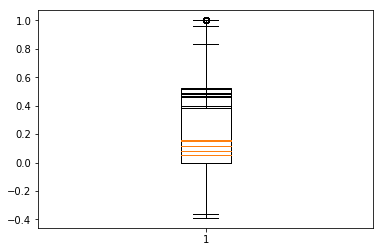

In [45]:
clustering_list=[cluster_kshape, cluster_features, cluster_graph]
clustering_name=['cluster_kshape', 'cluster_features', 'cluster_graph']
methods_list=[do_xgboost, do_lightfm, catboost, avg_merchant]
methods_name=['xgboost', 'do_lightfm', 'catboost', 'avg_merchant']
return_pred=0
sum_pred_test=pd.DataFrame()
scores_cluster=pd.DataFrame(columns=['cluster_type', 'cluster_number','method', 'rmse', 'total_clusters'])



i=0
for clustering in clustering_list:
    cluster_range = np.arange(5,100,10)
    for num_cluster in cluster_range:
        print(clustering_name[i])
        cluster_pred=clustering(train, test, data,return_pred, num_cluster)
        test_k = test.merge(cluster_pred, on='card_id')
        train_k = train.merge(cluster_pred, on='card_id')
        clusters = train_k['cluster'].unique()
        for cluster in clusters:
            print(cluster)
            train_i = train_k[train_k['cluster'] == cluster]
            test_i = test_k[test_k['cluster'] == cluster]
            sum_rmse=0
            j=0
            for method in methods_list:
                print(methods_name[j])
                print(method)
                try:
                    rmse, y_pred = method(train_i,test_i, data,return_pred, num_cluster)
                except:
                    pass # doing nothing on exception
                #else:
                 #   rmse=np.nan
                 #   y_pred=pd.DataFrame.from_dict({"card_id":[0], 'target':[0]})

                scores_cluster = scores_cluster.append(
                {'cluster_type': clustering_name[i], 'cluster_number': cluster, 'method': methods_name[j], 'rmse': rmse, 'total_clusters':num_cluster},
                ignore_index=True)
                scores_cluster.to_csv('scores_clustering_optimalnumber.csv')
                sum_pred_test=sum_pred_test.append(y_pred)
                #sum_pred_test.to_csv('scores_clustering.csv')
                j = j + 1
    i=i+1

In [46]:
scores_cluster

cluster_type cluster_number        method      rmse total_clusters
0     cluster_kshape              3       xgboost  3.236093              5
1     cluster_kshape              3    do_lightfm  3.308072              5
2     cluster_kshape              3      catboost  3.170437              5
3     cluster_kshape              3  avg_merchant  3.198207              5
4     cluster_kshape              4       xgboost  4.901457              5
5     cluster_kshape              4    do_lightfm  5.012565              5
6     cluster_kshape              4      catboost  4.842772              5
7     cluster_kshape              4  avg_merchant  5.607500              5
8     cluster_kshape              0       xgboost  1.898218              5
9     cluster_kshape              0    do_lightfm  3.377552              5
10    cluster_kshape              0      catboost  1.803902              5
11    cluster_kshape              0  avg_merchant  1.917516              5
12    cluster_kshape              2       xgboost  4.537373              5
13    cluster_kshape              2    do_lightfm  4.493426              5
14    cluster_kshape              2      catboost  4.446306              5
15    cluster_kshape              2  avg_merchant  4.441320              5
16    cluster_kshape              1       xgboost  7.683114              5
17    cluster_kshape              1    do_lightfm  7.553578              5
18    cluster_kshape              1      catboost  7.429454              5
19    cluster_kshape              1  avg_merchant  7.425403              5
20    cluster_kshape             14       xgboost  1.260516             15
21    cluster_kshape             14    do_lightfm  1.956113             15
22    cluster_kshape             14      catboost  0.986488             15
23    cluster_kshape             14  avg_merchant  0.985421             15
24    cluster_kshape             11       xgboost  1.921500             15
25    cluster_kshape             11    do_lightfm  2.647576             15
26    cluster_kshape             11      catboost  1.897776             15
27    cluster_kshape             11  avg_merchant  1.714459             15
28    cluster_kshape              3       xgboost  1.854831             15
29    cluster_kshape              3    do_lightfm  2.120366             15
...              ...            ...           ...       ...            ...
5602   cluster_graph             26      catboost  0.672831             95
5603   cluster_graph             26  avg_merchant  0.672831             95
5604   cluster_graph              7       xgboost  3.217393             95
5605   cluster_graph              7    do_lightfm  3.235166             95
5606   cluster_graph              7      catboost  2.945993             95
5607   cluster_graph              7  avg_merchant  3.046055             95
5608   cluster_graph             35       xgboost  0.712858             95
5609   cluster_graph             35    do_lightfm  0.720330             95
5610   cluster_graph             35      catboost  0.001136             95
5611   cluster_graph             35  avg_merchant  0.532924             95
5612   cluster_graph             43       xgboost  0.532924             95
5613   cluster_graph             43    do_lightfm  0.532924             95
5614   cluster_graph             43      catboost  0.532924             95
5615   cluster_graph             43  avg_merchant  0.532924             95
5616   cluster_graph             40       xgboost  0.532924             95
5617   cluster_graph             40    do_lightfm  0.532924             95
5618   cluster_graph             40      catboost  0.532924             95
5619   cluster_graph             40  avg_merchant  0.532924             95
5620   cluster_graph             39       xgboost  5.919984             95
5621   cluster_graph             39    do_lightfm  4.514699             95
5622   cluster_graph             39      catboost  4.514699             95
5623   cluster_graph             

In [51]:
sumary=pd.pivot_table(scores_cluster[scores_cluster.cluster_type != 'cluster_graph'],index=["cluster_type", 'total_clusters'],values=["rmse"],
               columns=["method"],aggfunc=[np.mean], margins=True)

In [52]:
sumary

mean                                 \
                                        rmse                                  
method                          avg_merchant  catboost do_lightfm   xgboost   
cluster_type     total_clusters                                               
cluster_features 5                  2.384255  2.301972   2.675022  2.424449   
                 15                 2.354029  2.262138   2.692956  2.376468   
                 25                 2.066341  1.877881   2.268062  2.045384   
                 35                 2.178510  1.962591   2.384554  2.052622   
                 45                 2.388630  2.139513   2.638161  2.273481   
                 55                 2.048070  1.825115   2.182974  1.942621   
                 65                 1.945296  1.771700   2.088801  1.885494   
                 75                 2.162797  1.804363   2.255166  1.951854   
                 85                 1.852926  1.669524   1.951700  1.819786   
                 95                 2.097437  1.918155   2.203560  2.034163   
cluster_kshape   5                  4.517989  4.338574   4.749039  4.451251   
                 15                 3.787007  3.404928   4.084741  3.569806   
                 25                 3.040519  2.794354   3.549759  2.910904   
                 35                 3.167937  2.913564   3.355409  3.077446   
                 45                 3.108579  2.770775   3.269889  2.876402   
                 55                 3.031927  2.538288   3.002067  2.682462   
                 65                 2.652893  2.241311   2.688532  2.375293   
                 75                 2.716899  2.144696   2.690719  2.364779   
                 85                 3.038545  2.542381   3.078795  2.716975   
                 95                 2.497005  2.122660   2.567748  2.301656   
All                                 2.494880  2.172978   2.607874  2.319147   

                                           
                                           
method                                All  
cluster_type     total_clusters            
cluster_features 5               2.446424  
                 15              2.421398  
                 25              2.064417  
                 35              2.144569  
                 45              2.359946  
                 55              1.999695  
                 65              1.922823  
                 75              2.043545  
                 85              1.823484  
                 95              2.063329  
cluster_kshape   5               4.514213  
                 15              3.711620  
                 25              3.073884  
                 35              3.128589  
                 45              3.006411  
                 55              2.813686  
                 65              2.489507  
                 75              2.479273  
                 85              2.844174  
                 95              2.372267  
All                              2.398720